In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# === Load and clean dataset ===
file_path = '/content/drive/MyDrive/Colab Notebooks/Sunly test/Predictions.xlsx'
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Drop unnecessary columns
df = df.drop(columns=["unit", "unit.1", "Unnamed: 6"], errors="ignore")

# Rename columns
df = df.rename(columns={
    "pv_power_prediction_day_ahead_p10": "P10_kW",
    "pv_power_prediction_day_ahead_p50": "P50_kW",
    "pv_power_prediction_day_ahead_p90": "P90_kW",
    "actual_power": "Actual_kW",
    "day-ahead price": "DA_price"
})

# Convert to datetime
df["start_time"] = pd.to_datetime(df["start_time"])

# === Add synthetic balancing prices ===
# Base case spreads (in €/MWh)
UPWARD_SPREAD = 30
DOWNWARD_SPREAD = 20

# Deterministic scenario
df["Upward_price_det"] = df["DA_price"] + UPWARD_SPREAD
df["Downward_price_det"] = df["DA_price"] - DOWNWARD_SPREAD

# Stochastic spreads (Normal distribution, truncated at 0)
np.random.seed(42)
df["Upward_price_stoch"] = df["DA_price"] + np.maximum(0, np.random.normal(30, 10, len(df)))
df["Downward_price_stoch"] = df["DA_price"] - np.maximum(0, np.random.normal(20, 7, len(df)))

print(df.head(10))


           start_time  P10_kW  P50_kW  P90_kW  Actual_kW  DA_price  \
0 2025-09-15 00:15:00       0     0.0       0        0.0     20.64   
1 2025-09-15 00:30:00       0     0.0       0        0.0     20.64   
2 2025-09-15 00:45:00       0     0.0       0        0.0     20.64   
3 2025-09-15 01:00:00       0     0.0       0        0.0     20.64   
4 2025-09-15 01:15:00       0     0.0       0        0.0     18.27   
5 2025-09-15 01:30:00       0     0.0       0        0.0     18.27   
6 2025-09-15 01:45:00       0     0.0       0        0.0     18.27   
7 2025-09-15 02:00:00       0     0.0       0        0.0     18.27   
8 2025-09-15 02:15:00       0     0.0       0        0.0      9.21   
9 2025-09-15 02:30:00       0     0.0       0        0.0      9.21   

   Upward_price_det  Downward_price_det  Upward_price_stoch  \
0             50.64                0.64           55.607142   
1             50.64                0.64           49.257357   
2             50.64                0.64 

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# ============================================================
# CONFIGURATION
# ============================================================

FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/Sunly test/Predictions.xlsx'  # Adjust as needed
SHEET_NAME = "Sheet1"

# Monte Carlo parameters
NUM_SIMS = 3000
CVaR_ALPHA = 0.05
CURTAIL_ALLOWED = True
CURTAIL_COST_PER_MWH = 0.0

# Synthetic price generator parameters (Option A + spikes)
PRICE_GEN = {
    "mu_up": 30, "sigma_up": 10,
    "mu_down": 20, "sigma_down": 7,
    "spike_prob": 0.007,
    "spike_min": 150, "spike_max": 600
}

# Set to track previously logged corrections
CORRECTED_P_VALUES = set()

# Risk aversion parameter for penalizing imbalance risk in selection
RISK_AVERSION_LAMBDA = 15.0

# Minimum sold volume when expected revenue positive
MIN_SOLD_VOLUME = 0.05  # MWh

# ============================================================
# STEP 1 — LOAD AND CLEAN
# ============================================================

def load_and_clean_dataset(file_path, sheet_name):
    print("Loading and cleaning input file...")
    df = pd.read_excel(file_path, sheet_name=sheet_name)

    df = df.drop(columns=["unit", "unit.1", "Unnamed: 6"], errors="ignore")

    df = df.rename(columns={
        "pv_power_prediction_day_ahead_p10": "P10_kW",
        "pv_power_prediction_day_ahead_p50": "P50_kW",
        "pv_power_prediction_day_ahead_p90": "P90_kW",
        "actual_power": "Actual_kW",
        "day-ahead price": "DA_price"
    })

    df["start_time"] = pd.to_datetime(df["start_time"])
    df = df.sort_values("start_time")

    # Convert kW quarter-hour to MWh (0.25 hours per MTU and divide by 1000)
    for col in ["P10_kW", "P50_kW", "P90_kW", "Actual_kW"]:
        df[col.replace("_kW", "_MWh")] = df[col] * 0.25 / 1000

    # Add upward and downward imbalance prices (mean values)
    df["Upward_price"] = df["DA_price"] + PRICE_GEN["mu_up"]
    df["Downward_price"] = df["DA_price"] - PRICE_GEN["mu_down"]

    print(f"Found {len(df)} MTUs.")
    return df

# ============================================================
# STEP 2 — GENERATORS
# ============================================================

def sample_production(p10, p50, p90, n=NUM_SIMS):
    original = (round(p10, 5), round(p50, 5), round(p90, 5))
    if p10 > p90:
        p10 = p90 = p50 = (p10 + p50 + p90) / 3
    else:
        if p10 > p50:
            p50 = p10
        if p50 > p90:
            p50 = p90

    corrected = (round(p10, 5), round(p50, 5), round(p90, 5))

    if original != corrected and corrected not in CORRECTED_P_VALUES:
        print(f"⚠️ Corrected invalid P-values: {original} → {corrected}")
        CORRECTED_P_VALUES.add(corrected)

    if corrected[0] == corrected[2]:
        return np.full(n, corrected[1])

    try:
        return np.random.triangular(left=corrected[0], mode=corrected[1], right=corrected[2], size=n)
    except ValueError:
        return np.full(n, corrected[1])

def sample_imbalance_prices(da_price, n=NUM_SIMS):
    up = np.random.normal(da_price + PRICE_GEN["mu_up"], PRICE_GEN["sigma_up"], size=n)
    down = np.random.normal(da_price - PRICE_GEN["mu_down"], PRICE_GEN["sigma_down"], size=n)

    spikes = np.random.rand(n) < PRICE_GEN["spike_prob"]
    up[spikes] = np.random.uniform(da_price + PRICE_GEN["spike_min"],
                                   da_price + PRICE_GEN["spike_max"],
                                   size=spikes.sum())

    down = np.clip(down, 0, None)
    up = np.clip(up, 0, None)
    return up, down

# ============================================================
# STEP 3 — REVENUE SIMULATION
# ============================================================

def simulate_revenue_mtu(p10, p50, p90, da_price, n=NUM_SIMS):
    prod_samples = sample_production(p10, p50, p90, n)
    up_prices, down_prices = sample_imbalance_prices(da_price, n)

    sold_grid = np.linspace(0, p90, 50)
    exp_rev = []
    cvar_rev = []
    imbalance_std = []

    for sold in sold_grid:
        da_rev = sold * da_price
        if CURTAIL_ALLOWED:
            actual_after = np.minimum(prod_samples, sold)
        else:
            actual_after = prod_samples
        imbalance = actual_after - sold
        imbalance_price = np.where(imbalance < 0, up_prices, down_prices)
        imbalance_revenue = imbalance * imbalance_price
        total_rev = da_rev + imbalance_revenue

        if CURTAIL_ALLOWED:
            curtail_costs = -(np.maximum(0, prod_samples - sold) * CURTAIL_COST_PER_MWH)
            total_rev += curtail_costs

        exp_rev.append(np.mean(total_rev))
        var_threshold = np.quantile(total_rev, CVaR_ALPHA)
        cvar_val = np.mean(total_rev[total_rev <= var_threshold])
        cvar_rev.append(cvar_val)
        imbalance_std.append(np.std(imbalance))

    return sold_grid, np.array(exp_rev), np.array(cvar_rev), np.array(imbalance_std)

# ============================================================
# STEP 4 — OPTIMIZATION PER MTU
# ============================================================

def optimize_mtu(p10, p50, p90, da_price):
    sold_grid, exp_rev, cvar_rev, _ = simulate_revenue_mtu(p10, p50, p90, da_price)
    idx_opt = np.argmax(exp_rev)
    return {
        "sold_cont_mwh": sold_grid[idx_opt],
        "exp_rev_opt": exp_rev[idx_opt],
        "cvar_opt": cvar_rev[idx_opt],
        "sold_grid": sold_grid,
        "exp_rev": exp_rev,
        "cvar_rev": cvar_rev
    }

# ============================================================
# STEP 5 — IMPROVED CVaR + P-LEVEL SELECTION WITH RISK PENALTY & MIN SOLD VOLUME
# ============================================================

def select_best_p_level(p10, p50, p90, da_price):
    results = {}

    # Run simulation once for the sold grid
    sold_grid, exp_rev, cvar_rev, imbalance_std = simulate_revenue_mtu(p10, p50, p90, da_price)

    for label, fixed_sold in zip(["P10", "P50", "P90"], [p10, p50, p90]):
        # Find closest index on sold grid
        idx = np.argmin(np.abs(sold_grid - fixed_sold))

        # Enforce minimum sold volume if expected revenue positive
        sold_val = sold_grid[idx]
        if exp_rev[idx] > 0 and sold_val < MIN_SOLD_VOLUME:
            sold_val = MIN_SOLD_VOLUME
            idx = np.argmin(np.abs(sold_grid - sold_val))

        # Calculate risk-penalized score = expected revenue - lambda * imbalance std
        score = exp_rev[idx] - RISK_AVERSION_LAMBDA * imbalance_std[idx]

        results[label] = {
            "sold": sold_grid[idx],
            "exp_rev": exp_rev[idx],
            "cvar": cvar_rev[idx],
            "imbalance_std": imbalance_std[idx],
            "score": score
        }

        print(f"Debug: P-level {label} | Sold: {sold_grid[idx]:.4f} MWh | "
              f"Expected Revenue: {exp_rev[idx]:.2f} EUR | "
              f"CVaR: {cvar_rev[idx]:.2f} EUR | "
              f"Imbalance Std: {imbalance_std[idx]:.4f} | "
              f"Score: {score:.2f}")

    best_label = max(results, key=lambda k: results[k]["score"])

    print(f"Debug: Selected best P-level: {best_label} with score {results[best_label]['score']:.2f}\n")

    return best_label, results

# ============================================================
# STEP 6 — REALIZED REVENUE
# ============================================================

def realized_total_for_row(row, sold_col):
    def safe_float(x):
        if isinstance(x, (pd.Series, np.ndarray, list)):
            return float(np.array(x).flatten()[0])
        return float(x)

    sold = safe_float(row[sold_col])
    da_price = safe_float(row["DA_price"])
    up_price = safe_float(row.get("Upward_price_obs", da_price + PRICE_GEN["mu_up"]))
    down_price = safe_float(row.get("Downward_price_obs", da_price - PRICE_GEN["mu_down"]))
    actual_obs = safe_float(row["Actual_MWh_obs"] if "Actual_MWh_obs" in row.index else row["Actual_MWh"])

    if CURTAIL_ALLOWED:
        actual_after = min(actual_obs, sold)
        curtail_vol = max(0.0, actual_obs - sold)
    else:
        actual_after = actual_obs
        curtail_vol = 0.0

    imbalance = actual_after - sold
    imbal_price = up_price if imbalance < 0 else down_price
    imbal_rev = imbalance * imbal_price
    curtail_costs = -(curtail_vol * CURTAIL_COST_PER_MWH)

    return sold * da_price + imbal_rev + curtail_costs

# ============================================================
# STEP 7 — MAIN PIPELINE
# ============================================================

def run_pipeline():
    df = load_and_clean_dataset(FILE_PATH, SHEET_NAME)

    results = []
    print(f"Running Monte-Carlo with {NUM_SIMS} sims per MTU...")

    for _, row in tqdm(df.iterrows(), total=len(df), desc="MTUs"):
        p10, p50, p90, da_price = row["P10_MWh"], row["P50_MWh"], row["P90_MWh"], row["DA_price"]
        opt = optimize_mtu(p10, p50, p90, da_price)
        best_p, p_res = select_best_p_level(p10, p50, p90, da_price)

        results.append({
            "start_time": row["start_time"],
            "DA_price": da_price,
            "sold_cont_mwh": opt["sold_cont_mwh"],
            "exp_rev_opt": opt["exp_rev_opt"],
            "cvar_opt": opt["cvar_opt"],
            "best_p": best_p,
            "best_p_sold_mwh": p_res[best_p]["sold"],
            "exp_rev_P10": p_res["P10"]["exp_rev"],
            "exp_rev_P50": p_res["P50"]["exp_rev"],
            "exp_rev_P90": p_res["P90"]["exp_rev"]
        })

    result_df = pd.DataFrame(results)
    merged = pd.merge(result_df, df[["start_time", "Actual_MWh"]], on="start_time", how="left")
    merged = merged.rename(columns={"Actual_MWh": "Actual_MWh_obs"})

    # Calculate realized revenues
    merged["realized_rev_cont"] = merged.apply(lambda r: realized_total_for_row(r, "sold_cont_mwh"), axis=1)
    merged["realized_rev_best_p"] = merged.apply(lambda r: realized_total_for_row(r, "best_p_sold_mwh"), axis=1)

    total_exp_rev_cont = merged["exp_rev_opt"].sum()
    total_exp_rev_best_p = max(
        merged["exp_rev_P10"].sum(),
        merged["exp_rev_P50"].sum(),
        merged["exp_rev_P90"].sum()
    )
    total_realized_cont = merged["realized_rev_cont"].sum()
    total_realized_bestp = merged["realized_rev_best_p"].sum()

    print("\n=== SUMMARY ===")
    print(f"Expected total (continuous opt): {total_exp_rev_cont:,.2f} EUR")
    print(f"Expected total (best P-level):   {total_exp_rev_best_p:,.2f} EUR")
    print(f"Realized total (continuous opt): {total_realized_cont:,.2f} EUR")
    print(f"Realized total (best P-level):   {total_realized_bestp:,.2f} EUR")

    return merged

# ============================================================
# RUN
# ============================================================

if __name__ == "__main__":
    result_df = run_pipeline()
    result_df.to_excel("sunly_montecarlo_strategy_results.xlsx", index=False)
    print("\nSaved output → sunly_montecarlo_strategy_results.xlsx")

    # ============================================================
    # ANALYSIS AFTER SIMULATION
    # ============================================================

    # Load the dataset
    df = pd.read_excel("sunly_montecarlo_strategy_results.xlsx")

    # Preview columns
    print("\nColumns in dataset:")
    print(df.columns.tolist())

    # -------------------------------
    # 1. Basic Descriptive Statistics
    print("\n=== Descriptive statistics ===")
    desc_stats = df.describe()
    print(desc_stats)

    # -------------------------------
    # 2. Key Revenue Totals & Averages
    print("\n=== Revenue Totals & Means ===")
    total_exp_rev_opt = df["exp_rev_opt"].sum()
    total_exp_rev_p50 = df["exp_rev_P50"].sum()
    total_realized_rev_opt = df["realized_rev_cont"].sum()
    total_realized_rev_best_p = df["realized_rev_best_p"].sum()

    print(f"Total Expected Revenue (Optimized): {total_exp_rev_opt:.2f} EUR")
    print(f"Total Expected Revenue (P50): {total_exp_rev_p50:.2f} EUR")
    print(f"Total Realized Revenue (Optimized): {total_realized_rev_opt:.2f} EUR")
    print(f"Total Realized Revenue (Best P-level): {total_realized_rev_best_p:.2f} EUR")

    print(f"Mean Expected Revenue per MTU (Optimized): {df['exp_rev_opt'].mean():.2f} EUR")
    print(f"Mean Realized Revenue per MTU (Optimized): {df['realized_rev_cont'].mean():.2f} EUR")

    # -------------------------------
    # 3. Sold Volume Stats
    print("\n=== Sold Volume Stats (MWh) ===")
    print("Optimized Sold Volume:")
    print(df["sold_cont_mwh"].describe())

    print("\nBest P-level Sold Volume:")
    print(df["best_p_sold_mwh"].describe())

    print("\nActual Production:")
    print(df["Actual_MWh_obs"].describe())

    # -------------------------------
    # 4. Imbalance Stats (Actual - Sold)
    df["imbalance_opt"] = df["Actual_MWh_obs"] - df["sold_cont_mwh"]
    df["imbalance_best_p"] = df["Actual_MWh_obs"] - df["best_p_sold_mwh"]

    print("\n=== Imbalance Volume Stats (MWh) ===")
    print("Optimized Strategy Imbalance:")
    print(df["imbalance_opt"].describe())

    print("\nBest P-level Strategy Imbalance:")
    print(df["imbalance_best_p"].describe())

    # -------------------------------
    # 5. Distribution of Best P-level Choices
    print("\n=== Frequency of Best P-level Choices ===")
    print(df["best_p"].value_counts())

    # -------------------------------
    # 6. Correlation Matrix (Select variables)
    print("\n=== Correlation Matrix ===")
    corr = df[[
        "exp_rev_opt", "exp_rev_P50", "realized_rev_cont", "realized_rev_best_p",
        "sold_cont_mwh", "best_p_sold_mwh", "Actual_MWh_obs",
        "imbalance_opt", "imbalance_best_p"
    ]].corr()
    print(corr)

    # -------------------------------
    # 7. Checking for Negative or Invalid Values
    print("\n=== Checking for negative or zero values in key variables ===")
    for col in ["sold_cont_mwh", "best_p_sold_mwh", "Actual_MWh_obs"]:
        neg_count = (df[col] < 0).sum()
        zero_count = (df[col] == 0).sum()
        print(f"{col}: negative count = {neg_count}, zero count = {zero_count}")






Loading and cleaning input file...
Found 1535 MTUs.
Running Monte-Carlo with 3000 sims per MTU...


MTUs:   0%|          | 5/1535 [00:00<00:33, 45.83it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:   1%|          | 10/1535 [00:00<00:33, 45.24it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00



MTUs:   1%|          | 15/1535 [00:00<00:33, 45.80it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:   1%|▏         | 20/1535 [00:00<00:32, 46.30it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00



MTUs:   2%|▏         | 25/1535 [00:00<00:33, 45.38it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:   2%|▏         | 35/1535 [00:00<00:33, 44.59it/s]

⚠️ Corrected invalid P-values: (0.2545, 0.17625, 0.1175) → (0.18275, 0.18275, 0.18275)
Debug: P-level P10 | Sold: 0.1175 MWh | Expected Revenue: 16.33 EUR | CVaR: 16.33 EUR | Imbalance Std: 0.0000 | Score: 16.33
Debug: P-level P50 | Sold: 0.1175 MWh | Expected Revenue: 16.33 EUR | CVaR: 16.33 EUR | Imbalance Std: 0.0000 | Score: 16.33
Debug: P-level P90 | Sold: 0.1175 MWh | Expected Revenue: 16.33 EUR | CVaR: 16.33 EUR | Imbalance Std: 0.0000 | Score: 16.33
Debug: Selected best P-level: P10 with score 16.33

⚠️ Corrected invalid P-values: (0.34275, 0.2545, 0.17625) → (0.25783, 0.25783, 0.25783)
Debug: P-level P10 | Sold: 0.1762 MWh | Expected Revenue: 24.49 EUR | CVaR: 24.49 EUR | Imbalance Std: 0.0000 | Score: 24.49
Debug: P-level P50 | Sold: 0.1762 MWh | Expected Revenue: 24.49 EUR | CVaR: 24.49 EUR | Imbalance Std: 0.0000 | Score: 24.49
Debug: P-level P90 | Sold: 0.1762 MWh | Expected Revenue: 24.49 EUR | CVaR: 24.49 EUR | Imbalance Std: 0.0000 | Score: 24.49
Debug: Selected best P-

MTUs:   3%|▎         | 45/1535 [00:01<00:35, 42.09it/s]

Debug: P-level P10 | Sold: 0.4472 MWh | Expected Revenue: 60.93 EUR | CVaR: 60.93 EUR | Imbalance Std: 0.0000 | Score: 60.93
Debug: P-level P50 | Sold: 0.4472 MWh | Expected Revenue: 60.93 EUR | CVaR: 60.93 EUR | Imbalance Std: 0.0000 | Score: 60.93
Debug: P-level P90 | Sold: 0.4472 MWh | Expected Revenue: 60.93 EUR | CVaR: 60.93 EUR | Imbalance Std: 0.0000 | Score: 60.93
Debug: Selected best P-level: P10 with score 60.93

⚠️ Corrected invalid P-values: (1.1565, 0.804, 0.4735) → (0.81133, 0.81133, 0.81133)
Debug: P-level P10 | Sold: 0.4735 MWh | Expected Revenue: 64.51 EUR | CVaR: 64.51 EUR | Imbalance Std: 0.0000 | Score: 64.51
Debug: P-level P50 | Sold: 0.4735 MWh | Expected Revenue: 64.51 EUR | CVaR: 64.51 EUR | Imbalance Std: 0.0000 | Score: 64.51
Debug: P-level P90 | Sold: 0.4735 MWh | Expected Revenue: 64.51 EUR | CVaR: 64.51 EUR | Imbalance Std: 0.0000 | Score: 64.51
Debug: Selected best P-level: P10 with score 64.51

⚠️ Corrected invalid P-values: (1.2555, 0.859, 0.4845) → (0.8

MTUs:   4%|▎         | 55/1535 [00:01<00:33, 43.95it/s]

Debug: P-level P10 | Sold: 0.6460 MWh | Expected Revenue: 23.77 EUR | CVaR: 23.77 EUR | Imbalance Std: 0.0000 | Score: 23.77
Debug: P-level P50 | Sold: 0.6460 MWh | Expected Revenue: 23.77 EUR | CVaR: 23.77 EUR | Imbalance Std: 0.0000 | Score: 23.77
Debug: P-level P90 | Sold: 0.6460 MWh | Expected Revenue: 23.77 EUR | CVaR: 23.77 EUR | Imbalance Std: 0.0000 | Score: 23.77
Debug: Selected best P-level: P10 with score 23.77

⚠️ Corrected invalid P-values: (2.1715, 1.18378, 0.646) → (1.33376, 1.33376, 1.33376)
Debug: P-level P10 | Sold: 0.6460 MWh | Expected Revenue: 45.93 EUR | CVaR: 45.93 EUR | Imbalance Std: 0.0000 | Score: 45.93
Debug: P-level P50 | Sold: 0.6460 MWh | Expected Revenue: 45.93 EUR | CVaR: 45.93 EUR | Imbalance Std: 0.0000 | Score: 45.93
Debug: P-level P90 | Sold: 0.6460 MWh | Expected Revenue: 45.93 EUR | CVaR: 45.93 EUR | Imbalance Std: 0.0000 | Score: 45.93
Debug: Selected best P-level: P10 with score 45.93

⚠️ Corrected invalid P-values: (2.22725, 1.20047, 0.6235) → 

MTUs:   4%|▍         | 65/1535 [00:01<00:32, 44.82it/s]

Debug: P-level P10 | Sold: 0.5288 MWh | Expected Revenue: 10.99 EUR | CVaR: 10.99 EUR | Imbalance Std: 0.0000 | Score: 10.99
Debug: P-level P50 | Sold: 0.5288 MWh | Expected Revenue: 10.99 EUR | CVaR: 10.99 EUR | Imbalance Std: 0.0000 | Score: 10.99
Debug: P-level P90 | Sold: 0.5288 MWh | Expected Revenue: 10.99 EUR | CVaR: 10.99 EUR | Imbalance Std: 0.0000 | Score: 10.99
Debug: Selected best P-level: P10 with score 10.99

⚠️ Corrected invalid P-values: (2.423, 1.42075, 0.51775) → (1.45383, 1.45383, 1.45383)
Debug: P-level P10 | Sold: 0.5178 MWh | Expected Revenue: 10.76 EUR | CVaR: 10.76 EUR | Imbalance Std: 0.0000 | Score: 10.76
Debug: P-level P50 | Sold: 0.5178 MWh | Expected Revenue: 10.76 EUR | CVaR: 10.76 EUR | Imbalance Std: 0.0000 | Score: 10.76
Debug: P-level P90 | Sold: 0.5178 MWh | Expected Revenue: 10.76 EUR | CVaR: 10.76 EUR | Imbalance Std: 0.0000 | Score: 10.76
Debug: Selected best P-level: P10 with score 10.76

⚠️ Corrected invalid P-values: (2.43975, 1.416, 0.53375) → 

MTUs:   5%|▍         | 75/1535 [00:01<00:32, 45.11it/s]

Debug: P-level P10 | Sold: 0.5158 MWh | Expected Revenue: 59.77 EUR | CVaR: 59.77 EUR | Imbalance Std: 0.0000 | Score: 59.77
Debug: P-level P50 | Sold: 0.5158 MWh | Expected Revenue: 59.77 EUR | CVaR: 59.77 EUR | Imbalance Std: 0.0000 | Score: 59.77
Debug: P-level P90 | Sold: 0.5158 MWh | Expected Revenue: 59.77 EUR | CVaR: 59.77 EUR | Imbalance Std: 0.0000 | Score: 59.77
Debug: Selected best P-level: P10 with score 59.77

⚠️ Corrected invalid P-values: (1.79975, 0.92625, 0.442) → (1.056, 1.056, 1.056)
Debug: P-level P10 | Sold: 0.4420 MWh | Expected Revenue: 37.23 EUR | CVaR: 37.23 EUR | Imbalance Std: 0.0000 | Score: 37.23
Debug: P-level P50 | Sold: 0.4420 MWh | Expected Revenue: 37.23 EUR | CVaR: 37.23 EUR | Imbalance Std: 0.0000 | Score: 37.23
Debug: P-level P90 | Sold: 0.4420 MWh | Expected Revenue: 37.23 EUR | CVaR: 37.23 EUR | Imbalance Std: 0.0000 | Score: 37.23
Debug: Selected best P-level: P10 with score 37.23

⚠️ Corrected invalid P-values: (1.5365, 0.78925, 0.36825) → (0.89

MTUs:   6%|▌         | 85/1535 [00:01<00:32, 45.10it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:   6%|▌         | 90/1535 [00:02<00:33, 42.55it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:   6%|▌         | 95/1535 [00:02<00:34, 42.18it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00



MTUs:   7%|▋         | 100/1535 [00:02<00:33, 42.97it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:   7%|▋         | 110/1535 [00:02<00:32, 43.62it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:   8%|▊         | 120/1535 [00:02<00:34, 41.08it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:   8%|▊         | 130/1535 [00:02<00:32, 42.65it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

⚠️ Corrected invalid P-values: (0.049, 0.02925, 0.0195) → (0.03258, 0.03258, 0.03258)
Debug: P-level P10 | Sold: 0.0195 MWh | Expected Revenue: 1.05 EUR | CVaR: 1.05 

MTUs:   9%|▉         | 135/1535 [00:03<00:35, 39.96it/s]

Debug: P-level P10 | Sold: 0.4790 MWh | Expected Revenue: 56.35 EUR | CVaR: 56.35 EUR | Imbalance Std: 0.0000 | Score: 56.35
Debug: P-level P50 | Sold: 0.4790 MWh | Expected Revenue: 56.35 EUR | CVaR: 56.35 EUR | Imbalance Std: 0.0000 | Score: 56.35
Debug: P-level P90 | Sold: 0.4790 MWh | Expected Revenue: 56.35 EUR | CVaR: 56.35 EUR | Imbalance Std: 0.0000 | Score: 56.35
Debug: Selected best P-level: P10 with score 56.35

⚠️ Corrected invalid P-values: (0.99025, 0.74525, 0.52175) → (0.75242, 0.75242, 0.75242)
Debug: P-level P10 | Sold: 0.5218 MWh | Expected Revenue: 50.13 EUR | CVaR: 50.13 EUR | Imbalance Std: 0.0000 | Score: 50.13
Debug: P-level P50 | Sold: 0.5218 MWh | Expected Revenue: 50.13 EUR | CVaR: 50.13 EUR | Imbalance Std: 0.0000 | Score: 50.13
Debug: P-level P90 | Sold: 0.5218 MWh | Expected Revenue: 50.13 EUR | CVaR: 50.13 EUR | Imbalance Std: 0.0000 | Score: 50.13
Debug: Selected best P-level: P10 with score 50.13

⚠️ Corrected invalid P-values: (1.17125, 0.85175, 0.543) 

MTUs:   9%|▉         | 140/1535 [00:03<00:33, 41.34it/s]

Debug: P-level P10 | Sold: 0.6937 MWh | Expected Revenue: 43.55 EUR | CVaR: 43.55 EUR | Imbalance Std: 0.0000 | Score: 43.55
Debug: P-level P50 | Sold: 0.6937 MWh | Expected Revenue: 43.55 EUR | CVaR: 43.55 EUR | Imbalance Std: 0.0000 | Score: 43.55
Debug: P-level P90 | Sold: 0.6937 MWh | Expected Revenue: 43.55 EUR | CVaR: 43.55 EUR | Imbalance Std: 0.0000 | Score: 43.55
Debug: Selected best P-level: P10 with score 43.55

⚠️ Corrected invalid P-values: (3.0735, 1.69275, 0.746) → (1.83742, 1.83742, 1.83742)
Debug: P-level P10 | Sold: 0.7460 MWh | Expected Revenue: 46.83 EUR | CVaR: 46.83 EUR | Imbalance Std: 0.0000 | Score: 46.83
Debug: P-level P50 | Sold: 0.7460 MWh | Expected Revenue: 46.83 EUR | CVaR: 46.83 EUR | Imbalance Std: 0.0000 | Score: 46.83
Debug: P-level P90 | Sold: 0.7460 MWh | Expected Revenue: 46.83 EUR | CVaR: 46.83 EUR | Imbalance Std: 0.0000 | Score: 46.83
Debug: Selected best P-level: P10 with score 46.83



MTUs:   9%|▉         | 145/1535 [00:03<00:33, 41.57it/s]

⚠️ Corrected invalid P-values: (3.65275, 1.882, 0.80175) → (2.11217, 2.11217, 2.11217)
Debug: P-level P10 | Sold: 0.8017 MWh | Expected Revenue: 21.44 EUR | CVaR: 21.44 EUR | Imbalance Std: 0.0000 | Score: 21.44
Debug: P-level P50 | Sold: 0.8017 MWh | Expected Revenue: 21.44 EUR | CVaR: 21.44 EUR | Imbalance Std: 0.0000 | Score: 21.44
Debug: P-level P90 | Sold: 0.8017 MWh | Expected Revenue: 21.44 EUR | CVaR: 21.44 EUR | Imbalance Std: 0.0000 | Score: 21.44
Debug: Selected best P-level: P10 with score 21.44

⚠️ Corrected invalid P-values: (4.254, 2.06025, 0.8685) → (2.39425, 2.39425, 2.39425)
Debug: P-level P10 | Sold: 0.8685 MWh | Expected Revenue: 23.22 EUR | CVaR: 23.22 EUR | Imbalance Std: 0.0000 | Score: 23.22
Debug: P-level P50 | Sold: 0.8685 MWh | Expected Revenue: 23.22 EUR | CVaR: 23.22 EUR | Imbalance Std: 0.0000 | Score: 23.22
Debug: P-level P90 | Sold: 0.8685 MWh | Expected Revenue: 23.22 EUR | CVaR: 23.22 EUR | Imbalance Std: 0.0000 | Score: 23.22
Debug: Selected best P-le

MTUs:  10%|█         | 155/1535 [00:03<00:32, 42.70it/s]

Debug: P-level P10 | Sold: 1.1805 MWh | Expected Revenue: 14.76 EUR | CVaR: 14.76 EUR | Imbalance Std: 0.0000 | Score: 14.76
Debug: P-level P50 | Sold: 1.1805 MWh | Expected Revenue: 14.76 EUR | CVaR: 14.76 EUR | Imbalance Std: 0.0000 | Score: 14.76
Debug: P-level P90 | Sold: 1.1805 MWh | Expected Revenue: 14.76 EUR | CVaR: 14.76 EUR | Imbalance Std: 0.0000 | Score: 14.76
Debug: Selected best P-level: P10 with score 14.76

⚠️ Corrected invalid P-values: (8.35, 3.9645, 1.15825) → (4.49092, 4.49092, 4.49092)
Debug: P-level P10 | Sold: 1.1583 MWh | Expected Revenue: 14.48 EUR | CVaR: 14.48 EUR | Imbalance Std: 0.0000 | Score: 14.48
Debug: P-level P50 | Sold: 1.1583 MWh | Expected Revenue: 14.48 EUR | CVaR: 14.48 EUR | Imbalance Std: 0.0000 | Score: 14.48
Debug: P-level P90 | Sold: 1.1583 MWh | Expected Revenue: 14.48 EUR | CVaR: 14.48 EUR | Imbalance Std: 0.0000 | Score: 14.48
Debug: Selected best P-level: P10 with score 14.48

⚠️ Corrected invalid P-values: (8.35, 4.10925, 1.136) → (4.53

MTUs:  11%|█         | 165/1535 [00:03<00:32, 41.89it/s]

Debug: P-level P10 | Sold: 0.9802 MWh | Expected Revenue: 9.81 EUR | CVaR: 9.81 EUR | Imbalance Std: 0.0000 | Score: 9.81
Debug: P-level P50 | Sold: 0.9802 MWh | Expected Revenue: 9.81 EUR | CVaR: 9.81 EUR | Imbalance Std: 0.0000 | Score: 9.81
Debug: P-level P90 | Sold: 0.9802 MWh | Expected Revenue: 9.81 EUR | CVaR: 9.81 EUR | Imbalance Std: 0.0000 | Score: 9.81
Debug: Selected best P-level: P10 with score 9.81

⚠️ Corrected invalid P-values: (6.6445, 2.9486, 0.9585) → (3.5172, 3.5172, 3.5172)
Debug: P-level P10 | Sold: 0.9585 MWh | Expected Revenue: 9.59 EUR | CVaR: 9.59 EUR | Imbalance Std: 0.0000 | Score: 9.59
Debug: P-level P50 | Sold: 0.9585 MWh | Expected Revenue: 9.59 EUR | CVaR: 9.59 EUR | Imbalance Std: 0.0000 | Score: 9.59
Debug: P-level P90 | Sold: 0.9585 MWh | Expected Revenue: 9.59 EUR | CVaR: 9.59 EUR | Imbalance Std: 0.0000 | Score: 9.59
Debug: Selected best P-level: P10 with score 9.59

⚠️ Corrected invalid P-values: (6.149, 2.84093, 0.92625) → (3.30539, 3.30539, 3.305

MTUs:  11%|█▏        | 175/1535 [00:04<00:31, 43.44it/s]

Debug: P-level P10 | Sold: 0.3147 MWh | Expected Revenue: 6.56 EUR | CVaR: 6.56 EUR | Imbalance Std: 0.0000 | Score: 6.56
Debug: P-level P50 | Sold: 0.3147 MWh | Expected Revenue: 6.56 EUR | CVaR: 6.56 EUR | Imbalance Std: 0.0000 | Score: 6.56
Debug: P-level P90 | Sold: 0.3147 MWh | Expected Revenue: 6.56 EUR | CVaR: 6.56 EUR | Imbalance Std: 0.0000 | Score: 6.56
Debug: Selected best P-level: P10 with score 6.56

⚠️ Corrected invalid P-values: (1.56425, 0.74255, 0.2235) → (0.84343, 0.84343, 0.84343)
Debug: P-level P10 | Sold: 0.2235 MWh | Expected Revenue: 17.99 EUR | CVaR: 17.99 EUR | Imbalance Std: 0.0000 | Score: 17.99
Debug: P-level P50 | Sold: 0.2235 MWh | Expected Revenue: 17.99 EUR | CVaR: 17.99 EUR | Imbalance Std: 0.0000 | Score: 17.99
Debug: P-level P90 | Sold: 0.2235 MWh | Expected Revenue: 17.99 EUR | CVaR: 17.99 EUR | Imbalance Std: 0.0000 | Score: 17.99
Debug: Selected best P-level: P10 with score 17.99

⚠️ Corrected invalid P-values: (1.07675, 0.51185, 0.14225) → (0.5769

MTUs:  12%|█▏        | 180/1535 [00:04<00:33, 40.42it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  12%|█▏        | 185/1535 [00:04<00:32, 41.10it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00



MTUs:  12%|█▏        | 190/1535 [00:04<00:32, 41.96it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  13%|█▎        | 200/1535 [00:04<00:31, 42.78it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  14%|█▎        | 210/1535 [00:04<00:31, 42.71it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  14%|█▍        | 220/1535 [00:05<00:29, 43.93it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  15%|█▍        | 225/1535 [00:05<00:32, 40.37it/s]

Debug: P-level P10 | Sold: 0.0783 MWh | Expected Revenue: 4.51 EUR | CVaR: 4.51 EUR | Imbalance Std: 0.0000 | Score: 4.51
Debug: P-level P50 | Sold: 0.0783 MWh | Expected Revenue: 4.51 EUR | CVaR: 4.51 EUR | Imbalance Std: 0.0000 | Score: 4.51
Debug: P-level P90 | Sold: 0.0783 MWh | Expected Revenue: 4.51 EUR | CVaR: 4.51 EUR | Imbalance Std: 0.0000 | Score: 4.51
Debug: Selected best P-level: P10 with score 4.51

⚠️ Corrected invalid P-values: (1.05725, 0.41125, 0.1175) → (0.52867, 0.52867, 0.52867)
Debug: P-level P10 | Sold: 0.1175 MWh | Expected Revenue: 6.78 EUR | CVaR: 6.78 EUR | Imbalance Std: 0.0000 | Score: 6.78
Debug: P-level P50 | Sold: 0.1175 MWh | Expected Revenue: 6.78 EUR | CVaR: 6.78 EUR | Imbalance Std: 0.0000 | Score: 6.78
Debug: P-level P90 | Sold: 0.1175 MWh | Expected Revenue: 6.78 EUR | CVaR: 6.78 EUR | Imbalance Std: 0.0000 | Score: 6.78
Debug: Selected best P-level: P10 with score 6.78

⚠️ Corrected invalid P-values: (1.52725, 0.56775, 0.17625) → (0.75708, 0.75708

MTUs:  15%|█▍        | 230/1535 [00:05<00:31, 41.21it/s]

Debug: P-level P10 | Sold: 0.6282 MWh | Expected Revenue: 58.47 EUR | CVaR: 58.47 EUR | Imbalance Std: 0.0000 | Score: 58.47
Debug: P-level P50 | Sold: 0.6282 MWh | Expected Revenue: 58.47 EUR | CVaR: 58.47 EUR | Imbalance Std: 0.0000 | Score: 58.47
Debug: P-level P90 | Sold: 0.6282 MWh | Expected Revenue: 58.47 EUR | CVaR: 58.47 EUR | Imbalance Std: 0.0000 | Score: 58.47
Debug: Selected best P-level: P10 with score 58.47

⚠️ Corrected invalid P-values: (5.089, 2.26775, 0.7345) → (2.69708, 2.69708, 2.69708)
Debug: P-level P10 | Sold: 0.7345 MWh | Expected Revenue: 68.36 EUR | CVaR: 68.36 EUR | Imbalance Std: 0.0000 | Score: 68.36
Debug: P-level P50 | Sold: 0.7345 MWh | Expected Revenue: 68.36 EUR | CVaR: 68.36 EUR | Imbalance Std: 0.0000 | Score: 68.36
Debug: P-level P90 | Sold: 0.7345 MWh | Expected Revenue: 68.36 EUR | CVaR: 68.36 EUR | Imbalance Std: 0.0000 | Score: 68.36
Debug: Selected best P-level: P10 with score 68.36

⚠️ Corrected invalid P-values: (5.64275, 2.59775, 0.85175) →

MTUs:  15%|█▌        | 235/1535 [00:05<00:31, 41.73it/s]

Debug: P-level P10 | Sold: 0.8518 MWh | Expected Revenue: 79.27 EUR | CVaR: 79.27 EUR | Imbalance Std: 0.0000 | Score: 79.27
Debug: P-level P50 | Sold: 0.8518 MWh | Expected Revenue: 79.27 EUR | CVaR: 79.27 EUR | Imbalance Std: 0.0000 | Score: 79.27
Debug: P-level P90 | Sold: 0.8518 MWh | Expected Revenue: 79.27 EUR | CVaR: 79.27 EUR | Imbalance Std: 0.0000 | Score: 79.27
Debug: Selected best P-level: P10 with score 79.27

⚠️ Corrected invalid P-values: (6.388, 3.03975, 0.99125) → (3.473, 3.473, 3.473)
Debug: P-level P10 | Sold: 0.9912 MWh | Expected Revenue: 92.26 EUR | CVaR: 92.26 EUR | Imbalance Std: 0.0000 | Score: 92.26
Debug: P-level P50 | Sold: 0.9912 MWh | Expected Revenue: 92.26 EUR | CVaR: 92.26 EUR | Imbalance Std: 0.0000 | Score: 92.26
Debug: P-level P90 | Sold: 0.9912 MWh | Expected Revenue: 92.26 EUR | CVaR: 92.26 EUR | Imbalance Std: 0.0000 | Score: 92.26
Debug: Selected best P-level: P10 with score 92.26

⚠️ Corrected invalid P-values: (6.91675, 3.37025, 1.1015) → (3.79

MTUs:  16%|█▌        | 245/1535 [00:05<00:32, 39.35it/s]

Debug: P-level P10 | Sold: 1.8707 MWh | Expected Revenue: 120.10 EUR | CVaR: 120.10 EUR | Imbalance Std: 0.0000 | Score: 120.10
Debug: P-level P50 | Sold: 1.8707 MWh | Expected Revenue: 120.10 EUR | CVaR: 120.10 EUR | Imbalance Std: 0.0000 | Score: 120.10
Debug: P-level P90 | Sold: 1.8707 MWh | Expected Revenue: 120.10 EUR | CVaR: 120.10 EUR | Imbalance Std: 0.0000 | Score: 120.10
Debug: Selected best P-level: P10 with score 120.10

⚠️ Corrected invalid P-values: (8.35, 5.8465, 1.98225) → (5.39292, 5.39292, 5.39292)
Debug: P-level P10 | Sold: 1.9823 MWh | Expected Revenue: 105.87 EUR | CVaR: 105.87 EUR | Imbalance Std: 0.0000 | Score: 105.87
Debug: P-level P50 | Sold: 1.9823 MWh | Expected Revenue: 105.87 EUR | CVaR: 105.87 EUR | Imbalance Std: 0.0000 | Score: 105.87
Debug: P-level P90 | Sold: 1.9823 MWh | Expected Revenue: 105.87 EUR | CVaR: 105.87 EUR | Imbalance Std: 0.0000 | Score: 105.87
Debug: Selected best P-level: P10 with score 105.87

⚠️ Corrected invalid P-values: (8.35, 4.9

MTUs:  17%|█▋        | 255/1535 [00:06<00:30, 41.62it/s]

Debug: P-level P10 | Sold: 1.7512 MWh | Expected Revenue: 134.86 EUR | CVaR: 134.86 EUR | Imbalance Std: 0.0000 | Score: 134.86
Debug: P-level P50 | Sold: 1.7512 MWh | Expected Revenue: 134.86 EUR | CVaR: 134.86 EUR | Imbalance Std: 0.0000 | Score: 134.86
Debug: P-level P90 | Sold: 1.7512 MWh | Expected Revenue: 134.86 EUR | CVaR: 134.86 EUR | Imbalance Std: 0.0000 | Score: 134.86
Debug: Selected best P-level: P10 with score 134.86

⚠️ Corrected invalid P-values: (8.35, 4.901, 1.74025) → (4.99708, 4.99708, 4.99708)
Debug: P-level P10 | Sold: 1.7403 MWh | Expected Revenue: 134.02 EUR | CVaR: 134.02 EUR | Imbalance Std: 0.0000 | Score: 134.02
Debug: P-level P50 | Sold: 1.7403 MWh | Expected Revenue: 134.02 EUR | CVaR: 134.02 EUR | Imbalance Std: 0.0000 | Score: 134.02
Debug: P-level P90 | Sold: 1.7403 MWh | Expected Revenue: 134.02 EUR | CVaR: 134.02 EUR | Imbalance Std: 0.0000 | Score: 134.02
Debug: Selected best P-level: P10 with score 134.02

⚠️ Corrected invalid P-values: (8.35, 4.82

MTUs:  17%|█▋        | 260/1535 [00:06<00:30, 41.81it/s]

Debug: P-level P10 | Sold: 1.0770 MWh | Expected Revenue: 101.53 EUR | CVaR: 101.53 EUR | Imbalance Std: 0.0000 | Score: 101.53
Debug: P-level P50 | Sold: 1.0770 MWh | Expected Revenue: 101.53 EUR | CVaR: 101.53 EUR | Imbalance Std: 0.0000 | Score: 101.53
Debug: P-level P90 | Sold: 1.0770 MWh | Expected Revenue: 101.53 EUR | CVaR: 101.53 EUR | Imbalance Std: 0.0000 | Score: 101.53
Debug: Selected best P-level: P10 with score 101.53

⚠️ Corrected invalid P-values: (5.13675, 2.89675, 0.94775) → (2.99375, 2.99375, 2.99375)
Debug: P-level P10 | Sold: 0.9477 MWh | Expected Revenue: 89.34 EUR | CVaR: 89.34 EUR | Imbalance Std: 0.0000 | Score: 89.34
Debug: P-level P50 | Sold: 0.9477 MWh | Expected Revenue: 89.34 EUR | CVaR: 89.34 EUR | Imbalance Std: 0.0000 | Score: 89.34
Debug: P-level P90 | Sold: 0.9477 MWh | Expected Revenue: 89.34 EUR | CVaR: 89.34 EUR | Imbalance Std: 0.0000 | Score: 89.34
Debug: Selected best P-level: P10 with score 89.34

⚠️ Corrected invalid P-values: (4.47275, 2.5047

MTUs:  17%|█▋        | 265/1535 [00:06<00:31, 39.78it/s]

Debug: P-level P10 | Sold: 0.3147 MWh | Expected Revenue: 26.37 EUR | CVaR: 26.37 EUR | Imbalance Std: 0.0000 | Score: 26.37
Debug: P-level P50 | Sold: 0.3147 MWh | Expected Revenue: 26.37 EUR | CVaR: 26.37 EUR | Imbalance Std: 0.0000 | Score: 26.37
Debug: P-level P90 | Sold: 0.3147 MWh | Expected Revenue: 26.37 EUR | CVaR: 26.37 EUR | Imbalance Std: 0.0000 | Score: 26.37
Debug: Selected best P-level: P10 with score 26.37

⚠️ Corrected invalid P-values: (1.59475, 0.772, 0.21325) → (0.86, 0.86, 0.86)
Debug: P-level P10 | Sold: 0.2132 MWh | Expected Revenue: 27.20 EUR | CVaR: 27.20 EUR | Imbalance Std: 0.0000 | Score: 27.20
Debug: P-level P50 | Sold: 0.2132 MWh | Expected Revenue: 27.20 EUR | CVaR: 27.20 EUR | Imbalance Std: 0.0000 | Score: 27.20
Debug: P-level P90 | Sold: 0.2132 MWh | Expected Revenue: 27.20 EUR | CVaR: 27.20 EUR | Imbalance Std: 0.0000 | Score: 27.20
Debug: Selected best P-level: P10 with score 27.20

⚠️ Corrected invalid P-values: (1.097, 0.518, 0.132) → (0.58233, 0.5

MTUs:  18%|█▊        | 270/1535 [00:06<00:31, 40.38it/s]

Debug: P-level P10 | Sold: 0.1320 MWh | Expected Revenue: 16.84 EUR | CVaR: 16.84 EUR | Imbalance Std: 0.0000 | Score: 16.84
Debug: P-level P50 | Sold: 0.1320 MWh | Expected Revenue: 16.84 EUR | CVaR: 16.84 EUR | Imbalance Std: 0.0000 | Score: 16.84
Debug: P-level P90 | Sold: 0.1320 MWh | Expected Revenue: 16.84 EUR | CVaR: 16.84 EUR | Imbalance Std: 0.0000 | Score: 16.84
Debug: Selected best P-level: P10 with score 16.84

⚠️ Corrected invalid P-values: (0.64, 0.33525, 0.0915) → (0.35558, 0.35558, 0.35558)
Debug: P-level P10 | Sold: 0.0915 MWh | Expected Revenue: 11.67 EUR | CVaR: 11.67 EUR | Imbalance Std: 0.0000 | Score: 11.67
Debug: P-level P50 | Sold: 0.0915 MWh | Expected Revenue: 11.67 EUR | CVaR: 11.67 EUR | Imbalance Std: 0.0000 | Score: 11.67
Debug: P-level P90 | Sold: 0.0915 MWh | Expected Revenue: 11.67 EUR | CVaR: 11.67 EUR | Imbalance Std: 0.0000 | Score: 11.67
Debug: Selected best P-level: P10 with score 11.67

⚠️ Corrected invalid P-values: (0.24475, 0.1449, 0.049) → (0.

MTUs:  18%|█▊        | 275/1535 [00:06<00:30, 40.69it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  18%|█▊        | 280/1535 [00:06<00:33, 37.53it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00



MTUs:  19%|█▊        | 284/1535 [00:06<00:40, 30.82it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  19%|█▉        | 288/1535 [00:07<00:46, 26.82it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  19%|█▉        | 294/1535 [00:07<00:51, 24.05it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  19%|█▉        | 297/1535 [00:07<00:53, 23.19it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  20%|█▉        | 303/1535 [00:07<00:54, 22.70it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  20%|██        | 309/1535 [00:08<00:54, 22.50it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  20%|██        | 312/1535 [00:08<00:54, 22.63it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  21%|██        | 318/1535 [00:08<00:56, 21.53it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

⚠️ Corrected invalid P-values: (0.0685, 0.0538, 0.0195) → (0.04727, 0.04727, 0.04727)
Debug: P-level P10 | Sold: 0.0195 MWh | Expected Revenue: 1.48 EUR | CVaR: 1.48 EUR | Imbalance Std: 0.0000 | Score: 1.48
Debug: P-level P50 | Sold: 0.0195 MWh | Expected Revenue: 1.48 EUR | CVaR: 1.48 EUR | Imbalance Std: 0.0000 | Score: 1.48
Debug: P-level P90 | Sold: 0.0195 MWh | Expected Revenue: 1.48 EUR | CVaR: 1.48 EUR | Imbalance Std: 0.0000 | Score: 1.48
Debug: Selected best P-level: P10 with score 1.48

⚠️ Corrected invalid P-values: (0.2545, 0.15757, 0.0685) → (0.16019, 0.16019, 0.

MTUs:  21%|██        | 321/1535 [00:08<00:57, 21.07it/s]

Debug: P-level P10 | Sold: 0.1762 MWh | Expected Revenue: 23.97 EUR | CVaR: 23.97 EUR | Imbalance Std: 0.0000 | Score: 23.97
Debug: P-level P50 | Sold: 0.1762 MWh | Expected Revenue: 23.97 EUR | CVaR: 23.97 EUR | Imbalance Std: 0.0000 | Score: 23.97
Debug: P-level P90 | Sold: 0.1762 MWh | Expected Revenue: 23.97 EUR | CVaR: 23.97 EUR | Imbalance Std: 0.0000 | Score: 23.97
Debug: Selected best P-level: P10 with score 23.97

⚠️ Corrected invalid P-values: (1.537, 0.8615, 0.2545) → (0.88433, 0.88433, 0.88433)
Debug: P-level P10 | Sold: 0.2545 MWh | Expected Revenue: 34.61 EUR | CVaR: 34.61 EUR | Imbalance Std: 0.0000 | Score: 34.61
Debug: P-level P50 | Sold: 0.2545 MWh | Expected Revenue: 34.61 EUR | CVaR: 34.61 EUR | Imbalance Std: 0.0000 | Score: 34.61
Debug: P-level P90 | Sold: 0.2545 MWh | Expected Revenue: 34.61 EUR | CVaR: 34.61 EUR | Imbalance Std: 0.0000 | Score: 34.61
Debug: Selected best P-level: P10 with score 34.61

⚠️ Corrected invalid P-values: (2.046, 1.1455, 0.34275) → (1.

MTUs:  21%|██▏       | 327/1535 [00:08<00:57, 21.00it/s]

Debug: P-level P10 | Sold: 0.7240 MWh | Expected Revenue: 86.76 EUR | CVaR: 86.76 EUR | Imbalance Std: 0.0000 | Score: 86.76
Debug: P-level P50 | Sold: 0.7240 MWh | Expected Revenue: 86.76 EUR | CVaR: 86.76 EUR | Imbalance Std: 0.0000 | Score: 86.76
Debug: P-level P90 | Sold: 0.7240 MWh | Expected Revenue: 86.76 EUR | CVaR: 86.76 EUR | Imbalance Std: 0.0000 | Score: 86.76
Debug: Selected best P-level: P10 with score 86.76

⚠️ Corrected invalid P-values: (4.55675, 2.18578, 0.85175) → (2.53143, 2.53143, 2.53143)
Debug: P-level P10 | Sold: 0.8518 MWh | Expected Revenue: 96.98 EUR | CVaR: 96.98 EUR | Imbalance Std: 0.0000 | Score: 96.98
Debug: P-level P50 | Sold: 0.8518 MWh | Expected Revenue: 96.98 EUR | CVaR: 96.98 EUR | Imbalance Std: 0.0000 | Score: 96.98
Debug: P-level P90 | Sold: 0.8518 MWh | Expected Revenue: 96.98 EUR | CVaR: 96.98 EUR | Imbalance Std: 0.0000 | Score: 96.98
Debug: Selected best P-level: P10 with score 96.98

⚠️ Corrected invalid P-values: (5.121, 2.53288, 0.99025) 

MTUs:  22%|██▏       | 333/1535 [00:09<00:56, 21.18it/s]

Debug: P-level P10 | Sold: 1.4647 MWh | Expected Revenue: 133.88 EUR | CVaR: 133.88 EUR | Imbalance Std: 0.0000 | Score: 133.88
Debug: P-level P50 | Sold: 1.4647 MWh | Expected Revenue: 133.88 EUR | CVaR: 133.88 EUR | Imbalance Std: 0.0000 | Score: 133.88
Debug: P-level P90 | Sold: 1.4647 MWh | Expected Revenue: 133.88 EUR | CVaR: 133.88 EUR | Imbalance Std: 0.0000 | Score: 133.88
Debug: Selected best P-level: P10 with score 133.88

⚠️ Corrected invalid P-values: (7.37925, 4.07515, 1.608) → (4.35413, 4.35413, 4.35413)
Debug: P-level P10 | Sold: 1.6080 MWh | Expected Revenue: 146.97 EUR | CVaR: 146.97 EUR | Imbalance Std: 0.0000 | Score: 146.97
Debug: P-level P50 | Sold: 1.6080 MWh | Expected Revenue: 146.97 EUR | CVaR: 146.97 EUR | Imbalance Std: 0.0000 | Score: 146.97
Debug: P-level P90 | Sold: 1.6080 MWh | Expected Revenue: 146.97 EUR | CVaR: 146.97 EUR | Imbalance Std: 0.0000 | Score: 146.97
Debug: Selected best P-level: P10 with score 146.97

⚠️ Corrected invalid P-values: (7.81975

MTUs:  22%|██▏       | 336/1535 [00:09<00:57, 20.99it/s]

Debug: P-level P10 | Sold: 1.8933 MWh | Expected Revenue: 126.70 EUR | CVaR: 126.70 EUR | Imbalance Std: 0.0000 | Score: 126.70
Debug: P-level P50 | Sold: 1.8933 MWh | Expected Revenue: 126.70 EUR | CVaR: 126.70 EUR | Imbalance Std: 0.0000 | Score: 126.70
Debug: P-level P90 | Sold: 1.8933 MWh | Expected Revenue: 126.70 EUR | CVaR: 126.70 EUR | Imbalance Std: 0.0000 | Score: 126.70
Debug: Selected best P-level: P10 with score 126.70

⚠️ Corrected invalid P-values: (8.35, 4.88663, 1.89325) → (5.04329, 5.04329, 5.04329)
Debug: P-level P10 | Sold: 1.8933 MWh | Expected Revenue: 126.70 EUR | CVaR: 126.70 EUR | Imbalance Std: 0.0000 | Score: 126.70
Debug: P-level P50 | Sold: 1.8933 MWh | Expected Revenue: 126.70 EUR | CVaR: 126.70 EUR | Imbalance Std: 0.0000 | Score: 126.70
Debug: P-level P90 | Sold: 1.8933 MWh | Expected Revenue: 126.70 EUR | CVaR: 126.70 EUR | Imbalance Std: 0.0000 | Score: 126.70
Debug: Selected best P-level: P10 with score 126.70

⚠️ Corrected invalid P-values: (8.35, 4.

MTUs:  22%|██▏       | 342/1535 [00:09<00:57, 20.81it/s]

Debug: P-level P10 | Sold: 1.8153 MWh | Expected Revenue: 116.03 EUR | CVaR: 116.03 EUR | Imbalance Std: 0.0000 | Score: 116.03
Debug: P-level P50 | Sold: 1.8153 MWh | Expected Revenue: 116.03 EUR | CVaR: 116.03 EUR | Imbalance Std: 0.0000 | Score: 116.03
Debug: P-level P90 | Sold: 1.8153 MWh | Expected Revenue: 116.03 EUR | CVaR: 116.03 EUR | Imbalance Std: 0.0000 | Score: 116.03
Debug: Selected best P-level: P10 with score 116.03

⚠️ Corrected invalid P-values: (8.35, 4.70952, 1.77075) → (4.94342, 4.94342, 4.94342)
Debug: P-level P10 | Sold: 1.7708 MWh | Expected Revenue: 113.19 EUR | CVaR: 113.19 EUR | Imbalance Std: 0.0000 | Score: 113.19
Debug: P-level P50 | Sold: 1.7708 MWh | Expected Revenue: 113.19 EUR | CVaR: 113.19 EUR | Imbalance Std: 0.0000 | Score: 113.19
Debug: P-level P90 | Sold: 1.7708 MWh | Expected Revenue: 113.19 EUR | CVaR: 113.19 EUR | Imbalance Std: 0.0000 | Score: 113.19
Debug: Selected best P-level: P10 with score 113.19

⚠️ Corrected invalid P-values: (8.35, 4.

MTUs:  23%|██▎       | 348/1535 [00:09<00:54, 21.59it/s]

Debug: P-level P10 | Sold: 1.5200 MWh | Expected Revenue: 60.16 EUR | CVaR: 60.16 EUR | Imbalance Std: 0.0000 | Score: 60.16
Debug: P-level P50 | Sold: 1.5200 MWh | Expected Revenue: 60.16 EUR | CVaR: 60.16 EUR | Imbalance Std: 0.0000 | Score: 60.16
Debug: P-level P90 | Sold: 1.5200 MWh | Expected Revenue: 60.16 EUR | CVaR: 60.16 EUR | Imbalance Std: 0.0000 | Score: 60.16
Debug: Selected best P-level: P10 with score 60.16

⚠️ Corrected invalid P-values: (8.35, 5.06625, 1.43175) → (4.94933, 4.94933, 4.94933)
Debug: P-level P10 | Sold: 1.4318 MWh | Expected Revenue: 64.43 EUR | CVaR: 64.43 EUR | Imbalance Std: 0.0000 | Score: 64.43
Debug: P-level P50 | Sold: 1.4318 MWh | Expected Revenue: 64.43 EUR | CVaR: 64.43 EUR | Imbalance Std: 0.0000 | Score: 64.43
Debug: P-level P90 | Sold: 1.4318 MWh | Expected Revenue: 64.43 EUR | CVaR: 64.43 EUR | Imbalance Std: 0.0000 | Score: 64.43
Debug: Selected best P-level: P10 with score 64.43

⚠️ Corrected invalid P-values: (8.35, 4.769, 1.34375) → (4.8

MTUs:  23%|██▎       | 351/1535 [00:10<00:54, 21.86it/s]

Debug: P-level P10 | Sold: 1.0348 MWh | Expected Revenue: 59.18 EUR | CVaR: 59.18 EUR | Imbalance Std: 0.0000 | Score: 59.18
Debug: P-level P50 | Sold: 1.0348 MWh | Expected Revenue: 59.18 EUR | CVaR: 59.18 EUR | Imbalance Std: 0.0000 | Score: 59.18
Debug: P-level P90 | Sold: 1.0348 MWh | Expected Revenue: 59.18 EUR | CVaR: 59.18 EUR | Imbalance Std: 0.0000 | Score: 59.18
Debug: Selected best P-level: P10 with score 59.18

⚠️ Corrected invalid P-values: (7.5805, 3.52875, 0.93675) → (4.01533, 4.01533, 4.01533)
Debug: P-level P10 | Sold: 0.9367 MWh | Expected Revenue: 53.57 EUR | CVaR: 53.57 EUR | Imbalance Std: 0.0000 | Score: 53.57
Debug: P-level P50 | Sold: 0.9367 MWh | Expected Revenue: 53.57 EUR | CVaR: 53.57 EUR | Imbalance Std: 0.0000 | Score: 53.57
Debug: P-level P90 | Sold: 0.9367 MWh | Expected Revenue: 53.57 EUR | CVaR: 53.57 EUR | Imbalance Std: 0.0000 | Score: 53.57
Debug: Selected best P-level: P10 with score 53.57

⚠️ Corrected invalid P-values: (7.14475, 3.23475, 0.83875)

MTUs:  23%|██▎       | 357/1535 [00:10<00:52, 22.57it/s]

Debug: P-level P10 | Sold: 0.5923 MWh | Expected Revenue: 18.30 EUR | CVaR: 18.30 EUR | Imbalance Std: 0.0000 | Score: 18.30
Debug: P-level P50 | Sold: 0.5923 MWh | Expected Revenue: 18.30 EUR | CVaR: 18.30 EUR | Imbalance Std: 0.0000 | Score: 18.30
Debug: P-level P90 | Sold: 0.5923 MWh | Expected Revenue: 18.30 EUR | CVaR: 18.30 EUR | Imbalance Std: 0.0000 | Score: 18.30
Debug: Selected best P-level: P10 with score 18.30

⚠️ Corrected invalid P-values: (5.07225, 2.1, 0.50625) → (2.5595, 2.5595, 2.5595)
Debug: P-level P10 | Sold: 0.5062 MWh | Expected Revenue: 15.64 EUR | CVaR: 15.64 EUR | Imbalance Std: 0.0000 | Score: 15.64
Debug: P-level P50 | Sold: 0.5062 MWh | Expected Revenue: 15.64 EUR | CVaR: 15.64 EUR | Imbalance Std: 0.0000 | Score: 15.64
Debug: P-level P90 | Sold: 0.5062 MWh | Expected Revenue: 15.64 EUR | CVaR: 15.64 EUR | Imbalance Std: 0.0000 | Score: 15.64
Debug: Selected best P-level: P10 with score 15.64

⚠️ Corrected invalid P-values: (4.40975, 1.82075, 0.4315) → (2.2

MTUs:  23%|██▎       | 360/1535 [00:10<01:02, 18.90it/s]

Debug: P-level P10 | Sold: 0.2420 MWh | Expected Revenue: 26.35 EUR | CVaR: 26.35 EUR | Imbalance Std: 0.0000 | Score: 26.35
Debug: P-level P50 | Sold: 0.2420 MWh | Expected Revenue: 26.35 EUR | CVaR: 26.35 EUR | Imbalance Std: 0.0000 | Score: 26.35
Debug: P-level P90 | Sold: 0.2420 MWh | Expected Revenue: 26.35 EUR | CVaR: 26.35 EUR | Imbalance Std: 0.0000 | Score: 26.35
Debug: Selected best P-level: P10 with score 26.35

⚠️ Corrected invalid P-values: (2.09225, 0.82275, 0.17275) → (1.02925, 1.02925, 1.02925)
Debug: P-level P10 | Sold: 0.1727 MWh | Expected Revenue: 18.81 EUR | CVaR: 18.81 EUR | Imbalance Std: 0.0000 | Score: 18.81
Debug: P-level P50 | Sold: 0.1727 MWh | Expected Revenue: 18.81 EUR | CVaR: 18.81 EUR | Imbalance Std: 0.0000 | Score: 18.81
Debug: P-level P90 | Sold: 0.1727 MWh | Expected Revenue: 18.81 EUR | CVaR: 18.81 EUR | Imbalance Std: 0.0000 | Score: 18.81
Debug: Selected best P-level: P10 with score 18.81

⚠️ Corrected invalid P-values: (1.554, 0.59925, 0.122) → 

MTUs:  24%|██▎       | 364/1535 [00:11<01:54, 10.24it/s]

Debug: P-level P10 | Sold: 0.0813 MWh | Expected Revenue: 11.90 EUR | CVaR: 11.90 EUR | Imbalance Std: 0.0000 | Score: 11.90
Debug: P-level P50 | Sold: 0.0813 MWh | Expected Revenue: 11.90 EUR | CVaR: 11.90 EUR | Imbalance Std: 0.0000 | Score: 11.90
Debug: P-level P90 | Sold: 0.0813 MWh | Expected Revenue: 11.90 EUR | CVaR: 11.90 EUR | Imbalance Std: 0.0000 | Score: 11.90
Debug: Selected best P-level: P10 with score 11.90

⚠️ Corrected invalid P-values: (0.59925, 0.2845, 0.05075) → (0.3115, 0.3115, 0.3115)
Debug: P-level P10 | Sold: 0.0508 MWh | Expected Revenue: 7.43 EUR | CVaR: 7.43 EUR | Imbalance Std: 0.0000 | Score: 7.43
Debug: P-level P50 | Sold: 0.0508 MWh | Expected Revenue: 7.43 EUR | CVaR: 7.43 EUR | Imbalance Std: 0.0000 | Score: 7.43
Debug: P-level P90 | Sold: 0.0508 MWh | Expected Revenue: 7.43 EUR | CVaR: 7.43 EUR | Imbalance Std: 0.0000 | Score: 7.43
Debug: Selected best P-level: P10 with score 7.43

⚠️ Corrected invalid P-values: (0.2155, 0.1185, 0.02925) → (0.12108, 0.

MTUs:  24%|██▍       | 368/1535 [00:11<01:31, 12.74it/s]

Debug: P-level P10 | Sold: 0.0097 MWh | Expected Revenue: 1.46 EUR | CVaR: 1.46 EUR | Imbalance Std: 0.0000 | Score: 1.46
Debug: P-level P50 | Sold: 0.0097 MWh | Expected Revenue: 1.46 EUR | CVaR: 1.46 EUR | Imbalance Std: 0.0000 | Score: 1.46
Debug: P-level P90 | Sold: 0.0097 MWh | Expected Revenue: 1.46 EUR | CVaR: 1.46 EUR | Imbalance Std: 0.0000 | Score: 1.46
Debug: Selected best P-level: P10 with score 1.46

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  24%|██▍       | 373/1535 [00:11<01:13, 15.89it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  25%|██▍       | 377/1535 [00:11<01:09, 16.69it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  25%|██▍       | 381/1535 [00:12<01:03, 18.10it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  25%|██▌       | 387/1535 [00:12<00:48, 23.49it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  26%|██▌       | 397/1535 [00:12<00:33, 33.73it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  27%|██▋       | 407/1535 [00:12<00:31, 36.24it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  27%|██▋       | 416/1535 [00:13<00:28, 39.62it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

⚠️ Corrected invalid P-values: (0.05875, 0.03333, 0.0195) → (0.03719, 0.03719, 0.03719)
Debug: P-level P10 | Sold: 0.0195 MWh | Expected Revenue: 1.66 EUR | CVaR: 1.6

MTUs:  28%|██▊       | 425/1535 [00:13<00:27, 40.75it/s]

Debug: P-level P10 | Sold: 0.5580 MWh | Expected Revenue: 79.33 EUR | CVaR: 79.33 EUR | Imbalance Std: 0.0000 | Score: 79.33
Debug: P-level P50 | Sold: 0.5580 MWh | Expected Revenue: 79.33 EUR | CVaR: 79.33 EUR | Imbalance Std: 0.0000 | Score: 79.33
Debug: P-level P90 | Sold: 0.5580 MWh | Expected Revenue: 79.33 EUR | CVaR: 79.33 EUR | Imbalance Std: 0.0000 | Score: 79.33
Debug: Selected best P-level: P10 with score 79.33

⚠️ Corrected invalid P-values: (3.705, 2.05475, 0.71325) → (2.15767, 2.15767, 2.15767)
Debug: P-level P10 | Sold: 0.7133 MWh | Expected Revenue: 101.40 EUR | CVaR: 101.40 EUR | Imbalance Std: 0.0000 | Score: 101.40
Debug: P-level P50 | Sold: 0.7133 MWh | Expected Revenue: 101.40 EUR | CVaR: 101.40 EUR | Imbalance Std: 0.0000 | Score: 101.40
Debug: P-level P90 | Sold: 0.7133 MWh | Expected Revenue: 101.40 EUR | CVaR: 101.40 EUR | Imbalance Std: 0.0000 | Score: 101.40
Debug: Selected best P-level: P10 with score 101.40

⚠️ Corrected invalid P-values: (4.28, 2.31025, 0.

MTUs:  28%|██▊       | 435/1535 [00:13<00:26, 41.72it/s]

Debug: P-level P10 | Sold: 1.3810 MWh | Expected Revenue: 136.71 EUR | CVaR: 136.71 EUR | Imbalance Std: 0.0000 | Score: 136.71
Debug: P-level P50 | Sold: 1.3810 MWh | Expected Revenue: 136.71 EUR | CVaR: 136.71 EUR | Imbalance Std: 0.0000 | Score: 136.71
Debug: P-level P90 | Sold: 1.3810 MWh | Expected Revenue: 136.71 EUR | CVaR: 136.71 EUR | Imbalance Std: 0.0000 | Score: 136.71
Debug: Selected best P-level: P10 with score 136.71

⚠️ Corrected invalid P-values: (8.35, 4.72175, 1.45875) → (4.8435, 4.8435, 4.8435)
Debug: P-level P10 | Sold: 1.4587 MWh | Expected Revenue: 147.42 EUR | CVaR: 147.42 EUR | Imbalance Std: 0.0000 | Score: 147.42
Debug: P-level P50 | Sold: 1.4587 MWh | Expected Revenue: 147.42 EUR | CVaR: 147.42 EUR | Imbalance Std: 0.0000 | Score: 147.42
Debug: P-level P90 | Sold: 1.4587 MWh | Expected Revenue: 147.42 EUR | CVaR: 147.42 EUR | Imbalance Std: 0.0000 | Score: 147.42
Debug: Selected best P-level: P10 with score 147.42

⚠️ Corrected invalid P-values: (8.35, 5.022

MTUs:  29%|██▉       | 445/1535 [00:13<00:25, 42.55it/s]

Debug: P-level P10 | Sold: 1.5035 MWh | Expected Revenue: 132.98 EUR | CVaR: 132.98 EUR | Imbalance Std: 0.0000 | Score: 132.98
Debug: P-level P50 | Sold: 1.5035 MWh | Expected Revenue: 132.98 EUR | CVaR: 132.98 EUR | Imbalance Std: 0.0000 | Score: 132.98
Debug: P-level P90 | Sold: 1.5035 MWh | Expected Revenue: 132.98 EUR | CVaR: 132.98 EUR | Imbalance Std: 0.0000 | Score: 132.98
Debug: Selected best P-level: P10 with score 132.98

⚠️ Corrected invalid P-values: (8.35, 5.34525, 1.47) → (5.05508, 5.05508, 5.05508)
Debug: P-level P10 | Sold: 1.4700 MWh | Expected Revenue: 130.02 EUR | CVaR: 130.02 EUR | Imbalance Std: 0.0000 | Score: 130.02
Debug: P-level P50 | Sold: 1.4700 MWh | Expected Revenue: 130.02 EUR | CVaR: 130.02 EUR | Imbalance Std: 0.0000 | Score: 130.02
Debug: P-level P90 | Sold: 1.4700 MWh | Expected Revenue: 130.02 EUR | CVaR: 130.02 EUR | Imbalance Std: 0.0000 | Score: 130.02
Debug: Selected best P-level: P10 with score 130.02

⚠️ Corrected invalid P-values: (8.35, 5.256

MTUs:  29%|██▉       | 450/1535 [00:13<00:26, 40.95it/s]

Debug: P-level P10 | Sold: 1.2853 MWh | Expected Revenue: 110.43 EUR | CVaR: 110.43 EUR | Imbalance Std: 0.0000 | Score: 110.43
Debug: P-level P50 | Sold: 1.2853 MWh | Expected Revenue: 110.43 EUR | CVaR: 110.43 EUR | Imbalance Std: 0.0000 | Score: 110.43
Debug: P-level P90 | Sold: 1.2853 MWh | Expected Revenue: 110.43 EUR | CVaR: 110.43 EUR | Imbalance Std: 0.0000 | Score: 110.43
Debug: Selected best P-level: P10 with score 110.43

⚠️ Corrected invalid P-values: (7.19925, 3.58543, 1.2525) → (4.01239, 4.01239, 4.01239)
Debug: P-level P10 | Sold: 1.2525 MWh | Expected Revenue: 107.61 EUR | CVaR: 107.61 EUR | Imbalance Std: 0.0000 | Score: 107.61
Debug: P-level P50 | Sold: 1.2525 MWh | Expected Revenue: 107.61 EUR | CVaR: 107.61 EUR | Imbalance Std: 0.0000 | Score: 107.61
Debug: P-level P90 | Sold: 1.2525 MWh | Expected Revenue: 107.61 EUR | CVaR: 107.61 EUR | Imbalance Std: 0.0000 | Score: 107.61
Debug: Selected best P-level: P10 with score 107.61

⚠️ Corrected invalid P-values: (6.6445

MTUs:  30%|██▉       | 460/1535 [00:14<00:26, 40.57it/s]

Debug: P-level P10 | Sold: 0.6000 MWh | Expected Revenue: 46.33 EUR | CVaR: 46.33 EUR | Imbalance Std: 0.0000 | Score: 46.33
Debug: P-level P50 | Sold: 0.6000 MWh | Expected Revenue: 46.33 EUR | CVaR: 46.33 EUR | Imbalance Std: 0.0000 | Score: 46.33
Debug: P-level P90 | Sold: 0.6000 MWh | Expected Revenue: 46.33 EUR | CVaR: 46.33 EUR | Imbalance Std: 0.0000 | Score: 46.33
Debug: Selected best P-level: P10 with score 46.33

⚠️ Corrected invalid P-values: (2.6415, 1.53015, 0.484) → (1.55188, 1.55188, 1.55188)
Debug: P-level P10 | Sold: 0.4840 MWh | Expected Revenue: 37.37 EUR | CVaR: 37.37 EUR | Imbalance Std: 0.0000 | Score: 37.37
Debug: P-level P50 | Sold: 0.4840 MWh | Expected Revenue: 37.37 EUR | CVaR: 37.37 EUR | Imbalance Std: 0.0000 | Score: 37.37
Debug: P-level P90 | Sold: 0.4840 MWh | Expected Revenue: 37.37 EUR | CVaR: 37.37 EUR | Imbalance Std: 0.0000 | Score: 37.37
Debug: Selected best P-level: P10 with score 37.37

⚠️ Corrected invalid P-values: (2.001, 1.15585, 0.34525) → (

MTUs:  31%|███       | 470/1535 [00:14<00:26, 40.61it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  31%|███▏      | 480/1535 [00:14<00:24, 42.26it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  32%|███▏      | 490/1535 [00:14<00:24, 42.15it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  32%|███▏      | 495/1535 [00:14<00:26, 39.08it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  33%|███▎      | 504/1535 [00:15<00:25, 40.79it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  33%|███▎      | 514/1535 [00:15<00:24, 41.99it/s]

Debug: P-level P10 | Sold: 0.0195 MWh | Expected Revenue: 0.07 EUR | CVaR: 0.07 EUR | Imbalance Std: 0.0000 | Score: 0.07
Debug: P-level P50 | Sold: 0.0195 MWh | Expected Revenue: 0.07 EUR | CVaR: 0.07 EUR | Imbalance Std: 0.0000 | Score: 0.07
Debug: P-level P90 | Sold: 0.0195 MWh | Expected Revenue: 0.07 EUR | CVaR: 0.07 EUR | Imbalance Std: 0.0000 | Score: 0.07
Debug: Selected best P-level: P10 with score 0.07

⚠️ Corrected invalid P-values: (0.19575, 0.10775, 0.049) → (0.1175, 0.1175, 0.1175)
Debug: P-level P10 | Sold: 0.0490 MWh | Expected Revenue: 0.17 EUR | CVaR: 0.17 EUR | Imbalance Std: 0.0000 | Score: 0.17
Debug: P-level P50 | Sold: 0.0490 MWh | Expected Revenue: 0.17 EUR | CVaR: 0.17 EUR | Imbalance Std: 0.0000 | Score: 0.17
Debug: P-level P90 | Sold: 0.0490 MWh | Expected Revenue: 0.17 EUR | CVaR: 0.17 EUR | Imbalance Std: 0.0000 | Score: 0.17
Debug: Selected best P-level: P10 with score 0.17

⚠️ Corrected invalid P-values: (0.3035, 0.1665, 0.0685) → (0.1795, 0.1795, 0.1795)

MTUs:  34%|███▍      | 524/1535 [00:15<00:23, 43.32it/s]

Debug: P-level P10 | Sold: 0.3728 MWh | Expected Revenue: 4.51 EUR | CVaR: 4.51 EUR | Imbalance Std: 0.0000 | Score: 4.51
Debug: P-level P50 | Sold: 0.3728 MWh | Expected Revenue: 4.51 EUR | CVaR: 4.51 EUR | Imbalance Std: 0.0000 | Score: 4.51
Debug: P-level P90 | Sold: 0.3728 MWh | Expected Revenue: 4.51 EUR | CVaR: 4.51 EUR | Imbalance Std: 0.0000 | Score: 4.51
Debug: Selected best P-level: P10 with score 4.51

⚠️ Corrected invalid P-values: (1.597, 0.99125, 0.4185) → (1.00225, 1.00225, 1.00225)
Debug: P-level P10 | Sold: 0.4185 MWh | Expected Revenue: 5.07 EUR | CVaR: 5.07 EUR | Imbalance Std: 0.0000 | Score: 5.07
Debug: P-level P50 | Sold: 0.4185 MWh | Expected Revenue: 5.07 EUR | CVaR: 5.07 EUR | Imbalance Std: 0.0000 | Score: 5.07
Debug: P-level P90 | Sold: 0.4185 MWh | Expected Revenue: 5.07 EUR | CVaR: 5.07 EUR | Imbalance Std: 0.0000 | Score: 5.07
Debug: Selected best P-level: P10 with score 5.07

⚠️ Corrected invalid P-values: (1.79525, 1.1125, 0.4625) → (1.12342, 1.12342, 1.

MTUs:  35%|███▍      | 534/1535 [00:15<00:23, 42.79it/s]

Debug: P-level P10 | Sold: 0.5790 MWh | Expected Revenue: 1.81 EUR | CVaR: 1.81 EUR | Imbalance Std: 0.0000 | Score: 1.81
Debug: P-level P50 | Sold: 0.5790 MWh | Expected Revenue: 1.81 EUR | CVaR: 1.81 EUR | Imbalance Std: 0.0000 | Score: 1.81
Debug: P-level P90 | Sold: 0.5790 MWh | Expected Revenue: 1.81 EUR | CVaR: 1.81 EUR | Imbalance Std: 0.0000 | Score: 1.81
Debug: Selected best P-level: P10 with score 1.81

⚠️ Corrected invalid P-values: (3.675, 1.78175, 0.6125) → (2.02308, 2.02308, 2.02308)
Debug: P-level P10 | Sold: 0.6125 MWh | Expected Revenue: 1.48 EUR | CVaR: 1.48 EUR | Imbalance Std: 0.0000 | Score: 1.48
Debug: P-level P50 | Sold: 0.6125 MWh | Expected Revenue: 1.48 EUR | CVaR: 1.48 EUR | Imbalance Std: 0.0000 | Score: 1.48
Debug: P-level P90 | Sold: 0.6125 MWh | Expected Revenue: 1.48 EUR | CVaR: 1.48 EUR | Imbalance Std: 0.0000 | Score: 1.48
Debug: Selected best P-level: P10 with score 1.48

⚠️ Corrected invalid P-values: (3.95325, 1.882, 0.646) → (2.16042, 2.16042, 2.16

MTUs:  35%|███▌      | 544/1535 [00:16<00:24, 40.79it/s]

Debug: P-level P10 | Sold: 1.0353 MWh | Expected Revenue: 0.99 EUR | CVaR: 0.99 EUR | Imbalance Std: 0.0000 | Score: 0.99
Debug: P-level P50 | Sold: 1.0353 MWh | Expected Revenue: 0.99 EUR | CVaR: 0.99 EUR | Imbalance Std: 0.0000 | Score: 0.99
Debug: P-level P90 | Sold: 1.0353 MWh | Expected Revenue: 0.99 EUR | CVaR: 0.99 EUR | Imbalance Std: 0.0000 | Score: 0.99
Debug: Selected best P-level: P10 with score 0.99

⚠️ Corrected invalid P-values: (5.705, 2.39, 1.01325) → (3.03608, 3.03608, 3.03608)
Debug: P-level P10 | Sold: 1.0132 MWh | Expected Revenue: 0.97 EUR | CVaR: 0.97 EUR | Imbalance Std: 0.0000 | Score: 0.97
Debug: P-level P50 | Sold: 1.0132 MWh | Expected Revenue: 0.97 EUR | CVaR: 0.97 EUR | Imbalance Std: 0.0000 | Score: 0.97
Debug: P-level P90 | Sold: 1.0132 MWh | Expected Revenue: 0.97 EUR | CVaR: 0.97 EUR | Imbalance Std: 0.0000 | Score: 0.97
Debug: Selected best P-level: P10 with score 0.97

⚠️ Corrected invalid P-values: (5.639, 2.346, 0.98025) → (2.98842, 2.98842, 2.9884

MTUs:  36%|███▌      | 554/1535 [00:16<00:23, 42.05it/s]

Debug: P-level P10 | Sold: 0.4630 MWh | Expected Revenue: 1.02 EUR | CVaR: 1.02 EUR | Imbalance Std: 0.0000 | Score: 1.02
Debug: P-level P50 | Sold: 0.4630 MWh | Expected Revenue: 1.02 EUR | CVaR: 1.02 EUR | Imbalance Std: 0.0000 | Score: 1.02
Debug: P-level P90 | Sold: 0.4630 MWh | Expected Revenue: 1.02 EUR | CVaR: 1.02 EUR | Imbalance Std: 0.0000 | Score: 1.02
Debug: Selected best P-level: P10 with score 1.02

⚠️ Corrected invalid P-values: (3.306, 1.26, 0.4415) → (1.66917, 1.66917, 1.66917)
Debug: P-level P10 | Sold: 0.4415 MWh | Expected Revenue: 0.97 EUR | CVaR: 0.97 EUR | Imbalance Std: 0.0000 | Score: 0.97
Debug: P-level P50 | Sold: 0.4415 MWh | Expected Revenue: 0.97 EUR | CVaR: 0.97 EUR | Imbalance Std: 0.0000 | Score: 0.97
Debug: P-level P90 | Sold: 0.4415 MWh | Expected Revenue: 0.97 EUR | CVaR: 0.97 EUR | Imbalance Std: 0.0000 | Score: 0.97
Debug: Selected best P-level: P10 with score 0.97

⚠️ Corrected invalid P-values: (2.93625, 1.0945, 0.37875) → (1.46983, 1.46983, 1.46

MTUs:  37%|███▋      | 564/1535 [00:16<00:22, 42.50it/s]

Debug: P-level P10 | Sold: 0.0305 MWh | Expected Revenue: 0.94 EUR | CVaR: 0.94 EUR | Imbalance Std: 0.0000 | Score: 0.94
Debug: P-level P50 | Sold: 0.0305 MWh | Expected Revenue: 0.94 EUR | CVaR: 0.94 EUR | Imbalance Std: 0.0000 | Score: 0.94
Debug: P-level P90 | Sold: 0.0305 MWh | Expected Revenue: 0.94 EUR | CVaR: 0.94 EUR | Imbalance Std: 0.0000 | Score: 0.94
Debug: Selected best P-level: P10 with score 0.94

⚠️ Corrected invalid P-values: (0.137, 0.0685, 0.0195) → (0.075, 0.075, 0.075)
Debug: P-level P10 | Sold: 0.0195 MWh | Expected Revenue: 0.60 EUR | CVaR: 0.60 EUR | Imbalance Std: 0.0000 | Score: 0.60
Debug: P-level P50 | Sold: 0.0195 MWh | Expected Revenue: 0.60 EUR | CVaR: 0.60 EUR | Imbalance Std: 0.0000 | Score: 0.60
Debug: P-level P90 | Sold: 0.0195 MWh | Expected Revenue: 0.60 EUR | CVaR: 0.60 EUR | Imbalance Std: 0.0000 | Score: 0.60
Debug: Selected best P-level: P10 with score 0.60

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | I

MTUs:  37%|███▋      | 569/1535 [00:16<00:22, 42.08it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  38%|███▊      | 579/1535 [00:16<00:22, 42.45it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  38%|███▊      | 589/1535 [00:17<00:22, 41.27it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  39%|███▉      | 599/1535 [00:17<00:22, 41.65it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  39%|███▉      | 604/1535 [00:17<00:22, 41.55it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  40%|████      | 614/1535 [00:17<00:22, 41.49it/s]

Debug: P-level P10 | Sold: 0.1958 MWh | Expected Revenue: 0.73 EUR | CVaR: 0.73 EUR | Imbalance Std: 0.0000 | Score: 0.73
Debug: P-level P50 | Sold: 0.1958 MWh | Expected Revenue: 0.73 EUR | CVaR: 0.73 EUR | Imbalance Std: 0.0000 | Score: 0.73
Debug: P-level P90 | Sold: 0.1958 MWh | Expected Revenue: 0.73 EUR | CVaR: 0.73 EUR | Imbalance Std: 0.0000 | Score: 0.73
Debug: Selected best P-level: P10 with score 0.73

⚠️ Corrected invalid P-values: (0.82225, 0.509, 0.26425) → (0.53183, 0.53183, 0.53183)
Debug: P-level P10 | Sold: 0.2642 MWh | Expected Revenue: 0.98 EUR | CVaR: 0.98 EUR | Imbalance Std: 0.0000 | Score: 0.98
Debug: P-level P50 | Sold: 0.2642 MWh | Expected Revenue: 0.98 EUR | CVaR: 0.98 EUR | Imbalance Std: 0.0000 | Score: 0.98
Debug: P-level P90 | Sold: 0.2642 MWh | Expected Revenue: 0.98 EUR | CVaR: 0.98 EUR | Imbalance Std: 0.0000 | Score: 0.98
Debug: Selected best P-level: P10 with score 0.98

⚠️ Corrected invalid P-values: (1.01825, 0.6265, 0.34275) → (0.6625, 0.6625, 0.

MTUs:  41%|████      | 624/1535 [00:18<00:23, 38.60it/s]

Debug: P-level P10 | Sold: 1.0132 MWh | Expected Revenue: 1.48 EUR | CVaR: 1.48 EUR | Imbalance Std: 0.0000 | Score: 1.48
Debug: P-level P50 | Sold: 1.0132 MWh | Expected Revenue: 1.48 EUR | CVaR: 1.48 EUR | Imbalance Std: 0.0000 | Score: 1.48
Debug: P-level P90 | Sold: 1.0132 MWh | Expected Revenue: 1.48 EUR | CVaR: 1.48 EUR | Imbalance Std: 0.0000 | Score: 1.48
Debug: Selected best P-level: P10 with score 1.48

⚠️ Corrected invalid P-values: (3.49125, 1.83925, 1.05725) → (2.12925, 2.12925, 2.12925)
Debug: P-level P10 | Sold: 1.0573 MWh | Expected Revenue: 1.54 EUR | CVaR: 1.54 EUR | Imbalance Std: 0.0000 | Score: 1.54
Debug: P-level P50 | Sold: 1.0573 MWh | Expected Revenue: 1.54 EUR | CVaR: 1.54 EUR | Imbalance Std: 0.0000 | Score: 1.54
Debug: P-level P90 | Sold: 1.0573 MWh | Expected Revenue: 1.54 EUR | CVaR: 1.54 EUR | Imbalance Std: 0.0000 | Score: 1.54
Debug: Selected best P-level: P10 with score 1.54

⚠️ Corrected invalid P-values: (3.74175, 1.96, 1.1135) → (2.27175, 2.27175, 2

MTUs:  41%|████      | 633/1535 [00:18<00:22, 39.74it/s]

Debug: P-level P10 | Sold: 1.5035 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 1.5035 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 1.5035 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

⚠️ Corrected invalid P-values: (5.45675, 2.8175, 1.559) → (3.27775, 3.27775, 3.27775)
Debug: P-level P10 | Sold: 1.5590 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 1.5590 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 1.5590 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

⚠️ Corrected invalid P-values: (5.735, 3.00675, 1.64825) → (3.46333, 3.46333, 3.

MTUs:  42%|████▏     | 643/1535 [00:18<00:21, 41.01it/s]

Debug: P-level P10 | Sold: 1.9495 MWh | Expected Revenue: -1.97 EUR | CVaR: -1.97 EUR | Imbalance Std: 0.0000 | Score: -1.97
Debug: P-level P50 | Sold: 1.9495 MWh | Expected Revenue: -1.97 EUR | CVaR: -1.97 EUR | Imbalance Std: 0.0000 | Score: -1.97
Debug: P-level P90 | Sold: 1.9495 MWh | Expected Revenue: -1.97 EUR | CVaR: -1.97 EUR | Imbalance Std: 0.0000 | Score: -1.97
Debug: Selected best P-level: P10 with score -1.97

⚠️ Corrected invalid P-values: (6.38225, 3.616, 1.8515) → (3.94992, 3.94992, 3.94992)
Debug: P-level P10 | Sold: 1.8515 MWh | Expected Revenue: -1.87 EUR | CVaR: -1.87 EUR | Imbalance Std: 0.0000 | Score: -1.87
Debug: P-level P50 | Sold: 1.8515 MWh | Expected Revenue: -1.87 EUR | CVaR: -1.87 EUR | Imbalance Std: 0.0000 | Score: -1.87
Debug: P-level P90 | Sold: 1.8515 MWh | Expected Revenue: -1.87 EUR | CVaR: -1.87 EUR | Imbalance Std: 0.0000 | Score: -1.87
Debug: Selected best P-level: P10 with score -1.87

⚠️ Corrected invalid P-values: (6.0665, 3.3655, 1.71) → (3.7

MTUs:  42%|████▏     | 648/1535 [00:18<00:21, 40.68it/s]

Debug: P-level P10 | Sold: 0.7682 MWh | Expected Revenue: -1.21 EUR | CVaR: -1.21 EUR | Imbalance Std: 0.0000 | Score: -1.21
Debug: P-level P50 | Sold: 0.7682 MWh | Expected Revenue: -1.21 EUR | CVaR: -1.21 EUR | Imbalance Std: 0.0000 | Score: -1.21
Debug: P-level P90 | Sold: 0.7682 MWh | Expected Revenue: -1.21 EUR | CVaR: -1.21 EUR | Imbalance Std: 0.0000 | Score: -1.21
Debug: Selected best P-level: P10 with score -1.21

⚠️ Corrected invalid P-values: (2.75725, 1.23125, 0.6525) → (1.547, 1.547, 1.547)
Debug: P-level P10 | Sold: 0.6525 MWh | Expected Revenue: 2.65 EUR | CVaR: 2.65 EUR | Imbalance Std: 0.0000 | Score: 2.65
Debug: P-level P50 | Sold: 0.6525 MWh | Expected Revenue: 2.65 EUR | CVaR: 2.65 EUR | Imbalance Std: 0.0000 | Score: 2.65
Debug: P-level P90 | Sold: 0.6525 MWh | Expected Revenue: 2.65 EUR | CVaR: 2.65 EUR | Imbalance Std: 0.0000 | Score: 2.65
Debug: Selected best P-level: P10 with score 2.65

⚠️ Corrected invalid P-values: (2.24175, 0.98925, 0.51575) → (1.24892, 1.2

MTUs:  43%|████▎     | 658/1535 [00:18<00:21, 41.56it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  44%|████▎     | 668/1535 [00:19<00:21, 39.70it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  44%|████▍     | 677/1535 [00:19<00:20, 40.96it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  45%|████▍     | 687/1535 [00:19<00:20, 42.24it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  45%|████▌     | 697/1535 [00:19<00:19, 42.01it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  46%|████▌     | 707/1535 [00:20<00:19, 42.50it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  46%|████▋     | 712/1535 [00:20<00:20, 39.49it/s]

⚠️ Corrected invalid P-values: (3.86475, 1.448, 0.4365) → (1.91642, 1.91642, 1.91642)
Debug: P-level P10 | Sold: 0.4365 MWh | Expected Revenue: 53.95 EUR | CVaR: 53.95 EUR | Imbalance Std: 0.0000 | Score: 53.95
Debug: P-level P50 | Sold: 0.4365 MWh | Expected Revenue: 53.95 EUR | CVaR: 53.95 EUR | Imbalance Std: 0.0000 | Score: 53.95
Debug: P-level P90 | Sold: 0.4365 MWh | Expected Revenue: 53.95 EUR | CVaR: 53.95 EUR | Imbalance Std: 0.0000 | Score: 53.95
Debug: Selected best P-level: P10 with score 53.95

⚠️ Corrected invalid P-values: (4.45025, 1.79925, 0.5535) → (2.26767, 2.26767, 2.26767)
Debug: P-level P10 | Sold: 0.5535 MWh | Expected Revenue: 22.14 EUR | CVaR: 22.14 EUR | Imbalance Std: 0.0000 | Score: 22.14
Debug: P-level P50 | Sold: 0.5535 MWh | Expected Revenue: 22.14 EUR | CVaR: 22.14 EUR | Imbalance Std: 0.0000 | Score: 22.14
Debug: P-level P90 | Sold: 0.5535 MWh | Expected Revenue: 22.14 EUR | CVaR: 22.14 EUR | Imbalance Std: 0.0000 | Score: 22.14
Debug: Selected best P-l

MTUs:  47%|████▋     | 722/1535 [00:20<00:19, 41.55it/s]

Debug: P-level P10 | Sold: 0.9692 MWh | Expected Revenue: 20.36 EUR | CVaR: 20.36 EUR | Imbalance Std: 0.0000 | Score: 20.36
Debug: P-level P50 | Sold: 0.9692 MWh | Expected Revenue: 20.36 EUR | CVaR: 20.36 EUR | Imbalance Std: 0.0000 | Score: 20.36
Debug: P-level P90 | Sold: 0.9692 MWh | Expected Revenue: 20.36 EUR | CVaR: 20.36 EUR | Imbalance Std: 0.0000 | Score: 20.36
Debug: Selected best P-level: P10 with score 20.36

⚠️ Corrected invalid P-values: (7.283, 3.1515, 1.0245) → (3.81967, 3.81967, 3.81967)
Debug: P-level P10 | Sold: 1.0245 MWh | Expected Revenue: 21.52 EUR | CVaR: 21.52 EUR | Imbalance Std: 0.0000 | Score: 21.52
Debug: P-level P50 | Sold: 1.0245 MWh | Expected Revenue: 21.52 EUR | CVaR: 21.52 EUR | Imbalance Std: 0.0000 | Score: 21.52
Debug: P-level P90 | Sold: 1.0245 MWh | Expected Revenue: 21.52 EUR | CVaR: 21.52 EUR | Imbalance Std: 0.0000 | Score: 21.52
Debug: Selected best P-level: P10 with score 21.52

⚠️ Corrected invalid P-values: (7.55025, 3.32975, 1.1135) → (

MTUs:  48%|████▊     | 732/1535 [00:20<00:19, 41.50it/s]

Debug: P-level P10 | Sold: 1.7708 MWh | Expected Revenue: 36.80 EUR | CVaR: 36.80 EUR | Imbalance Std: 0.0000 | Score: 36.80
Debug: P-level P50 | Sold: 1.7708 MWh | Expected Revenue: 36.80 EUR | CVaR: 36.80 EUR | Imbalance Std: 0.0000 | Score: 36.80
Debug: P-level P90 | Sold: 1.7708 MWh | Expected Revenue: 36.80 EUR | CVaR: 36.80 EUR | Imbalance Std: 0.0000 | Score: 36.80
Debug: Selected best P-level: P10 with score 36.80

⚠️ Corrected invalid P-values: (8.35, 4.421, 1.793) → (4.85467, 4.85467, 4.85467)
Debug: P-level P10 | Sold: 1.7930 MWh | Expected Revenue: 37.26 EUR | CVaR: 37.26 EUR | Imbalance Std: 0.0000 | Score: 37.26
Debug: P-level P50 | Sold: 1.7930 MWh | Expected Revenue: 37.26 EUR | CVaR: 37.26 EUR | Imbalance Std: 0.0000 | Score: 37.26
Debug: P-level P90 | Sold: 1.7930 MWh | Expected Revenue: 37.26 EUR | CVaR: 37.26 EUR | Imbalance Std: 0.0000 | Score: 37.26
Debug: Selected best P-level: P10 with score 37.26

⚠️ Corrected invalid P-values: (8.27425, 4.343, 1.81525) → (4.81

MTUs:  48%|████▊     | 737/1535 [00:20<00:20, 39.39it/s]

Debug: P-level P10 | Sold: 1.7317 MWh | Expected Revenue: 35.97 EUR | CVaR: 35.97 EUR | Imbalance Std: 0.0000 | Score: 35.97
Debug: P-level P50 | Sold: 1.7317 MWh | Expected Revenue: 35.97 EUR | CVaR: 35.97 EUR | Imbalance Std: 0.0000 | Score: 35.97
Debug: P-level P90 | Sold: 1.7317 MWh | Expected Revenue: 35.97 EUR | CVaR: 35.97 EUR | Imbalance Std: 0.0000 | Score: 35.97
Debug: Selected best P-level: P10 with score 35.97

⚠️ Corrected invalid P-values: (6.8615, 3.714, 1.601) → (4.05883, 4.05883, 4.05883)
Debug: P-level P10 | Sold: 1.6010 MWh | Expected Revenue: 33.25 EUR | CVaR: 33.25 EUR | Imbalance Std: 0.0000 | Score: 33.25
Debug: P-level P50 | Sold: 1.6010 MWh | Expected Revenue: 33.25 EUR | CVaR: 33.25 EUR | Imbalance Std: 0.0000 | Score: 33.25
Debug: P-level P90 | Sold: 1.6010 MWh | Expected Revenue: 33.25 EUR | CVaR: 33.25 EUR | Imbalance Std: 0.0000 | Score: 33.25
Debug: Selected best P-level: P10 with score 33.25

⚠️ Corrected invalid P-values: (6.5565, 3.43075, 1.4485) → (3.

MTUs:  49%|████▊     | 747/1535 [00:21<00:19, 40.97it/s]

Debug: P-level P10 | Sold: 0.7472 MWh | Expected Revenue: 59.79 EUR | CVaR: 59.79 EUR | Imbalance Std: 0.0000 | Score: 59.79
Debug: P-level P50 | Sold: 0.7472 MWh | Expected Revenue: 59.79 EUR | CVaR: 59.79 EUR | Imbalance Std: 0.0000 | Score: 59.79
Debug: P-level P90 | Sold: 0.7472 MWh | Expected Revenue: 59.79 EUR | CVaR: 59.79 EUR | Imbalance Std: 0.0000 | Score: 59.79
Debug: Selected best P-level: P10 with score 59.79

⚠️ Corrected invalid P-values: (3.11525, 1.55655, 0.621) → (1.76427, 1.76427, 1.76427)
Debug: P-level P10 | Sold: 0.6210 MWh | Expected Revenue: 49.69 EUR | CVaR: 49.69 EUR | Imbalance Std: 0.0000 | Score: 49.69
Debug: P-level P50 | Sold: 0.6210 MWh | Expected Revenue: 49.69 EUR | CVaR: 49.69 EUR | Imbalance Std: 0.0000 | Score: 49.69
Debug: P-level P90 | Sold: 0.6210 MWh | Expected Revenue: 49.69 EUR | CVaR: 49.69 EUR | Imbalance Std: 0.0000 | Score: 49.69
Debug: Selected best P-level: P10 with score 49.69

⚠️ Corrected invalid P-values: (2.53625, 1.33458, 0.49475) 

MTUs:  49%|████▉     | 757/1535 [00:21<00:19, 40.43it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  50%|████▉     | 767/1535 [00:21<00:18, 41.41it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  50%|█████     | 772/1535 [00:21<00:18, 40.70it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  51%|█████     | 782/1535 [00:21<00:18, 41.13it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  52%|█████▏    | 792/1535 [00:22<00:17, 41.95it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  52%|█████▏    | 797/1535 [00:22<00:24, 29.95it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  52%|█████▏    | 801/1535 [00:22<00:26, 27.62it/s]

Debug: P-level P10 | Sold: 0.1175 MWh | Expected Revenue: 15.19 EUR | CVaR: 15.19 EUR | Imbalance Std: 0.0000 | Score: 15.19
Debug: P-level P50 | Sold: 0.1175 MWh | Expected Revenue: 15.19 EUR | CVaR: 15.19 EUR | Imbalance Std: 0.0000 | Score: 15.19
Debug: P-level P90 | Sold: 0.1175 MWh | Expected Revenue: 15.19 EUR | CVaR: 15.19 EUR | Imbalance Std: 0.0000 | Score: 15.19
Debug: Selected best P-level: P10 with score 15.19

⚠️ Corrected invalid P-values: (0.94975, 0.60017, 0.19575) → (0.58189, 0.58189, 0.58189)
Debug: P-level P10 | Sold: 0.1958 MWh | Expected Revenue: 25.31 EUR | CVaR: 25.31 EUR | Imbalance Std: 0.0000 | Score: 25.31
Debug: P-level P50 | Sold: 0.1958 MWh | Expected Revenue: 25.31 EUR | CVaR: 25.31 EUR | Imbalance Std: 0.0000 | Score: 25.31
Debug: P-level P90 | Sold: 0.1958 MWh | Expected Revenue: 25.31 EUR | CVaR: 25.31 EUR | Imbalance Std: 0.0000 | Score: 25.31
Debug: Selected best P-level: P10 with score 25.31

⚠️ Corrected invalid P-values: (1.43925, 0.89087, 0.274) 

MTUs:  52%|█████▏    | 805/1535 [00:22<00:29, 24.96it/s]

Debug: P-level P10 | Sold: 0.6560 MWh | Expected Revenue: 101.31 EUR | CVaR: 101.31 EUR | Imbalance Std: 0.0000 | Score: 101.31
Debug: P-level P50 | Sold: 0.6560 MWh | Expected Revenue: 101.31 EUR | CVaR: 101.31 EUR | Imbalance Std: 0.0000 | Score: 101.31
Debug: P-level P90 | Sold: 0.6560 MWh | Expected Revenue: 101.31 EUR | CVaR: 101.31 EUR | Imbalance Std: 0.0000 | Score: 101.31
Debug: Selected best P-level: P10 with score 101.31

⚠️ Corrected invalid P-values: (3.918, 2.46043, 0.873) → (2.41714, 2.41714, 2.41714)
Debug: P-level P10 | Sold: 0.8730 MWh | Expected Revenue: 134.83 EUR | CVaR: 134.83 EUR | Imbalance Std: 0.0000 | Score: 134.83
Debug: P-level P50 | Sold: 0.8730 MWh | Expected Revenue: 134.83 EUR | CVaR: 134.83 EUR | Imbalance Std: 0.0000 | Score: 134.83
Debug: P-level P90 | Sold: 0.8730 MWh | Expected Revenue: 134.83 EUR | CVaR: 134.83 EUR | Imbalance Std: 0.0000 | Score: 134.83
Debug: Selected best P-level: P10 with score 134.83

⚠️ Corrected invalid P-values: (4.52475, 

MTUs:  53%|█████▎    | 811/1535 [00:23<00:31, 23.31it/s]

Debug: P-level P10 | Sold: 1.3328 MWh | Expected Revenue: 66.61 EUR | CVaR: 66.61 EUR | Imbalance Std: 0.0000 | Score: 66.61
Debug: P-level P50 | Sold: 1.3328 MWh | Expected Revenue: 66.61 EUR | CVaR: 66.61 EUR | Imbalance Std: 0.0000 | Score: 66.61
Debug: P-level P90 | Sold: 1.3328 MWh | Expected Revenue: 66.61 EUR | CVaR: 66.61 EUR | Imbalance Std: 0.0000 | Score: 66.61
Debug: Selected best P-level: P10 with score 66.61

⚠️ Corrected invalid P-values: (6.98275, 4.08608, 1.38775) → (4.15219, 4.15219, 4.15219)
Debug: P-level P10 | Sold: 1.3878 MWh | Expected Revenue: 36.08 EUR | CVaR: 36.08 EUR | Imbalance Std: 0.0000 | Score: 36.08
Debug: P-level P50 | Sold: 1.3878 MWh | Expected Revenue: 36.08 EUR | CVaR: 36.08 EUR | Imbalance Std: 0.0000 | Score: 36.08
Debug: P-level P90 | Sold: 1.3878 MWh | Expected Revenue: 36.08 EUR | CVaR: 36.08 EUR | Imbalance Std: 0.0000 | Score: 36.08
Debug: Selected best P-level: P10 with score 36.08

⚠️ Corrected invalid P-values: (7.47825, 4.25015, 1.42075

MTUs:  53%|█████▎    | 817/1535 [00:23<00:32, 22.15it/s]

Debug: P-level P10 | Sold: 1.5257 MWh | Expected Revenue: 23.76 EUR | CVaR: 23.76 EUR | Imbalance Std: 0.0000 | Score: 23.76
Debug: P-level P50 | Sold: 1.5257 MWh | Expected Revenue: 23.76 EUR | CVaR: 23.76 EUR | Imbalance Std: 0.0000 | Score: 23.76
Debug: P-level P90 | Sold: 1.5257 MWh | Expected Revenue: 23.76 EUR | CVaR: 23.76 EUR | Imbalance Std: 0.0000 | Score: 23.76
Debug: Selected best P-level: P10 with score 23.76

⚠️ Corrected invalid P-values: (8.35, 4.9768, 1.57025) → (4.96568, 4.96568, 4.96568)
Debug: P-level P10 | Sold: 1.5702 MWh | Expected Revenue: 24.45 EUR | CVaR: 24.45 EUR | Imbalance Std: 0.0000 | Score: 24.45
Debug: P-level P50 | Sold: 1.5702 MWh | Expected Revenue: 24.45 EUR | CVaR: 24.45 EUR | Imbalance Std: 0.0000 | Score: 24.45
Debug: P-level P90 | Sold: 1.5702 MWh | Expected Revenue: 24.45 EUR | CVaR: 24.45 EUR | Imbalance Std: 0.0000 | Score: 24.45
Debug: Selected best P-level: P10 with score 24.45

⚠️ Corrected invalid P-values: (8.35, 5.13483, 1.6035) → (5.0

MTUs:  53%|█████▎    | 820/1535 [00:23<00:32, 21.91it/s]

Debug: P-level P10 | Sold: 1.7595 MWh | Expected Revenue: 23.17 EUR | CVaR: 23.17 EUR | Imbalance Std: 0.0000 | Score: 23.17
Debug: P-level P50 | Sold: 1.7595 MWh | Expected Revenue: 23.17 EUR | CVaR: 23.17 EUR | Imbalance Std: 0.0000 | Score: 23.17
Debug: P-level P90 | Sold: 1.7595 MWh | Expected Revenue: 23.17 EUR | CVaR: 23.17 EUR | Imbalance Std: 0.0000 | Score: 23.17
Debug: Selected best P-level: P10 with score 23.17

⚠️ Corrected invalid P-values: (8.35, 5.92, 1.804) → (5.358, 5.358, 5.358)
Debug: P-level P10 | Sold: 1.8040 MWh | Expected Revenue: 23.76 EUR | CVaR: 23.76 EUR | Imbalance Std: 0.0000 | Score: 23.76
Debug: P-level P50 | Sold: 1.8040 MWh | Expected Revenue: 23.76 EUR | CVaR: 23.76 EUR | Imbalance Std: 0.0000 | Score: 23.76
Debug: P-level P90 | Sold: 1.8040 MWh | Expected Revenue: 23.76 EUR | CVaR: 23.76 EUR | Imbalance Std: 0.0000 | Score: 23.76
Debug: Selected best P-level: P10 with score 23.76

⚠️ Corrected invalid P-values: (8.35, 5.92102, 1.78175) → (5.35092, 5.3

MTUs:  54%|█████▍    | 826/1535 [00:23<00:32, 21.97it/s]

Debug: P-level P10 | Sold: 1.4700 MWh | Expected Revenue: 18.57 EUR | CVaR: 18.57 EUR | Imbalance Std: 0.0000 | Score: 18.57
Debug: P-level P50 | Sold: 1.4700 MWh | Expected Revenue: 18.57 EUR | CVaR: 18.57 EUR | Imbalance Std: 0.0000 | Score: 18.57
Debug: P-level P90 | Sold: 1.4700 MWh | Expected Revenue: 18.57 EUR | CVaR: 18.57 EUR | Imbalance Std: 0.0000 | Score: 18.57
Debug: Selected best P-level: P10 with score 18.57

⚠️ Corrected invalid P-values: (8.35, 5.13357, 1.40975) → (4.96444, 4.96444, 4.96444)
Debug: P-level P10 | Sold: 1.4098 MWh | Expected Revenue: 17.81 EUR | CVaR: 17.81 EUR | Imbalance Std: 0.0000 | Score: 17.81
Debug: P-level P50 | Sold: 1.4098 MWh | Expected Revenue: 17.81 EUR | CVaR: 17.81 EUR | Imbalance Std: 0.0000 | Score: 17.81
Debug: P-level P90 | Sold: 1.4098 MWh | Expected Revenue: 17.81 EUR | CVaR: 17.81 EUR | Imbalance Std: 0.0000 | Score: 17.81
Debug: Selected best P-level: P10 with score 17.81

⚠️ Corrected invalid P-values: (8.35, 5.17427, 1.44275) → (4

MTUs:  54%|█████▍    | 832/1535 [00:24<00:32, 21.47it/s]

Debug: P-level P10 | Sold: 1.4267 MWh | Expected Revenue: 18.58 EUR | CVaR: 18.58 EUR | Imbalance Std: 0.0000 | Score: 18.58
Debug: P-level P50 | Sold: 1.4267 MWh | Expected Revenue: 18.58 EUR | CVaR: 18.58 EUR | Imbalance Std: 0.0000 | Score: 18.58
Debug: P-level P90 | Sold: 1.4267 MWh | Expected Revenue: 18.58 EUR | CVaR: 18.58 EUR | Imbalance Std: 0.0000 | Score: 18.58
Debug: Selected best P-level: P10 with score 18.58

⚠️ Corrected invalid P-values: (7.95075, 4.8511, 1.405) → (4.73562, 4.73562, 4.73562)
Debug: P-level P10 | Sold: 1.4050 MWh | Expected Revenue: 7.03 EUR | CVaR: 7.03 EUR | Imbalance Std: 0.0000 | Score: 7.03
Debug: P-level P50 | Sold: 1.4050 MWh | Expected Revenue: 7.03 EUR | CVaR: 7.03 EUR | Imbalance Std: 0.0000 | Score: 7.03
Debug: P-level P90 | Sold: 1.4050 MWh | Expected Revenue: 7.03 EUR | CVaR: 7.03 EUR | Imbalance Std: 0.0000 | Score: 7.03
Debug: Selected best P-level: P10 with score 7.03

⚠️ Corrected invalid P-values: (7.526, 4.67345, 1.37225) → (4.5239, 4.

MTUs:  54%|█████▍    | 835/1535 [00:24<00:34, 20.46it/s]

Debug: P-level P10 | Sold: 1.0985 MWh | Expected Revenue: 5.48 EUR | CVaR: 5.48 EUR | Imbalance Std: 0.0000 | Score: 5.48
Debug: P-level P50 | Sold: 1.0985 MWh | Expected Revenue: 5.48 EUR | CVaR: 5.48 EUR | Imbalance Std: 0.0000 | Score: 5.48
Debug: P-level P90 | Sold: 1.0985 MWh | Expected Revenue: 5.48 EUR | CVaR: 5.48 EUR | Imbalance Std: 0.0000 | Score: 5.48
Debug: Selected best P-level: P10 with score 5.48

⚠️ Corrected invalid P-values: (5.41675, 3.41047, 0.99075) → (3.27266, 3.27266, 3.27266)
Debug: P-level P10 | Sold: 0.9908 MWh | Expected Revenue: 4.94 EUR | CVaR: 4.94 EUR | Imbalance Std: 0.0000 | Score: 4.94
Debug: P-level P50 | Sold: 0.9908 MWh | Expected Revenue: 4.94 EUR | CVaR: 4.94 EUR | Imbalance Std: 0.0000 | Score: 4.94
Debug: P-level P90 | Sold: 0.9908 MWh | Expected Revenue: 4.94 EUR | CVaR: 4.94 EUR | Imbalance Std: 0.0000 | Score: 4.94
Debug: Selected best P-level: P10 with score 4.94

⚠️ Corrected invalid P-values: (4.846, 3.03578, 0.87225) → (2.91801, 2.91801,

MTUs:  55%|█████▍    | 838/1535 [00:24<00:34, 20.21it/s]

Debug: P-level P10 | Sold: 0.6105 MWh | Expected Revenue: 12.75 EUR | CVaR: 12.75 EUR | Imbalance Std: 0.0000 | Score: 12.75
Debug: P-level P50 | Sold: 0.6105 MWh | Expected Revenue: 12.75 EUR | CVaR: 12.75 EUR | Imbalance Std: 0.0000 | Score: 12.75
Debug: P-level P90 | Sold: 0.6105 MWh | Expected Revenue: 12.75 EUR | CVaR: 12.75 EUR | Imbalance Std: 0.0000 | Score: 12.75
Debug: Selected best P-level: P10 with score 12.75

⚠️ Corrected invalid P-values: (2.989, 1.74803, 0.4735) → (1.73684, 1.73684, 1.73684)
Debug: P-level P10 | Sold: 0.4735 MWh | Expected Revenue: 9.89 EUR | CVaR: 9.89 EUR | Imbalance Std: 0.0000 | Score: 9.89
Debug: P-level P50 | Sold: 0.4735 MWh | Expected Revenue: 9.89 EUR | CVaR: 9.89 EUR | Imbalance Std: 0.0000 | Score: 9.89
Debug: P-level P90 | Sold: 0.4735 MWh | Expected Revenue: 9.89 EUR | CVaR: 9.89 EUR | Imbalance Std: 0.0000 | Score: 9.89
Debug: Selected best P-level: P10 with score 9.89

⚠️ Corrected invalid P-values: (2.3995, 1.35228, 0.35775) → (1.36984, 

MTUs:  55%|█████▍    | 844/1535 [00:24<00:33, 20.43it/s]

Debug: P-level P10 | Sold: 0.1727 MWh | Expected Revenue: 17.60 EUR | CVaR: 17.60 EUR | Imbalance Std: 0.0000 | Score: 17.60
Debug: P-level P50 | Sold: 0.1727 MWh | Expected Revenue: 17.60 EUR | CVaR: 17.60 EUR | Imbalance Std: 0.0000 | Score: 17.60
Debug: P-level P90 | Sold: 0.1727 MWh | Expected Revenue: 17.60 EUR | CVaR: 17.60 EUR | Imbalance Std: 0.0000 | Score: 17.60
Debug: Selected best P-level: P10 with score 17.60

⚠️ Corrected invalid P-values: (0.76175, 0.41748, 0.11175) → (0.43033, 0.43033, 0.43033)
Debug: P-level P10 | Sold: 0.1118 MWh | Expected Revenue: 11.38 EUR | CVaR: 11.38 EUR | Imbalance Std: 0.0000 | Score: 11.38
Debug: P-level P50 | Sold: 0.1118 MWh | Expected Revenue: 11.38 EUR | CVaR: 11.38 EUR | Imbalance Std: 0.0000 | Score: 11.38
Debug: P-level P90 | Sold: 0.1118 MWh | Expected Revenue: 11.38 EUR | CVaR: 11.38 EUR | Imbalance Std: 0.0000 | Score: 11.38
Debug: Selected best P-level: P10 with score 11.38

⚠️ Corrected invalid P-values: (0.30475, 0.18893, 0.061) 

MTUs:  55%|█████▌    | 850/1535 [00:25<00:32, 20.87it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  56%|█████▌    | 853/1535 [00:25<00:32, 21.31it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  56%|█████▌    | 859/1535 [00:25<00:30, 22.01it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  56%|█████▌    | 862/1535 [00:25<00:31, 21.45it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  57%|█████▋    | 868/1535 [00:25<00:32, 20.66it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  57%|█████▋    | 874/1535 [00:26<00:30, 21.76it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  57%|█████▋    | 877/1535 [00:26<00:30, 21.88it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  58%|█████▊    | 883/1535 [00:26<00:29, 22.37it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  58%|█████▊    | 886/1535 [00:26<00:30, 21.37it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  58%|█████▊    | 892/1535 [00:27<00:31, 20.30it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  58%|█████▊    | 895/1535 [00:27<00:32, 19.85it/s]

Debug: P-level P10 | Sold: 0.0783 MWh | Expected Revenue: 9.72 EUR | CVaR: 9.72 EUR | Imbalance Std: 0.0000 | Score: 9.72
Debug: P-level P50 | Sold: 0.0783 MWh | Expected Revenue: 9.72 EUR | CVaR: 9.72 EUR | Imbalance Std: 0.0000 | Score: 9.72
Debug: P-level P90 | Sold: 0.0783 MWh | Expected Revenue: 9.72 EUR | CVaR: 9.72 EUR | Imbalance Std: 0.0000 | Score: 9.72
Debug: Selected best P-level: P10 with score 9.72

⚠️ Corrected invalid P-values: (0.96925, 0.45025, 0.14675) → (0.52208, 0.52208, 0.52208)
Debug: P-level P10 | Sold: 0.1467 MWh | Expected Revenue: 18.24 EUR | CVaR: 18.24 EUR | Imbalance Std: 0.0000 | Score: 18.24
Debug: P-level P50 | Sold: 0.1467 MWh | Expected Revenue: 18.24 EUR | CVaR: 18.24 EUR | Imbalance Std: 0.0000 | Score: 18.24
Debug: P-level P90 | Sold: 0.1467 MWh | Expected Revenue: 18.24 EUR | CVaR: 18.24 EUR | Imbalance Std: 0.0000 | Score: 18.24
Debug: Selected best P-level: P10 with score 18.24

⚠️ Corrected invalid P-values: (1.488, 0.6755, 0.2055) → (0.78967, 

MTUs:  59%|█████▊    | 901/1535 [00:27<00:33, 19.04it/s]

Debug: P-level P10 | Sold: 0.3817 MWh | Expected Revenue: 59.63 EUR | CVaR: 59.63 EUR | Imbalance Std: 0.0000 | Score: 59.63
Debug: P-level P50 | Sold: 0.3817 MWh | Expected Revenue: 59.63 EUR | CVaR: 59.63 EUR | Imbalance Std: 0.0000 | Score: 59.63
Debug: P-level P90 | Sold: 0.3817 MWh | Expected Revenue: 59.63 EUR | CVaR: 59.63 EUR | Imbalance Std: 0.0000 | Score: 59.63
Debug: Selected best P-level: P10 with score 59.63

⚠️ Corrected invalid P-values: (3.13275, 1.5175, 0.47975) → (1.71, 1.71, 1.71)
Debug: P-level P10 | Sold: 0.4798 MWh | Expected Revenue: 74.94 EUR | CVaR: 74.94 EUR | Imbalance Std: 0.0000 | Score: 74.94
Debug: P-level P50 | Sold: 0.4798 MWh | Expected Revenue: 74.94 EUR | CVaR: 74.94 EUR | Imbalance Std: 0.0000 | Score: 74.94
Debug: P-level P90 | Sold: 0.4798 MWh | Expected Revenue: 74.94 EUR | CVaR: 74.94 EUR | Imbalance Std: 0.0000 | Score: 74.94
Debug: Selected best P-level: P10 with score 74.94

⚠️ Corrected invalid P-values: (4.00325, 2.02275, 0.6495) → (2.2251

MTUs:  59%|█████▉    | 905/1535 [00:27<00:33, 18.83it/s]

Debug: P-level P10 | Sold: 0.9155 MWh | Expected Revenue: 75.51 EUR | CVaR: 75.51 EUR | Imbalance Std: 0.0000 | Score: 75.51
Debug: P-level P50 | Sold: 0.9155 MWh | Expected Revenue: 75.51 EUR | CVaR: 75.51 EUR | Imbalance Std: 0.0000 | Score: 75.51
Debug: P-level P90 | Sold: 0.9155 MWh | Expected Revenue: 75.51 EUR | CVaR: 75.51 EUR | Imbalance Std: 0.0000 | Score: 75.51
Debug: Selected best P-level: P10 with score 75.51

⚠️ Corrected invalid P-values: (5.74925, 3.03425, 1.04325) → (3.27558, 3.27558, 3.27558)
Debug: P-level P10 | Sold: 1.0433 MWh | Expected Revenue: 86.05 EUR | CVaR: 86.05 EUR | Imbalance Std: 0.0000 | Score: 86.05
Debug: P-level P50 | Sold: 1.0433 MWh | Expected Revenue: 86.05 EUR | CVaR: 86.05 EUR | Imbalance Std: 0.0000 | Score: 86.05
Debug: P-level P90 | Sold: 1.0433 MWh | Expected Revenue: 86.05 EUR | CVaR: 86.05 EUR | Imbalance Std: 0.0000 | Score: 86.05
Debug: Selected best P-level: P10 with score 86.05

⚠️ Corrected invalid P-values: (6.498, 3.6015, 1.2665) → 

MTUs:  59%|█████▉    | 909/1535 [00:27<00:36, 17.04it/s]

Debug: P-level P10 | Sold: 1.8062 MWh | Expected Revenue: 127.56 EUR | CVaR: 127.56 EUR | Imbalance Std: 0.0000 | Score: 127.56
Debug: P-level P50 | Sold: 1.8062 MWh | Expected Revenue: 127.56 EUR | CVaR: 127.56 EUR | Imbalance Std: 0.0000 | Score: 127.56
Debug: P-level P90 | Sold: 1.8062 MWh | Expected Revenue: 127.56 EUR | CVaR: 127.56 EUR | Imbalance Std: 0.0000 | Score: 127.56
Debug: Selected best P-level: P10 with score 127.56

⚠️ Corrected invalid P-values: (7.974, 4.52673, 2.21375) → (4.90482, 4.90482, 4.90482)
Debug: P-level P10 | Sold: 2.2138 MWh | Expected Revenue: 156.34 EUR | CVaR: 156.34 EUR | Imbalance Std: 0.0000 | Score: 156.34
Debug: P-level P50 | Sold: 2.2138 MWh | Expected Revenue: 156.34 EUR | CVaR: 156.34 EUR | Imbalance Std: 0.0000 | Score: 156.34
Debug: P-level P90 | Sold: 2.2138 MWh | Expected Revenue: 156.34 EUR | CVaR: 156.34 EUR | Imbalance Std: 0.0000 | Score: 156.34
Debug: Selected best P-level: P10 with score 156.34

⚠️ Corrected invalid P-values: (8.35, 5

MTUs:  60%|█████▉    | 914/1535 [00:28<00:30, 20.23it/s]

Debug: P-level P10 | Sold: 3.1405 MWh | Expected Revenue: 139.53 EUR | CVaR: 139.53 EUR | Imbalance Std: 0.0000 | Score: 139.53
Debug: P-level P50 | Sold: 3.1405 MWh | Expected Revenue: 139.53 EUR | CVaR: 139.53 EUR | Imbalance Std: 0.0000 | Score: 139.53
Debug: P-level P90 | Sold: 3.1405 MWh | Expected Revenue: 139.53 EUR | CVaR: 139.53 EUR | Imbalance Std: 0.0000 | Score: 139.53
Debug: Selected best P-level: P10 with score 139.53

⚠️ Corrected invalid P-values: (8.35, 5.99565, 3.40775) → (5.9178, 5.9178, 5.9178)
Debug: P-level P10 | Sold: 3.4078 MWh | Expected Revenue: 151.41 EUR | CVaR: 151.41 EUR | Imbalance Std: 0.0000 | Score: 151.41
Debug: P-level P50 | Sold: 3.4078 MWh | Expected Revenue: 151.41 EUR | CVaR: 151.41 EUR | Imbalance Std: 0.0000 | Score: 151.41
Debug: P-level P90 | Sold: 3.4078 MWh | Expected Revenue: 151.41 EUR | CVaR: 151.41 EUR | Imbalance Std: 0.0000 | Score: 151.41
Debug: Selected best P-level: P10 with score 151.41

⚠️ Corrected invalid P-values: (8.35, 6.282

MTUs:  60%|██████    | 923/1535 [00:28<00:19, 30.72it/s]

Debug: P-level P10 | Sold: 4.5880 MWh | Expected Revenue: 172.23 EUR | CVaR: 172.23 EUR | Imbalance Std: 0.0000 | Score: 172.23
Debug: P-level P50 | Sold: 4.5880 MWh | Expected Revenue: 172.23 EUR | CVaR: 172.23 EUR | Imbalance Std: 0.0000 | Score: 172.23
Debug: P-level P90 | Sold: 4.5880 MWh | Expected Revenue: 172.23 EUR | CVaR: 172.23 EUR | Imbalance Std: 0.0000 | Score: 172.23
Debug: Selected best P-level: P10 with score 172.23

⚠️ Corrected invalid P-values: (8.35, 7.36318, 4.822) → (6.84506, 6.84506, 6.84506)
Debug: P-level P10 | Sold: 4.8220 MWh | Expected Revenue: 78.21 EUR | CVaR: 78.21 EUR | Imbalance Std: 0.0000 | Score: 78.21
Debug: P-level P50 | Sold: 4.8220 MWh | Expected Revenue: 78.21 EUR | CVaR: 78.21 EUR | Imbalance Std: 0.0000 | Score: 78.21
Debug: P-level P90 | Sold: 4.8220 MWh | Expected Revenue: 78.21 EUR | CVaR: 78.21 EUR | Imbalance Std: 0.0000 | Score: 78.21
Debug: Selected best P-level: P10 with score 78.21

⚠️ Corrected invalid P-values: (8.35, 7.4935, 5.0225

MTUs:  61%|██████    | 932/1535 [00:28<00:16, 36.19it/s]

Debug: P-level P10 | Sold: 4.9120 MWh | Expected Revenue: 68.47 EUR | CVaR: 68.47 EUR | Imbalance Std: 0.0000 | Score: 68.47
Debug: P-level P50 | Sold: 4.9120 MWh | Expected Revenue: 68.47 EUR | CVaR: 68.47 EUR | Imbalance Std: 0.0000 | Score: 68.47
Debug: P-level P90 | Sold: 4.9120 MWh | Expected Revenue: 68.47 EUR | CVaR: 68.47 EUR | Imbalance Std: 0.0000 | Score: 68.47
Debug: Selected best P-level: P10 with score 68.47

⚠️ Corrected invalid P-values: (7.733, 6.34527, 4.607) → (6.22843, 6.22843, 6.22843)
Debug: P-level P10 | Sold: 4.6070 MWh | Expected Revenue: 64.22 EUR | CVaR: 64.22 EUR | Imbalance Std: 0.0000 | Score: 64.22
Debug: P-level P50 | Sold: 4.6070 MWh | Expected Revenue: 64.22 EUR | CVaR: 64.22 EUR | Imbalance Std: 0.0000 | Score: 64.22
Debug: P-level P90 | Sold: 4.6070 MWh | Expected Revenue: 64.22 EUR | CVaR: 64.22 EUR | Imbalance Std: 0.0000 | Score: 64.22
Debug: Selected best P-level: P10 with score 64.22

⚠️ Corrected invalid P-values: (7.25375, 5.98585, 4.24775) → 

MTUs:  61%|██████▏   | 941/1535 [00:28<00:15, 37.58it/s]

Debug: P-level P10 | Sold: 1.2312 MWh | Expected Revenue: 53.19 EUR | CVaR: 53.19 EUR | Imbalance Std: 0.0000 | Score: 53.19
Debug: P-level P50 | Sold: 1.2312 MWh | Expected Revenue: 53.19 EUR | CVaR: 53.19 EUR | Imbalance Std: 0.0000 | Score: 53.19
Debug: P-level P90 | Sold: 1.2312 MWh | Expected Revenue: 53.19 EUR | CVaR: 53.19 EUR | Imbalance Std: 0.0000 | Score: 53.19
Debug: Selected best P-level: P10 with score 53.19

⚠️ Corrected invalid P-values: (2.52575, 1.92595, 0.8945) → (1.78207, 1.78207, 1.78207)
Debug: P-level P10 | Sold: 0.8945 MWh | Expected Revenue: 38.64 EUR | CVaR: 38.64 EUR | Imbalance Std: 0.0000 | Score: 38.64
Debug: P-level P50 | Sold: 0.8945 MWh | Expected Revenue: 38.64 EUR | CVaR: 38.64 EUR | Imbalance Std: 0.0000 | Score: 38.64
Debug: P-level P90 | Sold: 0.8945 MWh | Expected Revenue: 38.64 EUR | CVaR: 38.64 EUR | Imbalance Std: 0.0000 | Score: 38.64
Debug: Selected best P-level: P10 with score 38.64

⚠️ Corrected invalid P-values: (1.869, 1.40678, 0.589) → (

MTUs:  62%|██████▏   | 949/1535 [00:29<00:16, 35.54it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  62%|██████▏   | 958/1535 [00:29<00:14, 38.63it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  63%|██████▎   | 967/1535 [00:29<00:14, 39.55it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  64%|██████▎   | 975/1535 [00:29<00:14, 39.28it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  64%|██████▍   | 984/1535 [00:29<00:14, 39.23it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  65%|██████▍   | 992/1535 [00:30<00:14, 37.07it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  65%|██████▌   | 1001/1535 [00:30<00:13, 38.51it/s]

Debug: P-level P10 | Sold: 0.9985 MWh | Expected Revenue: 161.43 EUR | CVaR: 161.43 EUR | Imbalance Std: 0.0000 | Score: 161.43
Debug: P-level P50 | Sold: 0.9985 MWh | Expected Revenue: 161.43 EUR | CVaR: 161.43 EUR | Imbalance Std: 0.0000 | Score: 161.43
Debug: P-level P90 | Sold: 0.9985 MWh | Expected Revenue: 161.43 EUR | CVaR: 161.43 EUR | Imbalance Std: 0.0000 | Score: 161.43
Debug: Selected best P-level: P10 with score 161.43

⚠️ Corrected invalid P-values: (2.30075, 2.0129, 1.34125) → (1.88497, 1.88497, 1.88497)
Debug: P-level P10 | Sold: 1.3413 MWh | Expected Revenue: 216.84 EUR | CVaR: 216.84 EUR | Imbalance Std: 0.0000 | Score: 216.84
Debug: P-level P50 | Sold: 1.3413 MWh | Expected Revenue: 216.84 EUR | CVaR: 216.84 EUR | Imbalance Std: 0.0000 | Score: 216.84
Debug: P-level P90 | Sold: 1.3413 MWh | Expected Revenue: 216.84 EUR | CVaR: 216.84 EUR | Imbalance Std: 0.0000 | Score: 216.84
Debug: Selected best P-level: P10 with score 216.84

⚠️ Corrected invalid P-values: (2.8292

MTUs:  66%|██████▌   | 1010/1535 [00:30<00:13, 39.50it/s]

Debug: P-level P10 | Sold: 4.8350 MWh | Expected Revenue: 394.00 EUR | CVaR: 394.00 EUR | Imbalance Std: 0.0000 | Score: 394.00
Debug: P-level P50 | Sold: 4.8350 MWh | Expected Revenue: 394.00 EUR | CVaR: 394.00 EUR | Imbalance Std: 0.0000 | Score: 394.00
Debug: P-level P90 | Sold: 4.8350 MWh | Expected Revenue: 394.00 EUR | CVaR: 394.00 EUR | Imbalance Std: 0.0000 | Score: 394.00
Debug: Selected best P-level: P10 with score 394.00

⚠️ Corrected invalid P-values: (7.5775, 6.8605, 5.1875) → (6.54183, 6.54183, 6.54183)
Debug: P-level P10 | Sold: 5.1875 MWh | Expected Revenue: 422.73 EUR | CVaR: 422.73 EUR | Imbalance Std: 0.0000 | Score: 422.73
Debug: P-level P50 | Sold: 5.1875 MWh | Expected Revenue: 422.73 EUR | CVaR: 422.73 EUR | Imbalance Std: 0.0000 | Score: 422.73
Debug: P-level P90 | Sold: 5.1875 MWh | Expected Revenue: 422.73 EUR | CVaR: 422.73 EUR | Imbalance Std: 0.0000 | Score: 422.73
Debug: Selected best P-level: P10 with score 422.73

⚠️ Corrected invalid P-values: (8.08475,

MTUs:  66%|██████▋   | 1018/1535 [00:30<00:13, 38.66it/s]

Debug: P-level P10 | Sold: 5.6905 MWh | Expected Revenue: 367.44 EUR | CVaR: 367.44 EUR | Imbalance Std: 0.0000 | Score: 367.44
Debug: P-level P50 | Sold: 5.6905 MWh | Expected Revenue: 367.44 EUR | CVaR: 367.44 EUR | Imbalance Std: 0.0000 | Score: 367.44
Debug: P-level P90 | Sold: 5.6905 MWh | Expected Revenue: 367.44 EUR | CVaR: 367.44 EUR | Imbalance Std: 0.0000 | Score: 367.44
Debug: Selected best P-level: P10 with score 367.44

⚠️ Corrected invalid P-values: (8.35, 7.64837, 5.5125) → (7.17029, 7.17029, 7.17029)
Debug: P-level P10 | Sold: 5.5125 MWh | Expected Revenue: 355.94 EUR | CVaR: 355.94 EUR | Imbalance Std: 0.0000 | Score: 355.94
Debug: P-level P50 | Sold: 5.5125 MWh | Expected Revenue: 355.94 EUR | CVaR: 355.94 EUR | Imbalance Std: 0.0000 | Score: 355.94
Debug: P-level P90 | Sold: 5.5125 MWh | Expected Revenue: 355.94 EUR | CVaR: 355.94 EUR | Imbalance Std: 0.0000 | Score: 355.94
Debug: Selected best P-level: P10 with score 355.94

⚠️ Corrected invalid P-values: (8.35, 7.4

MTUs:  67%|██████▋   | 1026/1535 [00:31<00:13, 36.47it/s]

Debug: P-level P10 | Sold: 3.5355 MWh | Expected Revenue: 53.77 EUR | CVaR: 53.77 EUR | Imbalance Std: 0.0000 | Score: 53.77
Debug: P-level P50 | Sold: 3.5355 MWh | Expected Revenue: 53.77 EUR | CVaR: 53.77 EUR | Imbalance Std: 0.0000 | Score: 53.77
Debug: P-level P90 | Sold: 3.5355 MWh | Expected Revenue: 53.77 EUR | CVaR: 53.77 EUR | Imbalance Std: 0.0000 | Score: 53.77
Debug: Selected best P-level: P10 with score 53.77

⚠️ Corrected invalid P-values: (8.125, 4.985, 3.1475) → (5.41917, 5.41917, 5.41917)
Debug: P-level P10 | Sold: 3.1475 MWh | Expected Revenue: 47.87 EUR | CVaR: 47.87 EUR | Imbalance Std: 0.0000 | Score: 47.87
Debug: P-level P50 | Sold: 3.1475 MWh | Expected Revenue: 47.87 EUR | CVaR: 47.87 EUR | Imbalance Std: 0.0000 | Score: 47.87
Debug: P-level P90 | Sold: 3.1475 MWh | Expected Revenue: 47.87 EUR | CVaR: 47.87 EUR | Imbalance Std: 0.0000 | Score: 47.87
Debug: Selected best P-level: P10 with score 47.87

⚠️ Corrected invalid P-values: (7.6785, 5.22775, 2.77725) → (5

MTUs:  67%|██████▋   | 1035/1535 [00:31<00:12, 38.78it/s]

Debug: P-level P10 | Sold: 1.1522 MWh | Expected Revenue: 60.61 EUR | CVaR: 60.61 EUR | Imbalance Std: 0.0000 | Score: 60.61
Debug: P-level P50 | Sold: 1.1522 MWh | Expected Revenue: 60.61 EUR | CVaR: 60.61 EUR | Imbalance Std: 0.0000 | Score: 60.61
Debug: P-level P90 | Sold: 1.1522 MWh | Expected Revenue: 60.61 EUR | CVaR: 60.61 EUR | Imbalance Std: 0.0000 | Score: 60.61
Debug: Selected best P-level: P10 with score 60.61

⚠️ Corrected invalid P-values: (3.9255, 2.147, 0.97875) → (2.35042, 2.35042, 2.35042)
Debug: P-level P10 | Sold: 0.9788 MWh | Expected Revenue: 51.48 EUR | CVaR: 51.48 EUR | Imbalance Std: 0.0000 | Score: 51.48
Debug: P-level P50 | Sold: 0.9788 MWh | Expected Revenue: 51.48 EUR | CVaR: 51.48 EUR | Imbalance Std: 0.0000 | Score: 51.48
Debug: P-level P90 | Sold: 0.9788 MWh | Expected Revenue: 51.48 EUR | CVaR: 51.48 EUR | Imbalance Std: 0.0000 | Score: 51.48
Debug: Selected best P-level: P10 with score 51.48

⚠️ Corrected invalid P-values: (3.36775, 1.747, 0.79975) → (

MTUs:  68%|██████▊   | 1043/1535 [00:31<00:12, 38.42it/s]

Debug: P-level P10 | Sold: 0.0097 MWh | Expected Revenue: 1.76 EUR | CVaR: 1.76 EUR | Imbalance Std: 0.0000 | Score: 1.76
Debug: P-level P50 | Sold: 0.0097 MWh | Expected Revenue: 1.76 EUR | CVaR: 1.76 EUR | Imbalance Std: 0.0000 | Score: 1.76
Debug: P-level P90 | Sold: 0.0097 MWh | Expected Revenue: 1.76 EUR | CVaR: 1.76 EUR | Imbalance Std: 0.0000 | Score: 1.76
Debug: Selected best P-level: P10 with score 1.76

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  69%|██████▊   | 1052/1535 [00:31<00:12, 39.71it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  69%|██████▉   | 1061/1535 [00:32<00:11, 39.99it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  69%|██████▉   | 1065/1535 [00:32<00:13, 35.79it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  70%|██████▉   | 1073/1535 [00:32<00:12, 36.06it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  70%|███████   | 1082/1535 [00:32<00:11, 38.16it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  71%|███████   | 1090/1535 [00:32<00:11, 37.69it/s]

Debug: P-level P10 | Sold: 0.0195 MWh | Expected Revenue: 5.65 EUR | CVaR: 5.65 EUR | Imbalance Std: 0.0000 | Score: 5.65
Debug: P-level P50 | Sold: 0.0195 MWh | Expected Revenue: 5.65 EUR | CVaR: 5.65 EUR | Imbalance Std: 0.0000 | Score: 5.65
Debug: P-level P90 | Sold: 0.0195 MWh | Expected Revenue: 5.65 EUR | CVaR: 5.65 EUR | Imbalance Std: 0.0000 | Score: 5.65
Debug: Selected best P-level: P10 with score 5.65

⚠️ Corrected invalid P-values: (0.31325, 0.1714, 0.0685) → (0.18438, 0.18438, 0.18438)
Debug: P-level P10 | Sold: 0.0685 MWh | Expected Revenue: 19.86 EUR | CVaR: 19.86 EUR | Imbalance Std: 0.0000 | Score: 19.86
Debug: P-level P50 | Sold: 0.0685 MWh | Expected Revenue: 19.86 EUR | CVaR: 19.86 EUR | Imbalance Std: 0.0000 | Score: 19.86
Debug: P-level P90 | Sold: 0.0685 MWh | Expected Revenue: 19.86 EUR | CVaR: 19.86 EUR | Imbalance Std: 0.0000 | Score: 19.86
Debug: Selected best P-level: P10 with score 19.86

⚠️ Corrected invalid P-values: (0.7635, 0.38082, 0.12725) → (0.42386,

MTUs:  72%|███████▏  | 1099/1535 [00:33<00:11, 39.25it/s]

Debug: P-level P10 | Sold: 0.9155 MWh | Expected Revenue: 108.88 EUR | CVaR: 108.88 EUR | Imbalance Std: 0.0000 | Score: 108.88
Debug: P-level P50 | Sold: 0.9155 MWh | Expected Revenue: 108.88 EUR | CVaR: 108.88 EUR | Imbalance Std: 0.0000 | Score: 108.88
Debug: P-level P90 | Sold: 0.9155 MWh | Expected Revenue: 108.88 EUR | CVaR: 108.88 EUR | Imbalance Std: 0.0000 | Score: 108.88
Debug: Selected best P-level: P10 with score 108.88

⚠️ Corrected invalid P-values: (4.76975, 2.77565, 1.054) → (2.86647, 2.86647, 2.86647)
Debug: P-level P10 | Sold: 1.0540 MWh | Expected Revenue: 125.35 EUR | CVaR: 125.35 EUR | Imbalance Std: 0.0000 | Score: 125.35
Debug: P-level P50 | Sold: 1.0540 MWh | Expected Revenue: 125.35 EUR | CVaR: 125.35 EUR | Imbalance Std: 0.0000 | Score: 125.35
Debug: P-level P90 | Sold: 1.0540 MWh | Expected Revenue: 125.35 EUR | CVaR: 125.35 EUR | Imbalance Std: 0.0000 | Score: 125.35
Debug: Selected best P-level: P10 with score 125.35

⚠️ Corrected invalid P-values: (5.302, 

MTUs:  72%|███████▏  | 1107/1535 [00:33<00:11, 36.72it/s]

Debug: P-level P10 | Sold: 2.3607 MWh | Expected Revenue: 207.04 EUR | CVaR: 207.04 EUR | Imbalance Std: 0.0000 | Score: 207.04
Debug: P-level P50 | Sold: 2.3607 MWh | Expected Revenue: 207.04 EUR | CVaR: 207.04 EUR | Imbalance Std: 0.0000 | Score: 207.04
Debug: P-level P90 | Sold: 2.3607 MWh | Expected Revenue: 207.04 EUR | CVaR: 207.04 EUR | Imbalance Std: 0.0000 | Score: 207.04
Debug: Selected best P-level: P10 with score 207.04

⚠️ Corrected invalid P-values: (8.35, 5.5002, 2.56125) → (5.47048, 5.47048, 5.47048)
Debug: P-level P10 | Sold: 2.5612 MWh | Expected Revenue: 224.62 EUR | CVaR: 224.62 EUR | Imbalance Std: 0.0000 | Score: 224.62
Debug: P-level P50 | Sold: 2.5612 MWh | Expected Revenue: 224.62 EUR | CVaR: 224.62 EUR | Imbalance Std: 0.0000 | Score: 224.62
Debug: P-level P90 | Sold: 2.5612 MWh | Expected Revenue: 224.62 EUR | CVaR: 224.62 EUR | Imbalance Std: 0.0000 | Score: 224.62
Debug: Selected best P-level: P10 with score 224.62

⚠️ Corrected invalid P-values: (8.35, 5.6

MTUs:  73%|███████▎  | 1116/1535 [00:33<00:10, 38.41it/s]

Debug: P-level P10 | Sold: 2.9065 MWh | Expected Revenue: 218.02 EUR | CVaR: 218.02 EUR | Imbalance Std: 0.0000 | Score: 218.02
Debug: P-level P50 | Sold: 2.9065 MWh | Expected Revenue: 218.02 EUR | CVaR: 218.02 EUR | Imbalance Std: 0.0000 | Score: 218.02
Debug: P-level P90 | Sold: 2.9065 MWh | Expected Revenue: 218.02 EUR | CVaR: 218.02 EUR | Imbalance Std: 0.0000 | Score: 218.02
Debug: Selected best P-level: P10 with score 218.02

⚠️ Corrected invalid P-values: (8.35, 5.42782, 2.83975) → (5.53919, 5.53919, 5.53919)
Debug: P-level P10 | Sold: 2.8397 MWh | Expected Revenue: 213.01 EUR | CVaR: 213.01 EUR | Imbalance Std: 0.0000 | Score: 213.01
Debug: P-level P50 | Sold: 2.8397 MWh | Expected Revenue: 213.01 EUR | CVaR: 213.01 EUR | Imbalance Std: 0.0000 | Score: 213.01
Debug: P-level P90 | Sold: 2.8397 MWh | Expected Revenue: 213.01 EUR | CVaR: 213.01 EUR | Imbalance Std: 0.0000 | Score: 213.01
Debug: Selected best P-level: P10 with score 213.01

⚠️ Corrected invalid P-values: (8.35, 5.

MTUs:  73%|███████▎  | 1125/1535 [00:33<00:10, 39.44it/s]

Debug: P-level P10 | Sold: 2.0692 MWh | Expected Revenue: 142.72 EUR | CVaR: 142.72 EUR | Imbalance Std: 0.0000 | Score: 142.72
Debug: P-level P50 | Sold: 2.0692 MWh | Expected Revenue: 142.72 EUR | CVaR: 142.72 EUR | Imbalance Std: 0.0000 | Score: 142.72
Debug: P-level P90 | Sold: 2.0692 MWh | Expected Revenue: 142.72 EUR | CVaR: 142.72 EUR | Imbalance Std: 0.0000 | Score: 142.72
Debug: Selected best P-level: P10 with score 142.72

⚠️ Corrected invalid P-values: (6.203, 3.64098, 1.8845) → (3.90949, 3.90949, 3.90949)
Debug: P-level P10 | Sold: 1.8845 MWh | Expected Revenue: 129.97 EUR | CVaR: 129.97 EUR | Imbalance Std: 0.0000 | Score: 129.97
Debug: P-level P50 | Sold: 1.8845 MWh | Expected Revenue: 129.97 EUR | CVaR: 129.97 EUR | Imbalance Std: 0.0000 | Score: 129.97
Debug: P-level P90 | Sold: 1.8845 MWh | Expected Revenue: 129.97 EUR | CVaR: 129.97 EUR | Imbalance Std: 0.0000 | Score: 129.97
Debug: Selected best P-level: P10 with score 129.97

⚠️ Corrected invalid P-values: (5.69675,

MTUs:  74%|███████▍  | 1133/1535 [00:33<00:10, 37.66it/s]

Debug: P-level P10 | Sold: 0.3147 MWh | Expected Revenue: 31.48 EUR | CVaR: 31.48 EUR | Imbalance Std: 0.0000 | Score: 31.48
Debug: P-level P50 | Sold: 0.3147 MWh | Expected Revenue: 31.48 EUR | CVaR: 31.48 EUR | Imbalance Std: 0.0000 | Score: 31.48
Debug: P-level P90 | Sold: 0.3147 MWh | Expected Revenue: 31.48 EUR | CVaR: 31.48 EUR | Imbalance Std: 0.0000 | Score: 31.48
Debug: Selected best P-level: P10 with score 31.48

⚠️ Corrected invalid P-values: (1.0665, 0.56875, 0.21325) → (0.61617, 0.61617, 0.61617)
Debug: P-level P10 | Sold: 0.2132 MWh | Expected Revenue: 35.19 EUR | CVaR: 35.19 EUR | Imbalance Std: 0.0000 | Score: 35.19
Debug: P-level P50 | Sold: 0.2132 MWh | Expected Revenue: 35.19 EUR | CVaR: 35.19 EUR | Imbalance Std: 0.0000 | Score: 35.19
Debug: P-level P90 | Sold: 0.2132 MWh | Expected Revenue: 35.19 EUR | CVaR: 35.19 EUR | Imbalance Std: 0.0000 | Score: 35.19
Debug: Selected best P-level: P10 with score 35.19

⚠️ Corrected invalid P-values: (0.52825, 0.2945, 0.122) → 

MTUs:  74%|███████▍  | 1142/1535 [00:34<00:10, 38.93it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  75%|███████▍  | 1151/1535 [00:34<00:10, 37.74it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  76%|███████▌  | 1160/1535 [00:34<00:09, 39.56it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  76%|███████▌  | 1169/1535 [00:34<00:09, 39.61it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  77%|███████▋  | 1178/1535 [00:35<00:08, 39.99it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  77%|███████▋  | 1186/1535 [00:35<00:09, 36.90it/s]

Debug: P-level P10 | Sold: 0.0195 MWh | Expected Revenue: 1.97 EUR | CVaR: 1.97 EUR | Imbalance Std: 0.0000 | Score: 1.97
Debug: P-level P50 | Sold: 0.0195 MWh | Expected Revenue: 1.97 EUR | CVaR: 1.97 EUR | Imbalance Std: 0.0000 | Score: 1.97
Debug: P-level P90 | Sold: 0.0195 MWh | Expected Revenue: 1.97 EUR | CVaR: 1.97 EUR | Imbalance Std: 0.0000 | Score: 1.97
Debug: Selected best P-level: P10 with score 1.97

⚠️ Corrected invalid P-values: (0.274, 0.14675, 0.07825) → (0.16633, 0.16633, 0.16633)
Debug: P-level P10 | Sold: 0.0783 MWh | Expected Revenue: 7.90 EUR | CVaR: 7.90 EUR | Imbalance Std: 0.0000 | Score: 7.90
Debug: P-level P50 | Sold: 0.0783 MWh | Expected Revenue: 7.90 EUR | CVaR: 7.90 EUR | Imbalance Std: 0.0000 | Score: 7.90
Debug: P-level P90 | Sold: 0.0783 MWh | Expected Revenue: 7.90 EUR | CVaR: 7.90 EUR | Imbalance Std: 0.0000 | Score: 7.90
Debug: Selected best P-level: P10 with score 7.90

⚠️ Corrected invalid P-values: (0.7245, 0.33275, 0.1665) → (0.40792, 0.40792, 0

MTUs:  78%|███████▊  | 1194/1535 [00:35<00:09, 35.86it/s]

Debug: P-level P10 | Sold: 1.1925 MWh | Expected Revenue: 130.75 EUR | CVaR: 130.75 EUR | Imbalance Std: 0.0000 | Score: 130.75
Debug: P-level P50 | Sold: 1.1925 MWh | Expected Revenue: 130.75 EUR | CVaR: 130.75 EUR | Imbalance Std: 0.0000 | Score: 130.75
Debug: P-level P90 | Sold: 1.1925 MWh | Expected Revenue: 130.75 EUR | CVaR: 130.75 EUR | Imbalance Std: 0.0000 | Score: 130.75
Debug: Selected best P-level: P10 with score 130.75

⚠️ Corrected invalid P-values: (4.73775, 2.92775, 1.48) → (3.0485, 3.0485, 3.0485)
Debug: P-level P10 | Sold: 1.4800 MWh | Expected Revenue: 162.27 EUR | CVaR: 162.27 EUR | Imbalance Std: 0.0000 | Score: 162.27
Debug: P-level P50 | Sold: 1.4800 MWh | Expected Revenue: 162.27 EUR | CVaR: 162.27 EUR | Imbalance Std: 0.0000 | Score: 162.27
Debug: P-level P90 | Sold: 1.4800 MWh | Expected Revenue: 162.27 EUR | CVaR: 162.27 EUR | Imbalance Std: 0.0000 | Score: 162.27
Debug: Selected best P-level: P10 with score 162.27

⚠️ Corrected invalid P-values: (5.27, 3.396

MTUs:  78%|███████▊  | 1202/1535 [00:35<00:09, 34.36it/s]

Debug: P-level P10 | Sold: 4.0535 MWh | Expected Revenue: 362.26 EUR | CVaR: 362.26 EUR | Imbalance Std: 0.0000 | Score: 362.26
Debug: P-level P50 | Sold: 4.0535 MWh | Expected Revenue: 362.26 EUR | CVaR: 362.26 EUR | Imbalance Std: 0.0000 | Score: 362.26
Debug: P-level P90 | Sold: 4.0535 MWh | Expected Revenue: 362.26 EUR | CVaR: 362.26 EUR | Imbalance Std: 0.0000 | Score: 362.26
Debug: Selected best P-level: P10 with score 362.26

⚠️ Corrected invalid P-values: (8.35, 6.303, 4.43225) → (6.36175, 6.36175, 6.36175)
Debug: P-level P10 | Sold: 4.4322 MWh | Expected Revenue: 396.11 EUR | CVaR: 396.11 EUR | Imbalance Std: 0.0000 | Score: 396.11
Debug: P-level P50 | Sold: 4.4322 MWh | Expected Revenue: 396.11 EUR | CVaR: 396.11 EUR | Imbalance Std: 0.0000 | Score: 396.11
Debug: P-level P90 | Sold: 4.4322 MWh | Expected Revenue: 396.11 EUR | CVaR: 396.11 EUR | Imbalance Std: 0.0000 | Score: 396.11
Debug: Selected best P-level: P10 with score 396.11

⚠️ Corrected invalid P-values: (8.35, 6.76

MTUs:  79%|███████▉  | 1211/1535 [00:36<00:08, 36.79it/s]

Debug: P-level P10 | Sold: 5.8020 MWh | Expected Revenue: 408.58 EUR | CVaR: 408.58 EUR | Imbalance Std: 0.0000 | Score: 408.58
Debug: P-level P50 | Sold: 5.8020 MWh | Expected Revenue: 408.58 EUR | CVaR: 408.58 EUR | Imbalance Std: 0.0000 | Score: 408.58
Debug: P-level P90 | Sold: 5.8020 MWh | Expected Revenue: 408.58 EUR | CVaR: 408.58 EUR | Imbalance Std: 0.0000 | Score: 408.58
Debug: Selected best P-level: P10 with score 408.58

⚠️ Corrected invalid P-values: (8.35, 7.72187, 5.7575) → (7.27646, 7.27646, 7.27646)
Debug: P-level P10 | Sold: 5.7575 MWh | Expected Revenue: 315.68 EUR | CVaR: 315.68 EUR | Imbalance Std: 0.0000 | Score: 315.68
Debug: P-level P50 | Sold: 5.7575 MWh | Expected Revenue: 315.68 EUR | CVaR: 315.68 EUR | Imbalance Std: 0.0000 | Score: 315.68
Debug: P-level P90 | Sold: 5.7575 MWh | Expected Revenue: 315.68 EUR | CVaR: 315.68 EUR | Imbalance Std: 0.0000 | Score: 315.68
Debug: Selected best P-level: P10 with score 315.68

⚠️ Corrected invalid P-values: (8.35, 7.6

MTUs:  79%|███████▉  | 1219/1535 [00:36<00:08, 37.70it/s]

Debug: P-level P10 | Sold: 4.1932 MWh | Expected Revenue: 206.98 EUR | CVaR: 206.98 EUR | Imbalance Std: 0.0000 | Score: 206.98
Debug: P-level P50 | Sold: 4.1932 MWh | Expected Revenue: 206.98 EUR | CVaR: 206.98 EUR | Imbalance Std: 0.0000 | Score: 206.98
Debug: P-level P90 | Sold: 4.1932 MWh | Expected Revenue: 206.98 EUR | CVaR: 206.98 EUR | Imbalance Std: 0.0000 | Score: 206.98
Debug: Selected best P-level: P10 with score 206.98

⚠️ Corrected invalid P-values: (7.1775, 5.40215, 3.9535) → (5.51105, 5.51105, 5.51105)
Debug: P-level P10 | Sold: 3.9535 MWh | Expected Revenue: 195.14 EUR | CVaR: 195.14 EUR | Imbalance Std: 0.0000 | Score: 195.14
Debug: P-level P50 | Sold: 3.9535 MWh | Expected Revenue: 195.14 EUR | CVaR: 195.14 EUR | Imbalance Std: 0.0000 | Score: 195.14
Debug: P-level P90 | Sold: 3.9535 MWh | Expected Revenue: 195.14 EUR | CVaR: 195.14 EUR | Imbalance Std: 0.0000 | Score: 195.14
Debug: Selected best P-level: P10 with score 195.14

⚠️ Corrected invalid P-values: (6.73075

MTUs:  80%|███████▉  | 1227/1535 [00:36<00:08, 36.20it/s]

Debug: P-level P10 | Sold: 1.6418 MWh | Expected Revenue: 165.60 EUR | CVaR: 165.60 EUR | Imbalance Std: 0.0000 | Score: 165.60
Debug: P-level P50 | Sold: 1.6418 MWh | Expected Revenue: 165.60 EUR | CVaR: 165.60 EUR | Imbalance Std: 0.0000 | Score: 165.60
Debug: P-level P90 | Sold: 1.6418 MWh | Expected Revenue: 165.60 EUR | CVaR: 165.60 EUR | Imbalance Std: 0.0000 | Score: 165.60
Debug: Selected best P-level: P10 with score 165.60

⚠️ Corrected invalid P-values: (2.789, 2.00588, 1.284) → (2.02629, 2.02629, 2.02629)
Debug: P-level P10 | Sold: 1.2840 MWh | Expected Revenue: 129.52 EUR | CVaR: 129.52 EUR | Imbalance Std: 0.0000 | Score: 129.52
Debug: P-level P50 | Sold: 1.2840 MWh | Expected Revenue: 129.52 EUR | CVaR: 129.52 EUR | Imbalance Std: 0.0000 | Score: 129.52
Debug: P-level P90 | Sold: 1.2840 MWh | Expected Revenue: 129.52 EUR | CVaR: 129.52 EUR | Imbalance Std: 0.0000 | Score: 129.52
Debug: Selected best P-level: P10 with score 129.52

⚠️ Corrected invalid P-values: (2.21, 1.5

MTUs:  81%|████████  | 1236/1535 [00:36<00:07, 38.23it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  81%|████████  | 1244/1535 [00:36<00:07, 37.72it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  82%|████████▏ | 1253/1535 [00:37<00:07, 39.01it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  82%|████████▏ | 1261/1535 [00:37<00:07, 37.34it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  83%|████████▎ | 1270/1535 [00:37<00:06, 38.40it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  83%|████████▎ | 1278/1535 [00:37<00:06, 38.24it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  84%|████████▍ | 1287/1535 [00:38<00:06, 39.40it/s]

Debug: P-level P10 | Sold: 0.4602 MWh | Expected Revenue: 9.56 EUR | CVaR: 9.56 EUR | Imbalance Std: 0.0000 | Score: 9.56
Debug: P-level P50 | Sold: 0.4602 MWh | Expected Revenue: 9.56 EUR | CVaR: 9.56 EUR | Imbalance Std: 0.0000 | Score: 9.56
Debug: P-level P90 | Sold: 0.4602 MWh | Expected Revenue: 9.56 EUR | CVaR: 9.56 EUR | Imbalance Std: 0.0000 | Score: 9.56
Debug: Selected best P-level: P10 with score 9.56

⚠️ Corrected invalid P-values: (2.3495, 1.6056, 0.64625) → (1.53378, 1.53378, 1.53378)
Debug: P-level P10 | Sold: 0.6462 MWh | Expected Revenue: 13.42 EUR | CVaR: 13.42 EUR | Imbalance Std: 0.0000 | Score: 13.42
Debug: P-level P50 | Sold: 0.6462 MWh | Expected Revenue: 13.42 EUR | CVaR: 13.42 EUR | Imbalance Std: 0.0000 | Score: 13.42
Debug: P-level P90 | Sold: 0.6462 MWh | Expected Revenue: 13.42 EUR | CVaR: 13.42 EUR | Imbalance Std: 0.0000 | Score: 13.42
Debug: Selected best P-level: P10 with score 13.42

⚠️ Corrected invalid P-values: (2.89775, 2.03825, 0.90075) → (1.94558

MTUs:  84%|████████▍ | 1291/1535 [00:38<00:06, 38.10it/s]

Debug: P-level P10 | Sold: 3.4362 MWh | Expected Revenue: 53.26 EUR | CVaR: 53.26 EUR | Imbalance Std: 0.0000 | Score: 53.26
Debug: P-level P50 | Sold: 3.4362 MWh | Expected Revenue: 53.26 EUR | CVaR: 53.26 EUR | Imbalance Std: 0.0000 | Score: 53.26
Debug: P-level P90 | Sold: 3.4362 MWh | Expected Revenue: 53.26 EUR | CVaR: 53.26 EUR | Imbalance Std: 0.0000 | Score: 53.26
Debug: Selected best P-level: P10 with score 53.26

⚠️ Corrected invalid P-values: (7.6655, 6.13692, 3.77775) → (5.86006, 5.86006, 5.86006)
Debug: P-level P10 | Sold: 3.7778 MWh | Expected Revenue: 58.56 EUR | CVaR: 58.56 EUR | Imbalance Std: 0.0000 | Score: 58.56
Debug: P-level P50 | Sold: 3.7778 MWh | Expected Revenue: 58.56 EUR | CVaR: 58.56 EUR | Imbalance Std: 0.0000 | Score: 58.56
Debug: P-level P90 | Sold: 3.7778 MWh | Expected Revenue: 58.56 EUR | CVaR: 58.56 EUR | Imbalance Std: 0.0000 | Score: 58.56
Debug: Selected best P-level: P10 with score 58.56

⚠️ Corrected invalid P-values: (8.16275, 6.57585, 4.12025)

MTUs:  85%|████████▍ | 1299/1535 [00:38<00:09, 25.95it/s]

Debug: P-level P10 | Sold: 4.7105 MWh | Expected Revenue: 136.75 EUR | CVaR: 136.75 EUR | Imbalance Std: 0.0000 | Score: 136.75
Debug: P-level P50 | Sold: 4.7105 MWh | Expected Revenue: 136.75 EUR | CVaR: 136.75 EUR | Imbalance Std: 0.0000 | Score: 136.75
Debug: P-level P90 | Sold: 4.7105 MWh | Expected Revenue: 136.75 EUR | CVaR: 136.75 EUR | Imbalance Std: 0.0000 | Score: 136.75
Debug: Selected best P-level: P10 with score 136.75

⚠️ Corrected invalid P-values: (8.35, 7.51687, 4.8665) → (6.91113, 6.91113, 6.91113)
Debug: P-level P10 | Sold: 4.8665 MWh | Expected Revenue: 141.27 EUR | CVaR: 141.27 EUR | Imbalance Std: 0.0000 | Score: 141.27
Debug: P-level P50 | Sold: 4.8665 MWh | Expected Revenue: 141.27 EUR | CVaR: 141.27 EUR | Imbalance Std: 0.0000 | Score: 141.27
Debug: P-level P90 | Sold: 4.8665 MWh | Expected Revenue: 141.27 EUR | CVaR: 141.27 EUR | Imbalance Std: 0.0000 | Score: 141.27
Debug: Selected best P-level: P10 with score 141.27

⚠️ Corrected invalid P-values: (8.35, 7.6

MTUs:  85%|████████▍ | 1302/1535 [00:38<00:09, 24.73it/s]

⚠️ Corrected invalid P-values: (8.35, 7.85088, 5.2005) → (7.13379, 7.13379, 7.13379)
Debug: P-level P10 | Sold: 5.2005 MWh | Expected Revenue: 148.58 EUR | CVaR: 148.58 EUR | Imbalance Std: 0.0000 | Score: 148.58
Debug: P-level P50 | Sold: 5.2005 MWh | Expected Revenue: 148.58 EUR | CVaR: 148.58 EUR | Imbalance Std: 0.0000 | Score: 148.58
Debug: P-level P90 | Sold: 5.2005 MWh | Expected Revenue: 148.58 EUR | CVaR: 148.58 EUR | Imbalance Std: 0.0000 | Score: 148.58
Debug: Selected best P-level: P10 with score 148.58

⚠️ Corrected invalid P-values: (8.35, 7.74173, 5.1225) → (7.07141, 7.07141, 7.07141)
Debug: P-level P10 | Sold: 5.1225 MWh | Expected Revenue: 87.65 EUR | CVaR: 87.65 EUR | Imbalance Std: 0.0000 | Score: 87.65
Debug: P-level P50 | Sold: 5.1225 MWh | Expected Revenue: 87.65 EUR | CVaR: 87.65 EUR | Imbalance Std: 0.0000 | Score: 87.65
Debug: P-level P90 | Sold: 5.1225 MWh | Expected Revenue: 87.65 EUR | CVaR: 87.65 EUR | Imbalance Std: 0.0000 | Score: 87.65
Debug: Selected be

MTUs:  85%|████████▌ | 1308/1535 [00:38<00:09, 23.64it/s]

Debug: P-level P10 | Sold: 4.7140 MWh | Expected Revenue: 80.66 EUR | CVaR: 80.66 EUR | Imbalance Std: 0.0000 | Score: 80.66
Debug: P-level P50 | Sold: 4.7140 MWh | Expected Revenue: 80.66 EUR | CVaR: 80.66 EUR | Imbalance Std: 0.0000 | Score: 80.66
Debug: P-level P90 | Sold: 4.7140 MWh | Expected Revenue: 80.66 EUR | CVaR: 80.66 EUR | Imbalance Std: 0.0000 | Score: 80.66
Debug: Selected best P-level: P10 with score 80.66

⚠️ Corrected invalid P-values: (8.35, 7.05093, 4.61475) → (6.67189, 6.67189, 6.67189)
Debug: P-level P10 | Sold: 4.6147 MWh | Expected Revenue: 39.36 EUR | CVaR: 39.36 EUR | Imbalance Std: 0.0000 | Score: 39.36
Debug: P-level P50 | Sold: 4.6147 MWh | Expected Revenue: 39.36 EUR | CVaR: 39.36 EUR | Imbalance Std: 0.0000 | Score: 39.36
Debug: P-level P90 | Sold: 4.6147 MWh | Expected Revenue: 39.36 EUR | CVaR: 39.36 EUR | Imbalance Std: 0.0000 | Score: 39.36
Debug: Selected best P-level: P10 with score 39.36

⚠️ Corrected invalid P-values: (8.35, 6.89905, 4.4935) → (6.

MTUs:  85%|████████▌ | 1311/1535 [00:39<00:09, 23.40it/s]

Debug: P-level P10 | Sold: 3.7247 MWh | Expected Revenue: 48.42 EUR | CVaR: 48.42 EUR | Imbalance Std: 0.0000 | Score: 48.42
Debug: P-level P50 | Sold: 3.7247 MWh | Expected Revenue: 48.42 EUR | CVaR: 48.42 EUR | Imbalance Std: 0.0000 | Score: 48.42
Debug: P-level P90 | Sold: 3.7247 MWh | Expected Revenue: 48.42 EUR | CVaR: 48.42 EUR | Imbalance Std: 0.0000 | Score: 48.42
Debug: Selected best P-level: P10 with score 48.42

⚠️ Corrected invalid P-values: (7.33, 5.3934, 3.3655) → (5.36297, 5.36297, 5.36297)
Debug: P-level P10 | Sold: 3.3655 MWh | Expected Revenue: 43.75 EUR | CVaR: 43.75 EUR | Imbalance Std: 0.0000 | Score: 43.75
Debug: P-level P50 | Sold: 3.3655 MWh | Expected Revenue: 43.75 EUR | CVaR: 43.75 EUR | Imbalance Std: 0.0000 | Score: 43.75
Debug: P-level P90 | Sold: 3.3655 MWh | Expected Revenue: 43.75 EUR | CVaR: 43.75 EUR | Imbalance Std: 0.0000 | Score: 43.75
Debug: Selected best P-level: P10 with score 43.75

⚠️ Corrected invalid P-values: (6.8725, 4.90118, 2.99525) → (4

MTUs:  86%|████████▌ | 1317/1535 [00:39<00:09, 23.18it/s]

Debug: P-level P10 | Sold: 1.8308 MWh | Expected Revenue: 86.72 EUR | CVaR: 86.72 EUR | Imbalance Std: 0.0000 | Score: 86.72
Debug: P-level P50 | Sold: 1.8308 MWh | Expected Revenue: 86.72 EUR | CVaR: 86.72 EUR | Imbalance Std: 0.0000 | Score: 86.72
Debug: P-level P90 | Sold: 1.8308 MWh | Expected Revenue: 86.72 EUR | CVaR: 86.72 EUR | Imbalance Std: 0.0000 | Score: 86.72
Debug: Selected best P-level: P10 with score 86.72

⚠️ Corrected invalid P-values: (4.6415, 2.8991, 1.497) → (3.01253, 3.01253, 3.01253)
Debug: P-level P10 | Sold: 1.4970 MWh | Expected Revenue: 70.91 EUR | CVaR: 70.91 EUR | Imbalance Std: 0.0000 | Score: 70.91
Debug: P-level P50 | Sold: 1.4970 MWh | Expected Revenue: 70.91 EUR | CVaR: 70.91 EUR | Imbalance Std: 0.0000 | Score: 70.91
Debug: P-level P90 | Sold: 1.4970 MWh | Expected Revenue: 70.91 EUR | CVaR: 70.91 EUR | Imbalance Std: 0.0000 | Score: 70.91
Debug: Selected best P-level: P10 with score 70.91

⚠️ Corrected invalid P-values: (3.957, 2.3384, 1.1155) → (2.4

MTUs:  86%|████████▌ | 1323/1535 [00:39<00:09, 22.72it/s]

Debug: P-level P10 | Sold: 0.4525 MWh | Expected Revenue: 27.36 EUR | CVaR: 27.36 EUR | Imbalance Std: 0.0000 | Score: 27.36
Debug: P-level P50 | Sold: 0.4525 MWh | Expected Revenue: 27.36 EUR | CVaR: 27.36 EUR | Imbalance Std: 0.0000 | Score: 27.36
Debug: P-level P90 | Sold: 0.4525 MWh | Expected Revenue: 27.36 EUR | CVaR: 27.36 EUR | Imbalance Std: 0.0000 | Score: 27.36
Debug: Selected best P-level: P10 with score 27.36

⚠️ Corrected invalid P-values: (1.56425, 0.86325, 0.30475) → (0.91075, 0.91075, 0.91075)
Debug: P-level P10 | Sold: 0.3048 MWh | Expected Revenue: 18.43 EUR | CVaR: 18.43 EUR | Imbalance Std: 0.0000 | Score: 18.43
Debug: P-level P50 | Sold: 0.3048 MWh | Expected Revenue: 18.43 EUR | CVaR: 18.43 EUR | Imbalance Std: 0.0000 | Score: 18.43
Debug: P-level P90 | Sold: 0.3048 MWh | Expected Revenue: 18.43 EUR | CVaR: 18.43 EUR | Imbalance Std: 0.0000 | Score: 18.43
Debug: Selected best P-level: P10 with score 18.43

⚠️ Corrected invalid P-values: (1.01575, 0.55875, 0.21325

MTUs:  86%|████████▋ | 1326/1535 [00:39<00:09, 22.73it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  87%|████████▋ | 1332/1535 [00:40<00:08, 22.74it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  87%|████████▋ | 1338/1535 [00:40<00:08, 23.26it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  87%|████████▋ | 1341/1535 [00:40<00:08, 22.16it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  88%|████████▊ | 1347/1535 [00:40<00:08, 21.14it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  88%|████████▊ | 1350/1535 [00:40<00:09, 19.98it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  88%|████████▊ | 1356/1535 [00:41<00:08, 20.03it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  89%|████████▊ | 1361/1535 [00:41<00:09, 19.19it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  89%|████████▉ | 1366/1535 [00:41<00:08, 20.02it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  89%|████████▉ | 1370/1535 [00:41<00:09, 18.31it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  90%|████████▉ | 1375/1535 [00:42<00:08, 19.79it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0097 MWh | Expected Revenue: 0.59 EUR | CVaR: 0.59 EUR | Imbalance Std: 0.0000 | Score: 0.59
Debug: P-level P50 | Sold: 0.0097 MWh | Expected Revenue: 0.59 EUR | CVaR: 0.59 EUR | Imbalance Std: 0.0000 | Score: 0.59
Debug: P-level P90 | Sold: 0.0097 MWh | Expected Revenue: 0.59 EUR | CVaR: 0.59 EUR | Imbalance Std: 0.0000 | Score: 0.59
Debug: Selected best P-level: P10 with score 0.59

⚠️ Corrected invalid P-values: (0.235, 0.18202, 0.12725) → (0.18142, 0.18142, 0.18142)
Debug: P-level P10 | Sold: 0.1273 MWh | Expected Revenue: 7.74 EUR | CVaR: 7.74

MTUs:  90%|████████▉ | 1381/1535 [00:42<00:07, 20.26it/s]

Debug: P-level P10 | Sold: 0.9300 MWh | Expected Revenue: 67.04 EUR | CVaR: 67.04 EUR | Imbalance Std: 0.0000 | Score: 67.04
Debug: P-level P50 | Sold: 0.9300 MWh | Expected Revenue: 67.04 EUR | CVaR: 67.04 EUR | Imbalance Std: 0.0000 | Score: 67.04
Debug: P-level P90 | Sold: 0.9300 MWh | Expected Revenue: 67.04 EUR | CVaR: 67.04 EUR | Imbalance Std: 0.0000 | Score: 67.04
Debug: Selected best P-level: P10 with score 67.04

⚠️ Corrected invalid P-values: (2.38875, 1.861, 1.29225) → (1.84733, 1.84733, 1.84733)
Debug: P-level P10 | Sold: 1.2922 MWh | Expected Revenue: 93.16 EUR | CVaR: 93.16 EUR | Imbalance Std: 0.0000 | Score: 93.16
Debug: P-level P50 | Sold: 1.2922 MWh | Expected Revenue: 93.16 EUR | CVaR: 93.16 EUR | Imbalance Std: 0.0000 | Score: 93.16
Debug: P-level P90 | Sold: 1.2922 MWh | Expected Revenue: 93.16 EUR | CVaR: 93.16 EUR | Imbalance Std: 0.0000 | Score: 93.16
Debug: Selected best P-level: P10 with score 93.16

⚠️ Corrected invalid P-values: (2.937, 2.3545, 1.7035) → (2

MTUs:  90%|█████████ | 1384/1535 [00:42<00:07, 20.80it/s]

Debug: P-level P10 | Sold: 3.2153 MWh | Expected Revenue: 70.19 EUR | CVaR: 70.19 EUR | Imbalance Std: 0.0000 | Score: 70.19
Debug: P-level P50 | Sold: 3.2153 MWh | Expected Revenue: 70.19 EUR | CVaR: 70.19 EUR | Imbalance Std: 0.0000 | Score: 70.19
Debug: P-level P90 | Sold: 3.2153 MWh | Expected Revenue: 70.19 EUR | CVaR: 70.19 EUR | Imbalance Std: 0.0000 | Score: 70.19
Debug: Selected best P-level: P10 with score 70.19

⚠️ Corrected invalid P-values: (5.53625, 4.58873, 3.61975) → (4.58157, 4.58157, 4.58157)
Debug: P-level P10 | Sold: 3.6197 MWh | Expected Revenue: 79.02 EUR | CVaR: 79.02 EUR | Imbalance Std: 0.0000 | Score: 79.02
Debug: P-level P50 | Sold: 3.6197 MWh | Expected Revenue: 79.02 EUR | CVaR: 79.02 EUR | Imbalance Std: 0.0000 | Score: 79.02
Debug: P-level P90 | Sold: 3.6197 MWh | Expected Revenue: 79.02 EUR | CVaR: 79.02 EUR | Imbalance Std: 0.0000 | Score: 79.02
Debug: Selected best P-level: P10 with score 79.02

⚠️ Corrected invalid P-values: (6.28875, 5.24137, 4.18525

MTUs:  91%|█████████ | 1390/1535 [00:42<00:06, 21.34it/s]

Debug: P-level P10 | Sold: 5.5290 MWh | Expected Revenue: 275.73 EUR | CVaR: 275.73 EUR | Imbalance Std: 0.0000 | Score: 275.73
Debug: P-level P50 | Sold: 5.5290 MWh | Expected Revenue: 275.73 EUR | CVaR: 275.73 EUR | Imbalance Std: 0.0000 | Score: 275.73
Debug: P-level P90 | Sold: 5.5290 MWh | Expected Revenue: 275.73 EUR | CVaR: 275.73 EUR | Imbalance Std: 0.0000 | Score: 275.73
Debug: Selected best P-level: P10 with score 275.73

⚠️ Corrected invalid P-values: (8.3075, 7.15602, 6.00225) → (7.15526, 7.15526, 7.15526)
Debug: P-level P10 | Sold: 6.0023 MWh | Expected Revenue: 299.33 EUR | CVaR: 299.33 EUR | Imbalance Std: 0.0000 | Score: 299.33
Debug: P-level P50 | Sold: 6.0023 MWh | Expected Revenue: 299.33 EUR | CVaR: 299.33 EUR | Imbalance Std: 0.0000 | Score: 299.33
Debug: P-level P90 | Sold: 6.0023 MWh | Expected Revenue: 299.33 EUR | CVaR: 299.33 EUR | Imbalance Std: 0.0000 | Score: 299.33
Debug: Selected best P-level: P10 with score 299.33

⚠️ Corrected invalid P-values: (8.35, 

MTUs:  91%|█████████ | 1396/1535 [00:43<00:06, 20.52it/s]

Debug: P-level P10 | Sold: 7.2607 MWh | Expected Revenue: 377.34 EUR | CVaR: 377.34 EUR | Imbalance Std: 0.0000 | Score: 377.34
Debug: P-level P50 | Sold: 7.2607 MWh | Expected Revenue: 377.34 EUR | CVaR: 377.34 EUR | Imbalance Std: 0.0000 | Score: 377.34
Debug: P-level P90 | Sold: 7.2607 MWh | Expected Revenue: 377.34 EUR | CVaR: 377.34 EUR | Imbalance Std: 0.0000 | Score: 377.34
Debug: Selected best P-level: P10 with score 377.34

⚠️ Corrected invalid P-values: (8.35, 8.35, 7.46125) → (8.05375, 8.05375, 8.05375)
Debug: P-level P10 | Sold: 7.4612 MWh | Expected Revenue: 275.10 EUR | CVaR: 275.10 EUR | Imbalance Std: 0.0000 | Score: 275.10
Debug: P-level P50 | Sold: 7.4612 MWh | Expected Revenue: 275.10 EUR | CVaR: 275.10 EUR | Imbalance Std: 0.0000 | Score: 275.10
Debug: P-level P90 | Sold: 7.4612 MWh | Expected Revenue: 275.10 EUR | CVaR: 275.10 EUR | Imbalance Std: 0.0000 | Score: 275.10
Debug: Selected best P-level: P10 with score 275.10

⚠️ Corrected invalid P-values: (8.35, 8.35,

MTUs:  91%|█████████ | 1399/1535 [00:43<00:06, 20.21it/s]

Debug: P-level P10 | Sold: 7.8065 MWh | Expected Revenue: 246.06 EUR | CVaR: 246.06 EUR | Imbalance Std: 0.0000 | Score: 246.06
Debug: P-level P50 | Sold: 7.8065 MWh | Expected Revenue: 246.06 EUR | CVaR: 246.06 EUR | Imbalance Std: 0.0000 | Score: 246.06
Debug: P-level P90 | Sold: 7.8065 MWh | Expected Revenue: 246.06 EUR | CVaR: 246.06 EUR | Imbalance Std: 0.0000 | Score: 246.06
Debug: Selected best P-level: P10 with score 246.06

⚠️ Corrected invalid P-values: (8.35, 8.35, 7.762) → (8.154, 8.154, 8.154)
Debug: P-level P10 | Sold: 7.7620 MWh | Expected Revenue: 244.66 EUR | CVaR: 244.66 EUR | Imbalance Std: 0.0000 | Score: 244.66
Debug: P-level P50 | Sold: 7.7620 MWh | Expected Revenue: 244.66 EUR | CVaR: 244.66 EUR | Imbalance Std: 0.0000 | Score: 244.66
Debug: P-level P90 | Sold: 7.7620 MWh | Expected Revenue: 244.66 EUR | CVaR: 244.66 EUR | Imbalance Std: 0.0000 | Score: 244.66
Debug: Selected best P-level: P10 with score 244.66

⚠️ Corrected invalid P-values: (8.35, 8.35, 7.67275

MTUs:  92%|█████████▏| 1405/1535 [00:43<00:06, 19.87it/s]

Debug: P-level P10 | Sold: 7.1260 MWh | Expected Revenue: 242.78 EUR | CVaR: 242.78 EUR | Imbalance Std: 0.0000 | Score: 242.78
Debug: P-level P50 | Sold: 7.1260 MWh | Expected Revenue: 242.78 EUR | CVaR: 242.78 EUR | Imbalance Std: 0.0000 | Score: 242.78
Debug: P-level P90 | Sold: 7.1260 MWh | Expected Revenue: 242.78 EUR | CVaR: 242.78 EUR | Imbalance Std: 0.0000 | Score: 242.78
Debug: Selected best P-level: P10 with score 242.78

⚠️ Corrected invalid P-values: (8.35, 7.70405, 6.8945) → (7.64952, 7.64952, 7.64952)
Debug: P-level P10 | Sold: 6.8945 MWh | Expected Revenue: 234.90 EUR | CVaR: 234.90 EUR | Imbalance Std: 0.0000 | Score: 234.90
Debug: P-level P50 | Sold: 6.8945 MWh | Expected Revenue: 234.90 EUR | CVaR: 234.90 EUR | Imbalance Std: 0.0000 | Score: 234.90
Debug: P-level P90 | Sold: 6.8945 MWh | Expected Revenue: 234.90 EUR | CVaR: 234.90 EUR | Imbalance Std: 0.0000 | Score: 234.90
Debug: Selected best P-level: P10 with score 234.90

⚠️ Corrected invalid P-values: (8.29925, 

MTUs:  92%|█████████▏| 1409/1535 [00:43<00:06, 19.73it/s]

Debug: P-level P10 | Sold: 5.7615 MWh | Expected Revenue: 165.07 EUR | CVaR: 165.07 EUR | Imbalance Std: 0.0000 | Score: 165.07
Debug: P-level P50 | Sold: 5.7615 MWh | Expected Revenue: 165.07 EUR | CVaR: 165.07 EUR | Imbalance Std: 0.0000 | Score: 165.07
Debug: P-level P90 | Sold: 5.7615 MWh | Expected Revenue: 165.07 EUR | CVaR: 165.07 EUR | Imbalance Std: 0.0000 | Score: 165.07
Debug: Selected best P-level: P10 with score 165.07

⚠️ Corrected invalid P-values: (6.9595, 6.03493, 5.326) → (6.10681, 6.10681, 6.10681)
Debug: P-level P10 | Sold: 5.3260 MWh | Expected Revenue: 152.59 EUR | CVaR: 152.59 EUR | Imbalance Std: 0.0000 | Score: 152.59
Debug: P-level P50 | Sold: 5.3260 MWh | Expected Revenue: 152.59 EUR | CVaR: 152.59 EUR | Imbalance Std: 0.0000 | Score: 152.59
Debug: P-level P90 | Sold: 5.3260 MWh | Expected Revenue: 152.59 EUR | CVaR: 152.59 EUR | Imbalance Std: 0.0000 | Score: 152.59
Debug: Selected best P-level: P10 with score 152.59

⚠️ Corrected invalid P-values: (6.37525,

MTUs:  92%|█████████▏| 1413/1535 [00:44<00:06, 17.79it/s]

Debug: P-level P10 | Sold: 3.9522 MWh | Expected Revenue: 186.70 EUR | CVaR: 186.70 EUR | Imbalance Std: 0.0000 | Score: 186.70
Debug: P-level P50 | Sold: 3.9522 MWh | Expected Revenue: 186.70 EUR | CVaR: 186.70 EUR | Imbalance Std: 0.0000 | Score: 186.70
Debug: P-level P90 | Sold: 3.9522 MWh | Expected Revenue: 186.70 EUR | CVaR: 186.70 EUR | Imbalance Std: 0.0000 | Score: 186.70
Debug: Selected best P-level: P10 with score 186.70

⚠️ Corrected invalid P-values: (4.69525, 3.97925, 3.48925) → (4.05458, 4.05458, 4.05458)
Debug: P-level P10 | Sold: 3.4893 MWh | Expected Revenue: 164.83 EUR | CVaR: 164.83 EUR | Imbalance Std: 0.0000 | Score: 164.83
Debug: P-level P50 | Sold: 3.4893 MWh | Expected Revenue: 164.83 EUR | CVaR: 164.83 EUR | Imbalance Std: 0.0000 | Score: 164.83
Debug: P-level P90 | Sold: 3.4893 MWh | Expected Revenue: 164.83 EUR | CVaR: 164.83 EUR | Imbalance Std: 0.0000 | Score: 164.83
Debug: Selected best P-level: P10 with score 164.83

⚠️ Corrected invalid P-values: (3.999

MTUs:  92%|█████████▏| 1418/1535 [00:44<00:06, 19.08it/s]

Debug: P-level P10 | Sold: 1.8838 MWh | Expected Revenue: 136.89 EUR | CVaR: 136.89 EUR | Imbalance Std: 0.0000 | Score: 136.89
Debug: P-level P50 | Sold: 1.8838 MWh | Expected Revenue: 136.89 EUR | CVaR: 136.89 EUR | Imbalance Std: 0.0000 | Score: 136.89
Debug: P-level P90 | Sold: 1.8838 MWh | Expected Revenue: 136.89 EUR | CVaR: 136.89 EUR | Imbalance Std: 0.0000 | Score: 136.89
Debug: Selected best P-level: P10 with score 136.89

⚠️ Corrected invalid P-values: (2.189, 1.789, 1.41025) → (1.79608, 1.79608, 1.79608)
Debug: P-level P10 | Sold: 1.4103 MWh | Expected Revenue: 102.48 EUR | CVaR: 102.48 EUR | Imbalance Std: 0.0000 | Score: 102.48
Debug: P-level P50 | Sold: 1.4103 MWh | Expected Revenue: 102.48 EUR | CVaR: 102.48 EUR | Imbalance Std: 0.0000 | Score: 102.48
Debug: P-level P90 | Sold: 1.4103 MWh | Expected Revenue: 102.48 EUR | CVaR: 102.48 EUR | Imbalance Std: 0.0000 | Score: 102.48
Debug: Selected best P-level: P10 with score 102.48

⚠️ Corrected invalid P-values: (1.554, 1.

MTUs:  93%|█████████▎| 1421/1535 [00:44<00:05, 20.19it/s]

Debug: P-level P10 | Sold: 0.0508 MWh | Expected Revenue: 7.41 EUR | CVaR: 7.41 EUR | Imbalance Std: 0.0000 | Score: 7.41
Debug: P-level P50 | Sold: 0.0508 MWh | Expected Revenue: 7.41 EUR | CVaR: 7.41 EUR | Imbalance Std: 0.0000 | Score: 7.41
Debug: P-level P90 | Sold: 0.0508 MWh | Expected Revenue: 7.41 EUR | CVaR: 7.41 EUR | Imbalance Std: 0.0000 | Score: 7.41
Debug: Selected best P-level: P10 with score 7.41

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  93%|█████████▎| 1427/1535 [00:44<00:04, 22.79it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  93%|█████████▎| 1435/1535 [00:44<00:03, 30.07it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  94%|█████████▍| 1444/1535 [00:45<00:02, 32.59it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  95%|█████████▍| 1453/1535 [00:45<00:02, 36.57it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  95%|█████████▌| 1462/1535 [00:45<00:01, 38.12it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  96%|█████████▌| 1471/1535 [00:45<00:01, 38.26it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs:  96%|█████████▋| 1480/1535 [00:46<00:01, 38.78it/s]

Debug: P-level P10 | Sold: 1.7035 MWh | Expected Revenue: 359.78 EUR | CVaR: 359.78 EUR | Imbalance Std: 0.0000 | Score: 359.78
Debug: P-level P50 | Sold: 1.7035 MWh | Expected Revenue: 359.78 EUR | CVaR: 359.78 EUR | Imbalance Std: 0.0000 | Score: 359.78
Debug: P-level P90 | Sold: 1.7035 MWh | Expected Revenue: 359.78 EUR | CVaR: 359.78 EUR | Imbalance Std: 0.0000 | Score: 359.78
Debug: Selected best P-level: P10 with score 359.78

⚠️ Corrected invalid P-values: (3.673, 3.00228, 2.3315) → (3.00226, 3.00226, 3.00226)
Debug: P-level P10 | Sold: 2.3315 MWh | Expected Revenue: 492.41 EUR | CVaR: 492.41 EUR | Imbalance Std: 0.0000 | Score: 492.41
Debug: P-level P50 | Sold: 2.3315 MWh | Expected Revenue: 492.41 EUR | CVaR: 492.41 EUR | Imbalance Std: 0.0000 | Score: 492.41
Debug: P-level P90 | Sold: 2.3315 MWh | Expected Revenue: 492.41 EUR | CVaR: 492.41 EUR | Imbalance Std: 0.0000 | Score: 492.41
Debug: Selected best P-level: P10 with score 492.41

⚠️ Corrected invalid P-values: (4.26925,

MTUs:  97%|█████████▋| 1489/1535 [00:46<00:01, 37.09it/s]

Debug: P-level P10 | Sold: 5.0992 MWh | Expected Revenue: 442.92 EUR | CVaR: 442.92 EUR | Imbalance Std: 0.0000 | Score: 442.92
Debug: P-level P50 | Sold: 5.0992 MWh | Expected Revenue: 442.92 EUR | CVaR: 442.92 EUR | Imbalance Std: 0.0000 | Score: 442.92
Debug: P-level P90 | Sold: 5.0992 MWh | Expected Revenue: 442.92 EUR | CVaR: 442.92 EUR | Imbalance Std: 0.0000 | Score: 442.92
Debug: Selected best P-level: P10 with score 442.92

⚠️ Corrected invalid P-values: (7.6545, 6.62135, 5.49575) → (6.59053, 6.59053, 6.59053)
Debug: P-level P10 | Sold: 5.4958 MWh | Expected Revenue: 477.36 EUR | CVaR: 477.36 EUR | Imbalance Std: 0.0000 | Score: 477.36
Debug: P-level P50 | Sold: 5.4958 MWh | Expected Revenue: 477.36 EUR | CVaR: 477.36 EUR | Imbalance Std: 0.0000 | Score: 477.36
Debug: P-level P90 | Sold: 5.4958 MWh | Expected Revenue: 477.36 EUR | CVaR: 477.36 EUR | Imbalance Std: 0.0000 | Score: 477.36
Debug: Selected best P-level: P10 with score 477.36

⚠️ Corrected invalid P-values: (8.1517

MTUs:  98%|█████████▊| 1498/1535 [00:46<00:00, 37.93it/s]

Debug: P-level P10 | Sold: 7.0715 MWh | Expected Revenue: 695.27 EUR | CVaR: 695.27 EUR | Imbalance Std: 0.0000 | Score: 695.27
Debug: P-level P50 | Sold: 7.0715 MWh | Expected Revenue: 695.27 EUR | CVaR: 695.27 EUR | Imbalance Std: 0.0000 | Score: 695.27
Debug: P-level P90 | Sold: 7.0715 MWh | Expected Revenue: 695.27 EUR | CVaR: 695.27 EUR | Imbalance Std: 0.0000 | Score: 695.27
Debug: Selected best P-level: P10 with score 695.27

⚠️ Corrected invalid P-values: (8.35, 8.35, 7.038) → (7.91267, 7.91267, 7.91267)
Debug: P-level P10 | Sold: 7.0380 MWh | Expected Revenue: 691.98 EUR | CVaR: 691.98 EUR | Imbalance Std: 0.0000 | Score: 691.98
Debug: P-level P50 | Sold: 7.0380 MWh | Expected Revenue: 691.98 EUR | CVaR: 691.98 EUR | Imbalance Std: 0.0000 | Score: 691.98
Debug: P-level P90 | Sold: 7.0380 MWh | Expected Revenue: 691.98 EUR | CVaR: 691.98 EUR | Imbalance Std: 0.0000 | Score: 691.98
Debug: Selected best P-level: P10 with score 691.98

⚠️ Corrected invalid P-values: (8.35, 8.21955

MTUs:  98%|█████████▊| 1506/1535 [00:46<00:00, 37.72it/s]

Debug: P-level P10 | Sold: 4.1193 MWh | Expected Revenue: 348.69 EUR | CVaR: 348.69 EUR | Imbalance Std: 0.0000 | Score: 348.69
Debug: P-level P50 | Sold: 4.1193 MWh | Expected Revenue: 348.69 EUR | CVaR: 348.69 EUR | Imbalance Std: 0.0000 | Score: 348.69
Debug: P-level P90 | Sold: 4.1193 MWh | Expected Revenue: 348.69 EUR | CVaR: 348.69 EUR | Imbalance Std: 0.0000 | Score: 348.69
Debug: Selected best P-level: P10 with score 348.69

⚠️ Corrected invalid P-values: (7.19925, 5.39125, 3.72475) → (5.43842, 5.43842, 5.43842)
Debug: P-level P10 | Sold: 3.7247 MWh | Expected Revenue: 315.30 EUR | CVaR: 315.30 EUR | Imbalance Std: 0.0000 | Score: 315.30
Debug: P-level P50 | Sold: 3.7247 MWh | Expected Revenue: 315.30 EUR | CVaR: 315.30 EUR | Imbalance Std: 0.0000 | Score: 315.30
Debug: P-level P90 | Sold: 3.7247 MWh | Expected Revenue: 315.30 EUR | CVaR: 315.30 EUR | Imbalance Std: 0.0000 | Score: 315.30
Debug: Selected best P-level: P10 with score 315.30

⚠️ Corrected invalid P-values: (7.003

MTUs:  99%|█████████▊| 1514/1535 [00:47<00:00, 37.51it/s]

Debug: P-level P10 | Sold: 1.4323 MWh | Expected Revenue: 138.41 EUR | CVaR: 138.41 EUR | Imbalance Std: 0.0000 | Score: 138.41
Debug: P-level P50 | Sold: 1.4323 MWh | Expected Revenue: 138.41 EUR | CVaR: 138.41 EUR | Imbalance Std: 0.0000 | Score: 138.41
Debug: P-level P90 | Sold: 1.4323 MWh | Expected Revenue: 138.41 EUR | CVaR: 138.41 EUR | Imbalance Std: 0.0000 | Score: 138.41
Debug: Selected best P-level: P10 with score 138.41

⚠️ Corrected invalid P-values: (3.652, 2.26275, 1.0315) → (2.31542, 2.31542, 2.31542)
Debug: P-level P10 | Sold: 1.0315 MWh | Expected Revenue: 99.68 EUR | CVaR: 99.68 EUR | Imbalance Std: 0.0000 | Score: 99.68
Debug: P-level P50 | Sold: 1.0315 MWh | Expected Revenue: 99.68 EUR | CVaR: 99.68 EUR | Imbalance Std: 0.0000 | Score: 99.68
Debug: P-level P90 | Sold: 1.0315 MWh | Expected Revenue: 99.68 EUR | CVaR: 99.68 EUR | Imbalance Std: 0.0000 | Score: 99.68
Debug: Selected best P-level: P10 with score 99.68

⚠️ Corrected invalid P-values: (3.073, 1.79975, 0.

MTUs:  99%|█████████▉| 1522/1535 [00:47<00:00, 35.24it/s]

Debug: P-level P10 | Sold: 0.0103 MWh | Expected Revenue: 1.72 EUR | CVaR: 1.72 EUR | Imbalance Std: 0.0000 | Score: 1.72
Debug: P-level P50 | Sold: 0.0103 MWh | Expected Revenue: 1.72 EUR | CVaR: 1.72 EUR | Imbalance Std: 0.0000 | Score: 1.72
Debug: P-level P90 | Sold: 0.0103 MWh | Expected Revenue: 1.72 EUR | CVaR: 1.72 EUR | Imbalance Std: 0.0000 | Score: 1.72
Debug: Selected best P-level: P10 with score 1.72

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs: 100%|█████████▉| 1531/1535 [00:47<00:00, 37.75it/s]

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

MTUs: 100%|██████████| 1535/1535 [00:47<00:00, 32.21it/s]


Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P90 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: Selected best P-level: P10 with score 0.00

Debug: P-level P10 | Sold: 0.0000 MWh | Expected Revenue: 0.00 EUR | CVaR: 0.00 EUR | Imbalance Std: 0.0000 | Score: 0.00
Debug: P-level P50 | Sold: 0.0000 MWh | Expe

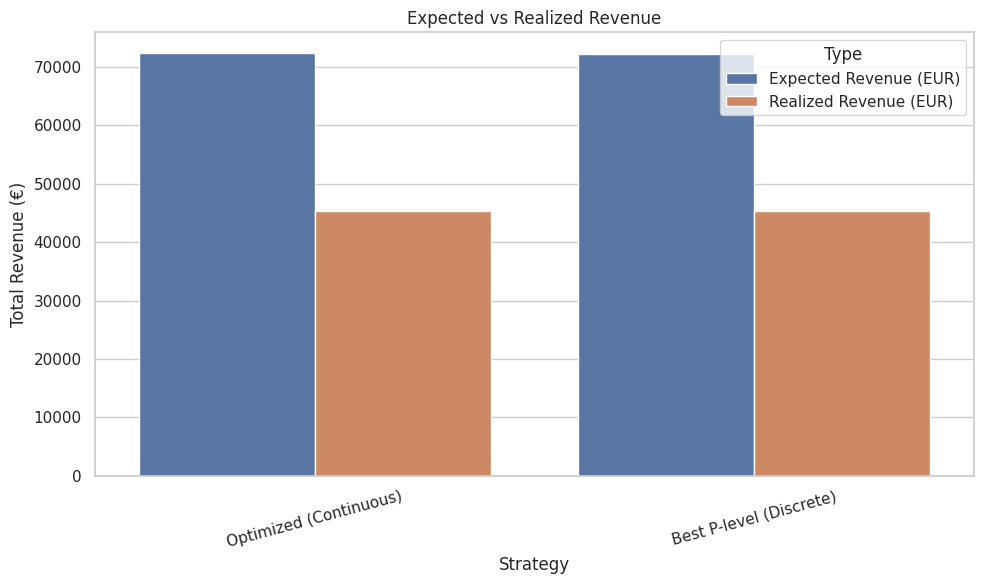

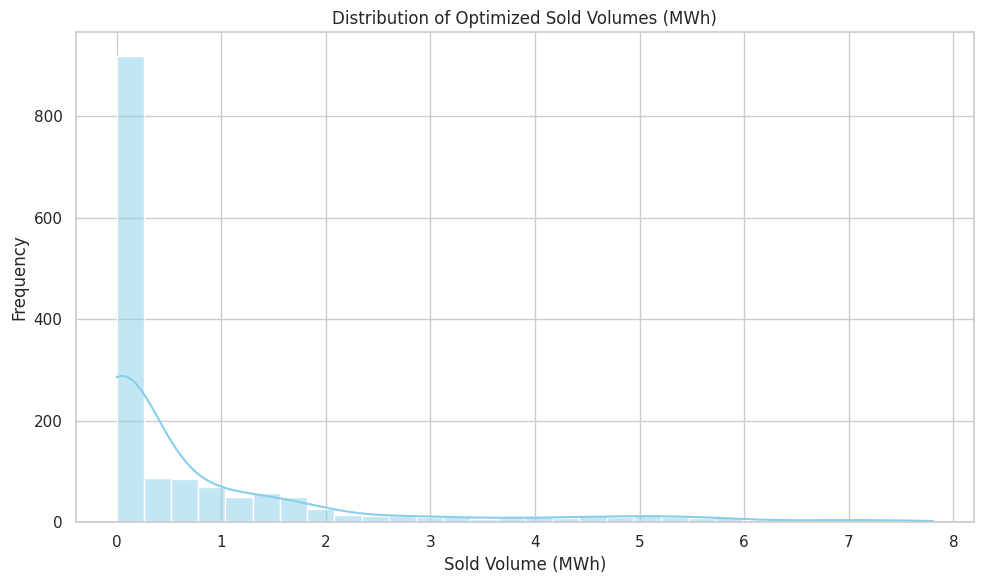

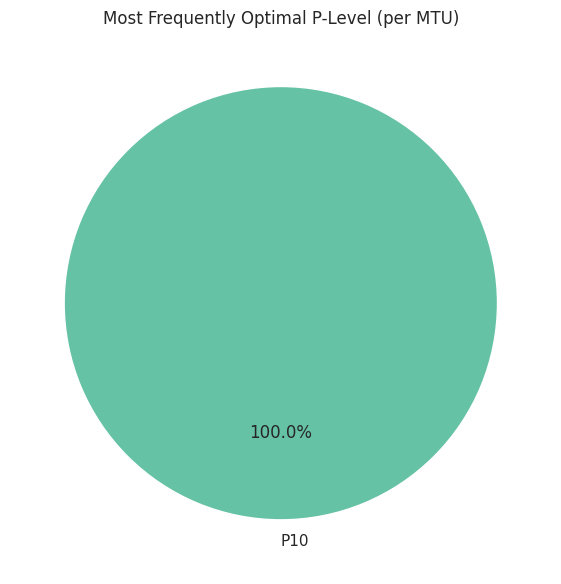

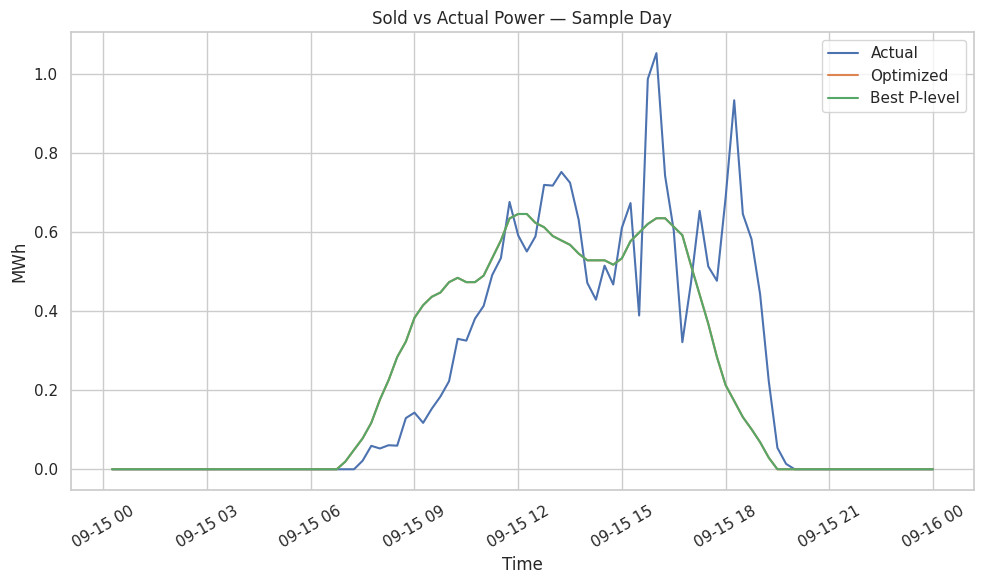

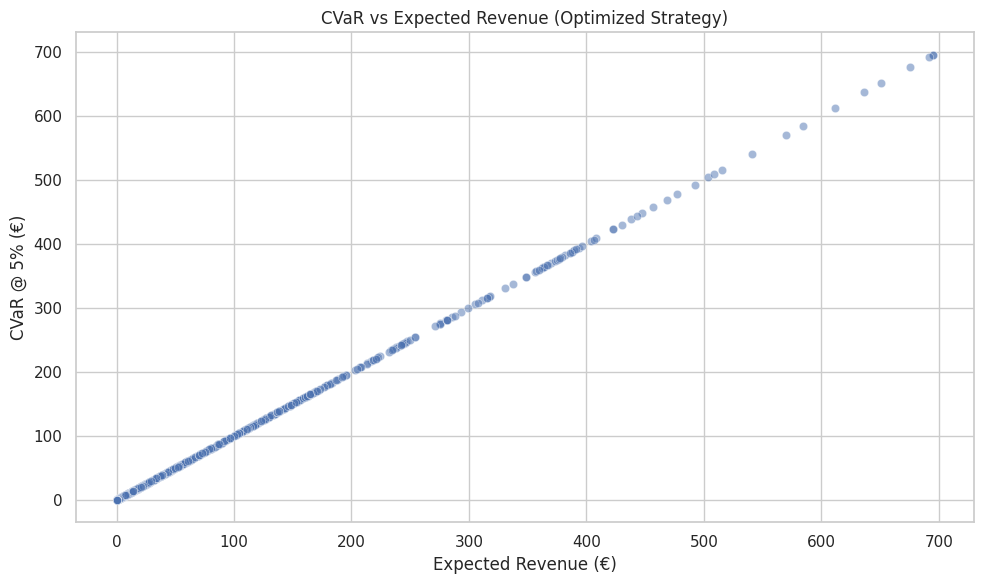

✅ KPI summary exported to sunly_strategy_kpi_summary.xlsx


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load results
file_path = "sunly_montecarlo_strategy_results.xlsx"
df = pd.read_excel(file_path)

# Set up styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ------------------------------------------------------------------------------
# 1. SUMMARY KPI TABLE
# ------------------------------------------------------------------------------
total_exp_cont = df["exp_rev_opt"].sum()
total_exp_p50 = df["exp_rev_P50"].sum()
total_realized_cont = df["realized_rev_cont"].sum()
total_realized_bestp = df["realized_rev_best_p"].sum()

kpi_summary = pd.DataFrame({
    "Strategy": ["Optimized (Continuous)", "Best P-level (Discrete)"],
    "Expected Revenue (EUR)": [total_exp_cont, total_exp_p50],
    "Realized Revenue (EUR)": [total_realized_cont, total_realized_bestp],
})

# ------------------------------------------------------------------------------
# 2. BAR PLOT — Expected vs Realized Revenue
# ------------------------------------------------------------------------------
kpi_melt = kpi_summary.melt(id_vars="Strategy", var_name="Type", value_name="EUR")
plt.figure()
sns.barplot(data=kpi_melt, x="Strategy", y="EUR", hue="Type")
plt.title("Expected vs Realized Revenue")
plt.ylabel("Total Revenue (€)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 3. HISTOGRAM — Optimal Sold Volume Distribution
# ------------------------------------------------------------------------------
plt.figure()
sns.histplot(df["sold_cont_mwh"], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Optimized Sold Volumes (MWh)")
plt.xlabel("Sold Volume (MWh)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 4. PIE CHART — Frequency of Best P-level Chosen
# ------------------------------------------------------------------------------
plt.figure()
df["best_p"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=["#66c2a5", "#fc8d62", "#8da0cb"])
plt.ylabel("")
plt.title("Most Frequently Optimal P-Level (per MTU)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 5. LINE PLOT — Actual vs Optimized vs Best P-level (Sample Week)
# ------------------------------------------------------------------------------
sample = df.head(96)  # 1-day = 96 MTUs

plt.figure()
plt.plot(sample["start_time"], sample["Actual_MWh_obs"], label="Actual")
plt.plot(sample["start_time"], sample["sold_cont_mwh"], label="Optimized")
plt.plot(sample["start_time"], sample["best_p_sold_mwh"], label="Best P-level")
plt.title("Sold vs Actual Power — Sample Day")
plt.xlabel("Time")
plt.ylabel("MWh")
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 6. CVaR vs Expected Revenue — Scatter
# ------------------------------------------------------------------------------
plt.figure()
sns.scatterplot(data=df, x="exp_rev_opt", y="cvar_opt", alpha=0.5)
plt.title("CVaR vs Expected Revenue (Optimized Strategy)")
plt.xlabel("Expected Revenue (€)")
plt.ylabel(f"CVaR @ 5% (€)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 7. EXPORT SUMMARY KPIs TO EXCEL/CSV
# ------------------------------------------------------------------------------
summary_export = {
    "Expected_Revenue_Optimized": total_exp_cont,
    "Expected_Revenue_P50": total_exp_p50,
    "Realized_Revenue_Optimized": total_realized_cont,
    "Realized_Revenue_Best_P": total_realized_bestp,
    "Revenue_Uplift_Expected": total_exp_cont - total_exp_p50,
    "Revenue_Uplift_Realized": total_realized_cont - total_realized_bestp
}

summary_df = pd.DataFrame([summary_export])
summary_df.to_excel("sunly_strategy_kpi_summary.xlsx", index=False)
print("✅ KPI summary exported to sunly_strategy_kpi_summary.xlsx")


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import qmc  # Sobol sampling

# ============================================================
# CONFIGURATION & PARAMETERS
# ============================================================
FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/Sunly test/Predictions.xlsx'
SHEET_NAME = "Sheet1"

NUM_SIMS = 3000
CVaR_ALPHA = 0.05
CURTAIL_ALLOWED = True
CURTAIL_COST_PER_MWH = 0.0

PRICE_GEN = {
    "mu_up": 30,
    "sigma_up": 10,
    "mu_down": 20,
    "sigma_down": 7,
    "spike_prob": 0.007,
    "spike_min": 150,
    "spike_max": 600
}

CORRECTED_P_VALUES = set()

# New parameters
RISK_AVERSION_LAMBDA = 15.0
MIN_SOLD_VOLUME = 0.05    # MWh, enforce minimal sale if positive revenue
MIN_NONZERO_SOLD = 0.01   # MWh, minimal nonzero sales to avoid zeros

# ============================================================
# STEP 1 — LOAD & CLEAN
# ============================================================
def load_and_clean_dataset(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    df = df.drop(columns=["unit", "unit.1", "Unnamed: 6"], errors="ignore")
    df = df.rename(columns={
        "pv_power_prediction_day_ahead_p10": "P10_kW",
        "pv_power_prediction_day_ahead_p50": "P50_kW",
        "pv_power_prediction_day_ahead_p90": "P90_kW",
        "actual_power": "Actual_kW",
        "day-ahead price": "DA_price"
    })
    df["start_time"] = pd.to_datetime(df["start_time"])
    df = df.sort_values("start_time")

    # Convert kW to MWh per 15 min (0.25 h) — if your forecasts are indeed in kW
    for col in ["P10_kW", "P50_kW", "P90_kW", "Actual_kW"]:
        df[col.replace("_kW", "_MWh")] = df[col] * 0.25 / 1000

    # Add mean upward/downward imbalance price (baseline) columns
    df["Upward_price"] = df["DA_price"] + PRICE_GEN["mu_up"]
    df["Downward_price"] = df["DA_price"] - PRICE_GEN["mu_down"]

    print(f"Loaded {len(df)} MTUs")
    return df

# ============================================================
# STEP 2 — SAMPLING FUNCTIONS
# ============================================================
def sample_production(p10, p50, p90, n=NUM_SIMS):
    orig = (p10, p50, p90)
    # Enforce ordering: P10 <= P50 <= P90
    if p10 > p90:
        p10 = p50 = p90 = (p10 + p50 + p90) / 3
    else:
        if p10 > p50:
            p50 = p10
        if p50 > p90:
            p50 = p90
    corr = (p10, p50, p90)
    if orig != corr and corr not in CORRECTED_P_VALUES:
        print(f"⚠️ Corrected P-values {orig} → {corr}")
        CORRECTED_P_VALUES.add(corr)

    if p10 == p90:
        return np.full(n, p10)

    try:
        return np.random.triangular(left=p10, mode=p50, right=p90, size=n)
    except Exception:
        return np.full(n, p50)

def sample_imbalance_prices(da_price, n=NUM_SIMS):
    # Use Sobol for variance reduction (2D)
    sampler = qmc.Sobol(d=2, scramble=True)
    sob = sampler.random(n)

    # Create large normal samples to take quantiles
    upsamp = np.random.normal(da_price + PRICE_GEN["mu_up"], PRICE_GEN["sigma_up"], size=200000)
    downsamp = np.random.normal(da_price - PRICE_GEN["mu_down"], PRICE_GEN["sigma_down"], size=200000)

    up_prices = np.quantile(upsamp, sob[:, 0])
    down_prices = np.quantile(downsamp, sob[:, 1])

    up_prices = np.clip(up_prices, 0, None)
    down_prices = np.clip(down_prices, 0, None)

    # Spike logic
    spike_mask = sob[:, 0] < PRICE_GEN["spike_prob"]
    if spike_mask.any():
        up_prices[spike_mask] = np.random.uniform(da_price + PRICE_GEN["spike_min"],
                                                  da_price + PRICE_GEN["spike_max"],
                                                  size=spike_mask.sum())

    return up_prices, down_prices

# ============================================================
# STEP 3 — SIMULATE REVENUE CURVES
# ============================================================
def simulate_revenue_mtu(p10, p50, p90, da_price, n=NUM_SIMS):
    prod = sample_production(p10, p50, p90, n)
    up_prices, down_prices = sample_imbalance_prices(da_price, n)

    sold_grid = np.linspace(0, p90, 50)
    exp_rev = np.zeros_like(sold_grid)
    cvar_rev = np.zeros_like(sold_grid)
    imbalance_std = np.zeros_like(sold_grid)

    for i, sold in enumerate(sold_grid):
        da_rev = sold * da_price
        if CURTAIL_ALLOWED:
            actual_after = np.minimum(prod, sold)
        else:
            actual_after = prod

        imbalance = actual_after - sold
        imbalance_price = np.where(imbalance < 0, up_prices, down_prices)
        imbalance_rev = imbalance * imbalance_price
        total_rev = da_rev + imbalance_rev

        if CURTAIL_ALLOWED and CURTAIL_COST_PER_MWH > 0:
            curtail = np.maximum(0, prod - sold)
            total_rev = total_rev - curtail * CURTAIL_COST_PER_MWH

        exp_rev[i] = np.mean(total_rev)
        thr = np.quantile(total_rev, CVaR_ALPHA)
        cvar_rev[i] = np.mean(total_rev[total_rev <= thr])
        imbalance_std[i] = np.std(imbalance)

    return sold_grid, exp_rev, cvar_rev, imbalance_std

# ============================================================
# STEP 4 — CONTINUOUS OPTIMAL SOLD VOLUME
# ============================================================
def optimize_mtu(p10, p50, p90, da_price):
    sold_grid, exp_rev, cvar_rev, _ = simulate_revenue_mtu(p10, p50, p90, da_price)
    idx = np.argmax(exp_rev)
    return {
        "sold_cont_mwh": sold_grid[idx],
        "exp_rev_opt": exp_rev[idx],
        "cvar_opt": cvar_rev[idx],
        "sold_grid": sold_grid,
        "exp_rev": exp_rev,
        "cvar_rev": cvar_rev
    }

# ============================================================
# STEP 5 — P-LEVEL SELECTION (with minimal non-zero logic)
# ============================================================
def select_best_p_level(p10, p50, p90, da_price,
                        risk_lambda=RISK_AVERSION_LAMBDA,
                        min_sold=MIN_SOLD_VOLUME):
    sold_grid, exp_rev, cvar_rev, imbalance_std = simulate_revenue_mtu(p10, p50, p90, da_price)
    results = {}

    for label, fixed in zip(["P10", "P50", "P90"], [p10, p50, p90]):
        idx = np.argmin(np.abs(sold_grid - fixed))
        sold_val = sold_grid[idx]

        # Enforce minimal nonzero sale
        if exp_rev[idx] > 0:
            if sold_val < min_sold:
                sold_val = max(min_sold, MIN_NONZERO_SOLD)
                idx = np.argmin(np.abs(sold_grid - sold_val))

        score = exp_rev[idx] - risk_lambda * imbalance_std[idx]
        results[label] = {
            "sold": sold_grid[idx],
            "exp_rev": exp_rev[idx],
            "cvar": cvar_rev[idx],
            "imbalance_std": imbalance_std[idx],
            "score": score
        }

    best = max(results, key=lambda k: results[k]["score"])
    return best, results

# ============================================================
# STEP 6 — REALIZED REVENUE (ex-post)
# ============================================================
def realized_revenue(sold, actual, da_price, up_price, down_price):
    da_rev = sold * da_price
    imbalance = actual - sold
    imbalance_price = np.where(imbalance < 0, up_price, down_price)
    imbalance_rev = imbalance * imbalance_price

    curtail_costs = 0
    if CURTAIL_ALLOWED and CURTAIL_COST_PER_MWH > 0:
        curtail_costs = np.maximum(0, actual - sold) * CURTAIL_COST_PER_MWH * -1

    return da_rev + imbalance_rev + curtail_costs

# ============================================================
# STEP 7 — SENSITIVITY PIPELINE
# ============================================================
def run_pipeline_with_sensitivity(df,
                                  risk_lambda_values=[5, 10, 15],
                                  cvar_alpha_values=[0.01, 0.05],
                                  curtail_cost_values=[0.0, 0.05]):
    records = []
    global CVaR_ALPHA, RISK_AVERSION_LAMBDA, CURTAIL_COST_PER_MWH

    for rl in risk_lambda_values:
        for ca in cvar_alpha_values:
            for cc in curtail_cost_values:
                print(f"Params → λ={rl}, α={ca}, curtail_cost={cc}")
                RISK_AVERSION_LAMBDA = rl
                CVaR_ALPHA = ca
                CURTAIL_COST_PER_MWH = cc

                for _, row in df.iterrows():
                    best_lbl, res = select_best_p_level(row.P10_MWh, row.P50_MWh, row.P90_MWh, row.DA_price)
                    sold = res[best_lbl]["sold"]
                    exp_rev = res[best_lbl]["exp_rev"]
                    cvarv = res[best_lbl]["cvar"]
                    imb_std = res[best_lbl]["imbalance_std"]
                    re_rev = realized_revenue(sold,
                                               row.Actual_MWh,
                                               row.DA_price,
                                               row.Upward_price,
                                               row.Downward_price)
                    records.append({
                        "start_time": row.start_time,
                        "best_p_level": best_lbl,
                        "sold_volume": sold,
                        "expected_revenue": exp_rev,
                        "cvar": cvarv,
                        "imbalance_std": imb_std,
                        "realized_revenue": re_rev,
                        "risk_lambda": rl,
                        "cvar_alpha": ca,
                        "curtail_cost": cc
                    })

    return pd.DataFrame(records)

# ============================================================
# MAIN
# ============================================================
if __name__ == "__main__":
    df = load_and_clean_dataset(FILE_PATH, SHEET_NAME)

    results = run_pipeline_with_sensitivity(
        df,
        risk_lambda_values=[5, 10, 15],
        cvar_alpha_values=[0.01, 0.05],
        curtail_cost_values=[0.0, 0.05]
    )

    results.to_csv("mtu_optimization_sensitivity_results.csv", index=False)
    print("Saved results to mtu_optimization_sensitivity_results.csv")




Loaded 1535 MTUs
Params → λ=5, α=0.01, curtail_cost=0.0
⚠️ Corrected P-values (0.00975, 0.0, 0.0) → (0.00325, 0.00325, 0.00325)
⚠️ Corrected P-values (0.049, 0.033325, 0.0195) → (0.03394166666666667, 0.03394166666666667, 0.03394166666666667)
⚠️ Corrected P-values (0.10775, 0.07825, 0.049) → (0.07833333333333332, 0.07833333333333332, 0.07833333333333332)
⚠️ Corrected P-values (0.17625, 0.11255, 0.07825) → (0.12235, 0.12235, 0.12235)
⚠️ Corrected P-values (0.2545, 0.17625, 0.1175) → (0.18274999999999997, 0.18274999999999997, 0.18274999999999997)
⚠️ Corrected P-values (0.34275, 0.2545, 0.17625) → (0.25783333333333336, 0.25783333333333336, 0.25783333333333336)
⚠️ Corrected P-values (0.4405, 0.323, 0.22525) → (0.32958333333333334, 0.32958333333333334, 0.32958333333333334)
⚠️ Corrected P-values (0.5385, 0.4015, 0.284) → (0.408, 0.408, 0.408)
⚠️ Corrected P-values (0.61675, 0.4259, 0.323) → (0.45521666666666666, 0.45521666666666666, 0.45521666666666666)
⚠️ Corrected P-values (0.756, 0.56425, 

Columns: ['start_time', 'best_p_level', 'sold_volume', 'expected_revenue', 'cvar', 'imbalance_std', 'realized_revenue', 'risk_lambda', 'cvar_alpha', 'curtail_cost']
Sample:
            start_time best_p_level  sold_volume  expected_revenue  cvar  \
0 2025-09-15 00:15:00          P10          0.0               0.0   0.0   
1 2025-09-15 00:30:00          P10          0.0               0.0   0.0   
2 2025-09-15 00:45:00          P10          0.0               0.0   0.0   
3 2025-09-15 01:00:00          P10          0.0               0.0   0.0   
4 2025-09-15 01:15:00          P10          0.0               0.0   0.0   

   imbalance_std  realized_revenue  risk_lambda  cvar_alpha  curtail_cost  
0            0.0               0.0            5        0.01           0.0  
1            0.0               0.0            5        0.01           0.0  
2            0.0               0.0            5        0.01           0.0  
3            0.0               0.0            5        0.01           0

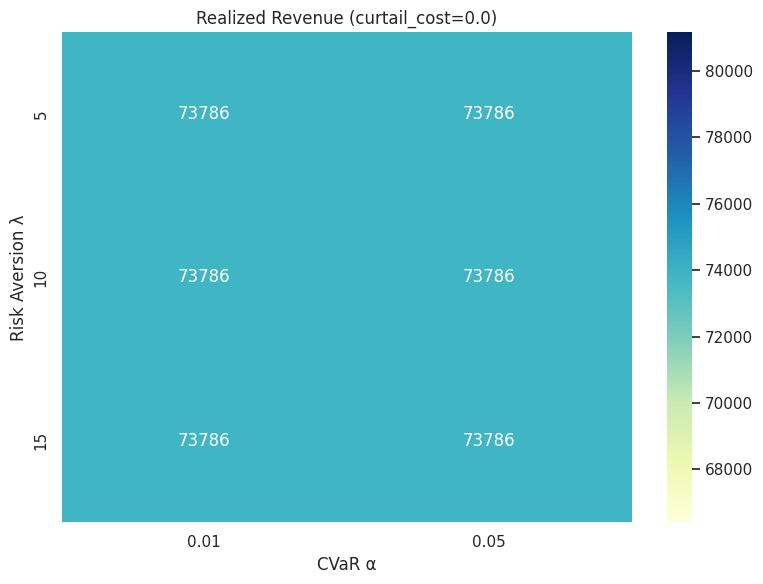

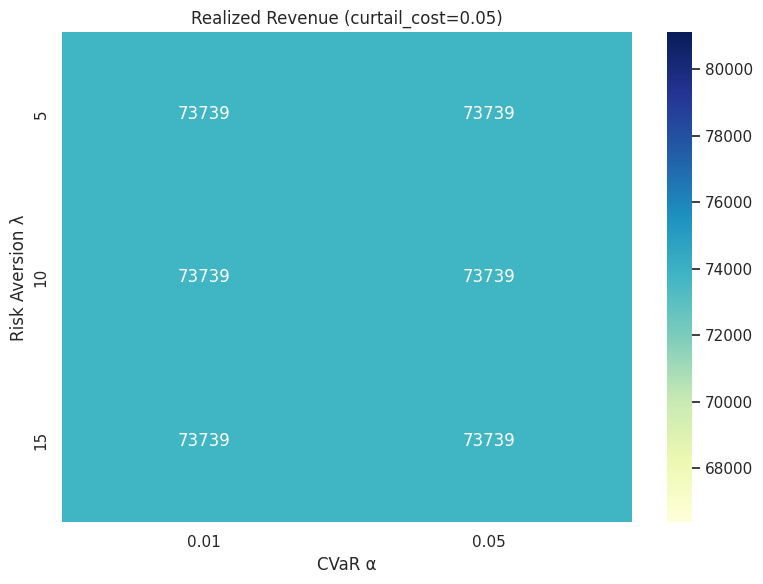

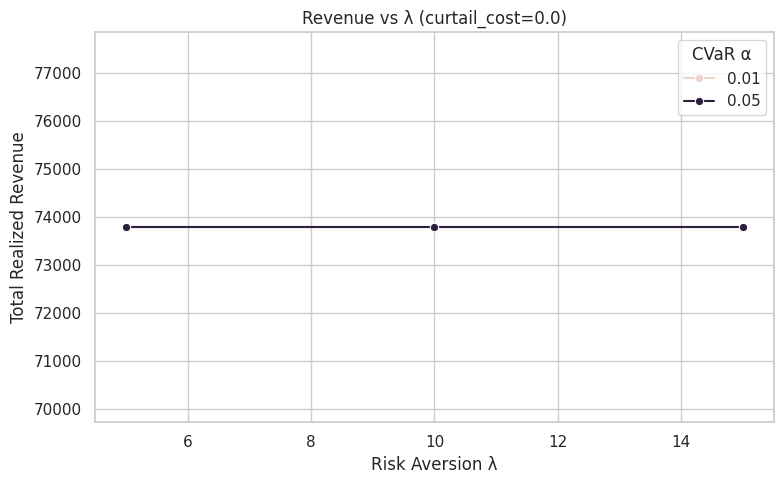

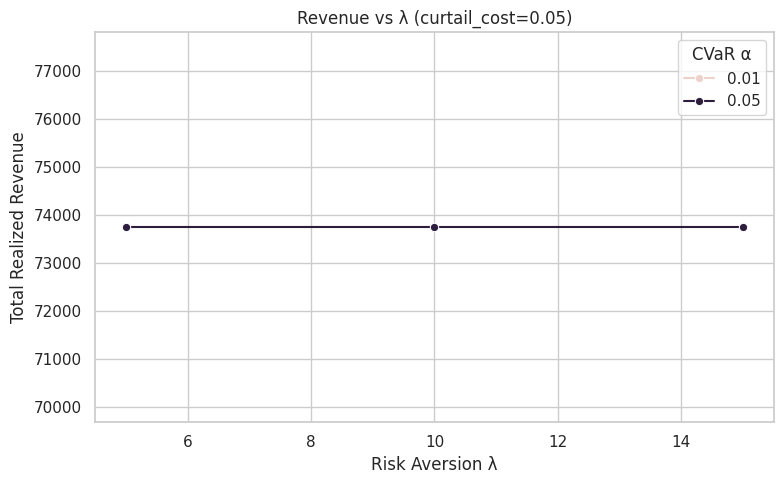

Best parameters: {'risk_lambda': 5.0, 'cvar_alpha': 0.01, 'curtail_cost': 0.0, 'total_realized_revenue': 73786.47268803467, 'mean_expected_revenue': 47.08382196742671, 'mean_sold_volume': 0.8601498371335504, 'mean_imbalance_std': 0.0, 'count': 1535.0, 'ratio_realized_to_expected': 1.0209316343931398}


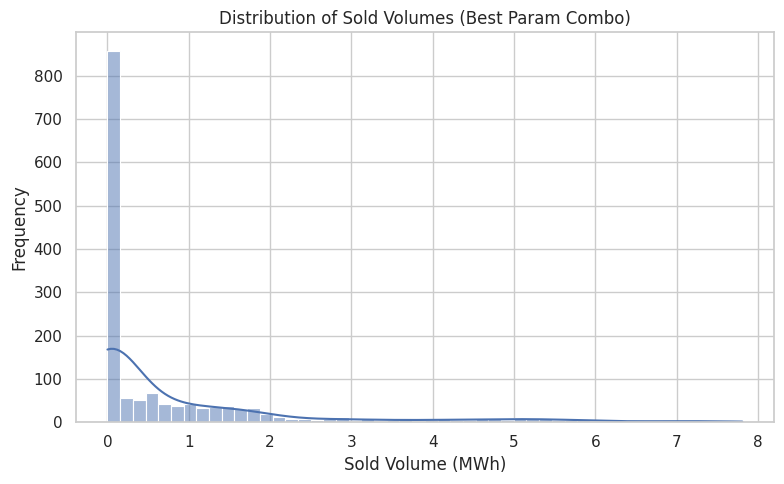

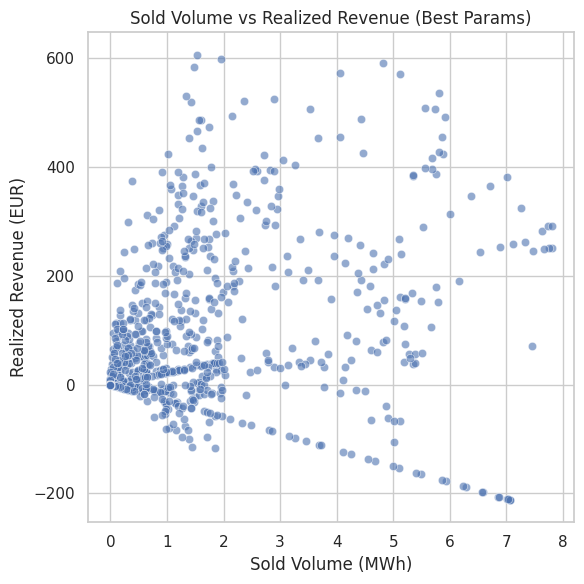

Best P-level frequency:
 best_p_level
P10    1.0
Name: proportion, dtype: float64


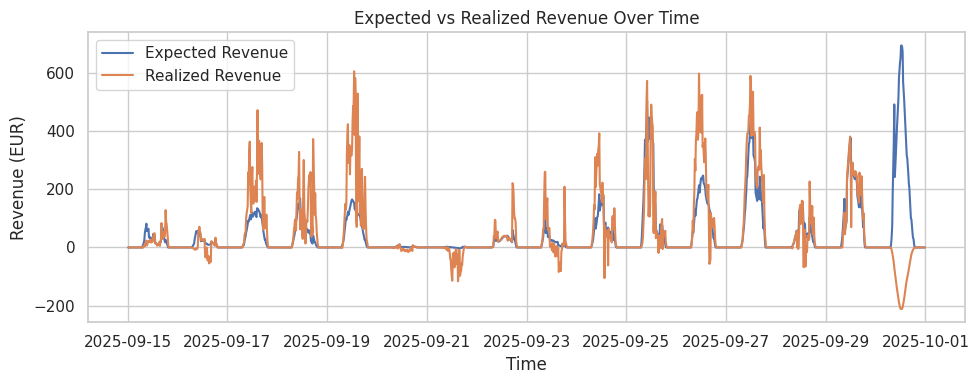

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: for interactive plots
# import plotly.express as px

# ========== 1. Load Results ==========

FILE = "mtu_optimization_sensitivity_results.csv"
df = pd.read_csv(FILE, parse_dates=["start_time"])

# ========== 2. Clean & Inspect ==========

print("Columns:", df.columns.tolist())
print("Sample:\n", df.head())
print("Describe:\n", df.describe())

# ========== 3. Compute KPIs per parameter combination ==========

# Group by the sensitivity parameters (risk_lambda, cvar_alpha, curtail_cost)
group_cols = ["risk_lambda", "cvar_alpha", "curtail_cost"]
agg = df.groupby(group_cols).agg(
    total_realized_revenue = ("realized_revenue", "sum"),
    mean_expected_revenue = ("expected_revenue", "mean"),
    mean_sold_volume = ("sold_volume", "mean"),
    mean_imbalance_std = ("imbalance_std", "mean"),
    count = ("realized_revenue", "count")
).reset_index()

# Add ratio realized / expected
agg["ratio_realized_to_expected"] = (
    agg["total_realized_revenue"] / (agg["mean_expected_revenue"] * agg["count"])
)

print("Aggregated KPIs:\n", agg.sort_values("total_realized_revenue", ascending=False).head())

# ========== 4. Diagnostic Plots ==========

sns.set_style("whitegrid")

# 4.a Heatmap: realized revenue over risk_lambda × cvar_alpha for a fixed curtail_cost
for cc in sorted(agg["curtail_cost"].unique()):
    subset = agg[agg["curtail_cost"] == cc]
    pivot = subset.pivot(index="risk_lambda", columns="cvar_alpha", values="total_realized_revenue")
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title(f"Realized Revenue (curtail_cost={cc})")
    plt.xlabel("CVaR α")
    plt.ylabel("Risk Aversion λ")
    plt.tight_layout()
    plt.show()

# 4.b Line plots: how realized revenue changes with risk_lambda for fixed other params
for cc in sorted(agg["curtail_cost"].unique()):
    plt.figure(figsize=(8,5))
    subset = agg[agg["curtail_cost"] == cc]
    sns.lineplot(data=subset, x="risk_lambda", y="total_realized_revenue", hue="cvar_alpha", marker="o")
    plt.title(f"Revenue vs λ (curtail_cost={cc})")
    plt.xlabel("Risk Aversion λ")
    plt.ylabel("Total Realized Revenue")
    plt.legend(title="CVaR α")
    plt.tight_layout()
    plt.show()

# 4.c Distribution of sold volumes under best parameter setting
# First, find best parameter combination
best = agg.loc[agg["total_realized_revenue"].idxmax()]
print("Best parameters:", best.to_dict())

best_df = df[
    (df["risk_lambda"] == best["risk_lambda"]) &
    (df["cvar_alpha"] == best["cvar_alpha"]) &
    (df["curtail_cost"] == best["curtail_cost"])
]

plt.figure(figsize=(8,5))
sns.histplot(best_df["sold_volume"], bins=50, kde=True)
plt.title("Distribution of Sold Volumes (Best Param Combo)")
plt.xlabel("Sold Volume (MWh)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 4.d Scatter: sold vs realized revenue for best combo
plt.figure(figsize=(6, 6))
sns.scatterplot(data=best_df, x="sold_volume", y="realized_revenue", alpha=0.6)
plt.title("Sold Volume vs Realized Revenue (Best Params)")
plt.xlabel("Sold Volume (MWh)")
plt.ylabel("Realized Revenue (EUR)")
plt.tight_layout()
plt.show()

# ========== 5. Additional Plots & Checks ==========

# Fraction of times each P-level chosen in best combo
if "best_p_level" in best_df.columns:
    freq = best_df["best_p_level"].value_counts(normalize=True)
    print("Best P-level frequency:\n", freq)

# Time series plot of realized vs expected revenue over time (for best combo)
best_df_sorted = best_df.sort_values("start_time")
plt.figure(figsize=(10,4))
plt.plot(best_df_sorted["start_time"], best_df_sorted["expected_revenue"], label="Expected Revenue")
plt.plot(best_df_sorted["start_time"], best_df_sorted["realized_revenue"], label="Realized Revenue")
plt.legend()
plt.title("Expected vs Realized Revenue Over Time")
plt.xlabel("Time")
plt.ylabel("Revenue (EUR)")
plt.tight_layout()
plt.show()
